# 트랜스포머 챗봇 프로젝트


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
from sklearn.model_selection import train_test_split
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from konlpy.tag import Mecab
from tqdm.notebook import tqdm
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

import tensorflow.keras.backend as K
from itertools import product

from nltk.translate.bleu_score import sentence_bleu

%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

import torch
import math
from transformers import AutoTokenizer, AutoModelForCausalLM

mecab = Mecab()

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## 함수 및 클래스 정의

In [2]:
# 전처리 
def preprocess(sentence):
    sentence = re.sub(r"[^a-z0-9가-힣\.!\?\s]", "", sentence)
    return mecab.morphs(sentence)
def build_corpus(df):
    df.dropna(inplace=True)
    df["Q_"] = df["Q"].apply(preprocess)
    df["A_"] = df["A"].apply(preprocess)
#    df.drop_duplicates(subset=["Q_"], inplace=True)
#    df.drop_duplicates(subset=["A_"], inplace=True)
#    df.reset_index(drop=True, inplace=True)

    que_corpus, ans_corpus = [], []
    for i in range(len(df)):
        if len(df["Q_"][i]) < 28 and len(df["A_"][i]) < 35:
            que_corpus.append(df["Q_"][i])
            ans_corpus.append(["<SOS>"] + df["A_"][i] + ["<EOS>"])
    return que_corpus, ans_corpus

# Vocab Size 결정을 위한 검사
def compute_vocab_coverage(corpus, topk_list=[1000, 2000, 5000, 8000, 10000, 20000]):
    tokenizer = Tokenizer(filters="", lower=False, oov_token=None)
    tokenizer.fit_on_texts(corpus)

    word_counts = tokenizer.word_counts  # collections.OrderedDict
    sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    total_tokens = sum([count for _, count in sorted_counts])

    print(f"총 토큰 수: {total_tokens}")
    print(f"전체 단어 수 (고유): {len(sorted_counts)}")

    cumulative = np.cumsum([count for _, count in sorted_counts])
    coverage_list = [
        cumulative[k - 1] / total_tokens * 100 if k <= len(cumulative) else 100.0
        for k in topk_list
    ]

    for k, cov in zip(topk_list, coverage_list):
        print(f"Vocab Size = {k:5d} → Coverage: {cov:.2f}%")

    plt.figure(figsize=(8, 4))
    plt.plot(np.arange(1, len(cumulative) + 1), cumulative / total_tokens * 100)
    plt.xlabel("Vocab Size (Top-N Words)")
    plt.ylabel("Coverage (%)")
    plt.title("Vocab Size vs. Token Coverage")
    plt.grid(True)
    plt.axhline(95, color="r", linestyle="--", label="95% Cutoff")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 토큰화
def tokenize(corpus1, corpus2, vocab_size=None, oov_token="<OOV>"):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, lower=False, filters="")
    tokenizer.fit_on_texts(corpus1 + corpus2)

    tensor1 = tokenizer.texts_to_sequences(corpus1)
    tensor2 = tokenizer.texts_to_sequences(corpus2)

    tensor1 = tf.keras.preprocessing.sequence.pad_sequences(tensor1, padding="post")
    tensor2 = tf.keras.preprocessing.sequence.pad_sequences(tensor2, padding="post")

    return tensor1, tensor2, tokenizer

### 트랜스포머 구현
# 포지셔널 인코딩
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2 * (i // 2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

# 마스크
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]
def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask
def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None:
            scaled_qk += mask * -1e9

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

# 포지션와이즈 피드포워드
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation="relu")
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)

        return out

#인코더
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, enc_attn

class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [
            EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)
        ]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

# 디코더
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(
            Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask
        )
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn
    
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [
            DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)
        ]

    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](
                out, enc_out, dec_enc_mask, padding_mask
            )

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

# 트랜스포머 
class Transformer(tf.keras.Model):
    def __init__(
        self,
        n_layers,
        d_model,
        n_heads,
        d_ff,
        src_vocab_size,
        tgt_vocab_size,
        pos_len,
        dropout=0.2,
        shared_fc=True,
        shared_emb=False,
    ):
        super(Transformer, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = tf.keras.layers.Embedding(
                src_vocab_size, d_model
            )
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc:
            out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = self.decoder(
            dec_in, enc_out, dec_enc_mask, dec_mask
        )

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns
    
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[
        :, 1:
    ]  # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(
            src, tgt_in, enc_mask, dec_enc_mask, dec_mask
        )
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

@tf.function
def eval_step(src, tgt, model):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    predictions, enc_attns, dec_attns, dec_enc_attns = model(
        src, tgt_in, enc_mask, dec_enc_mask, dec_mask
    )

    loss = loss_function(gold, predictions)

    return loss, enc_attns, dec_attns, dec_enc_attns

# 옵션 
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=500):
        super(LearningRateScheduler, self).__init__()

        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step**-0.5
        arg2 = step * (self.warmup_steps**-1.5)

        return (self.d_model**-0.5) * tf.math.minimum(arg1, arg2)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.wait = 0
        self.stopped_epoch = 0
        self.stop_training = False

    def on_epoch_end(self, epoch, current):
        if self.best is None or current < self.best - self.min_delta:
            self.best = current
            self.wait = 0
            return True
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stop_training = True
                self.stopped_epoch = epoch
            return False
    

# 손실 함수
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

# 러닝커브 확인
def plot_loss_graph(train_log, test_log):
    epochs = range(1, len(train_log) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_log, label="Train Loss")
    plt.plot(epochs, test_log, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train/Test Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# 실험 자동화 
def tuner(transformer_args, name, warmup_steps=500, epoch=10):
    transformer = Transformer(**transformer_args)
    d_model = transformer_args["d_model"]

    learning_rate = LearningRateScheduler(d_model, warmup_steps=warmup_steps)
    optimizer = tf.keras.optimizers.Adam(
        learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
    )
    early_stopping = EarlyStopping(patience=3, min_delta=0.001)

    transformer, train_log, valid_log = main(
        transformer,
        optimizer,
        name,
        EPOCHS=epoch,
        early_stopping=early_stopping,
        train_dataset=train_dataset,
        valid_dataset=valid_dataset,
        save=False,
    )
    return early_stopping.best

# 실험 코드 - 훈련 및 결과 확인
def main(
    transformer,
    optimizer,
    name,
    EPOCHS=10,
    early_stopping=EarlyStopping(patience=3, min_delta=0.001),
    train_dataset=None,
    valid_dataset=None,
    save=True,
):
    train_log = []
    valid_log = []

    for epoch in range(EPOCHS):
        total_loss = 0
        dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
        tqdm_bar = tqdm(total=dataset_count)

        for batch, (src, tgt) in enumerate(train_dataset):
            loss, _, _, _ = train_step(src, tgt, transformer, optimizer)
            total_loss += loss
            tqdm_bar.set_description(f"Epoch {epoch + 1}")
            tqdm_bar.set_postfix(loss=total_loss.numpy() / (batch + 1))
            tqdm_bar.update(1)

        tqdm_bar.close()
        train_epoch_loss = total_loss.numpy() / dataset_count
        train_log.append(train_epoch_loss)
        print(f"Epoch {epoch + 1} Train Loss: {train_epoch_loss:.4f}")

        val_loss_total = 0
        val_batches = tf.data.experimental.cardinality(valid_dataset).numpy()

        for batch, (src, tgt) in enumerate(valid_dataset):
            loss, _, _, _ = eval_step(src, tgt, transformer)
            val_loss_total += loss

        val_epoch_loss = val_loss_total.numpy() / val_batches
        valid_log.append(val_epoch_loss)

        # BLEU 계산
        bleu_score = compute_bleu_from_validation(transformer, tokenizer, valid_dataset, num_samples=10)

        print(f"Epoch {epoch + 1} Validation Loss: {val_epoch_loss:.4f}")
        print(f"[Epoch {epoch + 1}] BLEU: {bleu_score:.4f}")
        
        
        evaluate_model_with_examples(transformer,tokenizer)

        is_best = early_stopping.on_epoch_end(epoch, val_epoch_loss)
        if save:
            if is_best:
                transformer.save_weights(name + "best_model.weights.h5")
                print(f"Best model saved at epoch {epoch+1}")

        if early_stopping.stop_training:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    plot_loss_graph(train_log, valid_log)
    
    evaluate_model_with_examples(transformer,tokenizer)

    if save:
        transformer.load_weights(name + "best_model.weights.h5")

    return transformer, train_log, valid_log

# 챗봇 답변 확인
def greedy_decode(model, tokenizer, input_sentence, sos_token="<SOS>", eos_token="<EOS>", max_len=40):
    """
    어텐션 캡처 없이 빠른 추론을 위한 간단한 그리디 디코드 함수입니다.
    """
    # 입력 문장 전처리
    processed_tokens = preprocess(input_sentence)
    
    # 소스 토큰화
    src_tokens = tokenizer.texts_to_sequences([processed_tokens])
    src_tokens = tf.keras.preprocessing.sequence.pad_sequences(src_tokens, padding='post')
    src = tf.constant(src_tokens)
    
    # 디코더 입력 초기화
    sos_id = tokenizer.word_index.get(sos_token, 1)
    eos_id = tokenizer.word_index.get(eos_token, 2)
    dec_input = tf.constant([[sos_id]])
    
    generated = []
    
    for i in range(max_len):
        # 마스크 생성
        enc_mask, dec_enc_mask, dec_mask = generate_masks(src, dec_input)
        
        # 예측 결과 가져오기
        logits, _, _, _ = model(src, dec_input, enc_mask, dec_enc_mask, dec_mask)
        
        # 다음 토큰 가져오기
        next_token_logits = logits[:, -1, :]
        next_id = tf.argmax(next_token_logits, axis=-1).numpy()[0]
        
        if next_id == eos_id:
            break
            
        generated.append(next_id)
        dec_input = tf.concat([dec_input, [[next_id]]], axis=-1)
    
    # 텍스트로 변환
    generated_sentence = ' '.join([tokenizer.index_word.get(id, '') for id in generated if id != 0 and id in tokenizer.index_word])
    
    return generated_sentence

# 챗봇 답변 + attention weight
def greedy_decode_with_attention(model, tokenizer, input_sentence, sos_token="<SOS>", eos_token="<EOS>", max_len=40):
    """
    그리디 디코딩으로 응답을 생성하고 디코더-인코더 어텐션을 캡처합니다.
    생성된 토큰 리스트와 디코더-인코더 어텐션 리스트를 반환합니다.
    """
    # 훈련 시와 동일한 전처리 함수를 사용하여 입력 문장 전처리
    processed_tokens = preprocess(input_sentence)
    
    # 소스 토큰화
    src_tokens = tokenizer.texts_to_sequences([processed_tokens])
    src_tokens = tf.keras.preprocessing.sequence.pad_sequences(src_tokens, padding='post')
    src = tf.constant(src_tokens)
    
    # SOS 토큰으로 디코더 입력 초기화
    sos_id = tokenizer.word_index.get(sos_token, 1)
    eos_id = tokenizer.word_index.get(eos_token, 2)
    dec_input = tf.constant([[sos_id]])
    
    generated = []
    attention_weights = []
    
    for i in range(max_len):
        # 현재 디코더 입력에 대한 마스크 생성
        enc_mask, dec_enc_mask, dec_mask = generate_masks(src, dec_input)
        
        # 로짓과 어텐션 생성
        logits, enc_attns, dec_attns, dec_enc_attns = model(src, dec_input, enc_mask, dec_enc_mask, dec_mask)
        
        # 마지막 토큰의 로짓 가져오기
        next_token_logits = logits[:, -1, :]  # (1, vocab_size)
        next_id = tf.argmax(next_token_logits, axis=-1).numpy()[0]

        # 마지막 레이어의 디코더-인코더 어텐션 저장, 헤드별 평균
        if dec_enc_attns:  # 어텐션 가중치가 존재하는지 확인
            attn = dec_enc_attns[-1][0]  # shape (num_heads, tgt_len, src_len)
            avg_attn = tf.reduce_mean(attn, axis=0).numpy()  # (tgt_len, src_len)
            attention_weights.append(avg_attn[-1])  # 마지막 출력 토큰의 어텐션
        
        # EOS 토큰이 생성되면 중단
        if next_id == eos_id:
            break
            
        generated.append(next_id)
        

        
        # 디코더 입력에 추가
        dec_input = tf.concat([dec_input, [[next_id]]], axis=-1)
    
    # 토큰 ID를 단어로 변환
    generated_sentence = ' '.join([tokenizer.index_word.get(id, '') for id in generated if id != 0 and id in tokenizer.index_word])
    
    return generated_sentence, attention_weights, processed_tokens

# 샘플 입력 응답 및 Attention Map 출력
def evaluate_model_with_examples(model, tokenizer, test_examples=None):
    """
    샘플 출력과 어텐션 시각화를 포함한 종합적인 모델 평가 함수입니다.
    """
    if test_examples is None:
        test_examples = [
            "지루하다, 놀러가고 싶어.",
            "오늘 일찍 일어났더니 피곤하다.",
            "간만에 여자친구랑 데이트 하기로 했어.",
            "집에 있는다는 소리야."
        ]
    
    print("트랜스포머 챗봇 평가 결과")
    print("=" * 80)
    
    # 응답과 어텐션 맵 시각화
    plot_responses_and_attentions(test_examples, model, tokenizer)
    
def plot_responses_and_attentions(input_texts, model, tokenizer):
    """
    4개의 입력 텍스트에 대한 응답을 생성하고 어텐션 가중치를 시각화합니다.
    """
    if len(input_texts) != 4:
        print(f"경고: 4개의 입력 텍스트가 필요하지만 {len(input_texts)}개가 제공되었습니다.")
        return
    
    responses = []
    attentions = []
    source_tokens = []
    generated_tokens_list = []
    
    # 응답 생성 및 어텐션 수집
    for text in input_texts:
        resp, attn, src_tokens = greedy_decode_with_attention(model, tokenizer, text)
        responses.append(resp)
        attentions.append(attn)
        source_tokens.append(src_tokens)
        # 생성된 토큰들을 리스트로 저장
        generated_tokens_list.append(resp.split())
    
    # 입력과 응답 출력
    print("=" * 80)
    print("챗봇 응답 결과")
    print("=" * 80)
    for i, (inp, resp) in enumerate(zip(input_texts, responses), 1):
        print(f"질문{i}: {inp}")
        print(f"답변{i}: {resp}")
        chatbot_ppl = calculate_chatbot_perplexity("gpt2", zip(inp, resp))
        print(f"챗봇 답변 Perplexity: {chatbot_ppl:.2f}")
        print("-" * 40)

        
    # 각 입력에 대한 어텐션 맵을 한 줄로 그리기
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    for idx, (inp, attn_weights, src_tokens, gen_tokens) in enumerate(zip(input_texts, attentions, source_tokens, generated_tokens_list)):
        ax = axes[idx]
        
        if len(attn_weights) > 0:
            # attn_weights는 벡터 리스트 (생성된 토큰당 하나씩)
            # 매트릭스로 스택 (generated_len, src_len)
            attn_matrix = np.stack(attn_weights, axis=0)
            
            im = ax.imshow(attn_matrix, aspect='auto', cmap='Blues', interpolation='nearest')
            
            # 라벨 설정
            ax.set_title(f"어텐션 맵 질문{idx+1}", fontsize=12, fontweight='bold')
            ax.set_xlabel("소스 토큰", fontsize=10)
            ax.set_ylabel("생성된 토큰", fontsize=10)
            
            # X축: 소스 토큰 라벨 설정
            if len(src_tokens) <= 15:  # 토큰이 너무 많지 않을 때만 토큰 라벨 표시
                ax.set_xticks(range(len(src_tokens)))
                ax.set_xticklabels(src_tokens, rotation=45, ha='right', fontsize=8)
            
            # Y축: 생성된 토큰 라벨 설정
            if len(gen_tokens) <= 10:  # 생성된 토큰이 너무 많지 않을 때만 라벨 표시
                ax.set_yticks(range(len(gen_tokens)))
                ax.set_yticklabels(gen_tokens, fontsize=8)
            
            # 각 서브플롯에 컬러바 추가
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            
        else:
            ax.text(0.5, 0.5, '어텐션 데이터 없음', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"어텐션 맵 질문{idx+1}", fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    
# BLEU Score
def compute_bleu_score(reference_texts, generated_texts):
    scores = []
    for ref, gen in zip(reference_texts, generated_texts):
        ref_tokens = ref.split()
        gen_tokens = gen.split()
        score = sentence_bleu([ref_tokens], gen_tokens, weights=(0.5, 0.5))
        scores.append(score)
    return sum(scores) / len(scores) if scores else 0
def ids_to_text(tokenizer, ids, pad_id=0):
    return ' '.join([tokenizer.index_word.get(i, '') for i in ids if i != 0 and i != pad_id])
def compute_bleu_from_validation(model, tokenizer, dataset, num_samples=10, sos_token="< SOS >", eos_token="<EOS>", pad_id=0):
    references = []
    predictions = []
    count = 0
    

    for src_batch, tgt_batch in dataset:
        for src, tgt in zip(src_batch.numpy(), tgt_batch.numpy()):
            if count >= num_samples:
                break

            src_text = ids_to_text(tokenizer, src)
            tgt_text = ids_to_text(tokenizer, tgt[1:])  # <sos> 제외

            pred_text = greedy_decode(model, tokenizer, src_text, sos_token=sos_token, eos_token=eos_token)
            
            references.append(tgt_text)
            predictions.append(pred_text)

            count += 1

        if count >= num_samples:
            break

    return compute_bleu_score(references, predictions)

# perplexity 
import torch
import math
from transformers import AutoTokenizer, AutoModelForCausalLM

def calculate_chatbot_perplexity(model_name: str, qa_pairs: list, device: str = 'cuda' if torch.cuda.is_available() else 'cpu') -> float:
    """
    챗봇의 답변 생성 능력을 평가하기 위한 perplexity 계산
    
    Args:
        model_name: HuggingFace 모델 이름
        qa_pairs: [(질문, 답변), (질문, 답변), ...] 형태의 리스트
        device: 'cuda' or 'cpu'
    
    Returns:
        답변 생성에 대한 평균 perplexity
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
    model.eval()
    
    # padding token 설정
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    total_loss = 0.0
    total_length = 0
    
    for question, answer in qa_pairs:
        # 질문과 답변을 하나의 대화 형태로 구성
        conversation = f"질문: {question}\n답변: {answer}"
        
        # 토크나이징
        inputs = tokenizer(conversation, return_tensors='pt', padding=True)
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        
        # 질문 부분의 토큰 길이 계산 (답변 부분만 loss 계산하기 위해)
        question_part = f"질문: {question}\n답변: "
        question_inputs = tokenizer(question_part, return_tensors='pt')
        question_length = question_inputs['input_ids'].size(1)
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            
            # 전체 loss에서 질문 부분 제외하고 답변 부분만 계산
            shift_logits = outputs.logits[..., :-1, :].contiguous()
            shift_labels = input_ids[..., 1:].contiguous()
            
            # 답변 부분만 마스킹
            answer_mask = torch.zeros_like(shift_labels, dtype=torch.bool)
            answer_mask[:, question_length-1:] = True  # 답변 부분만 True
            
            # Cross entropy loss 계산 (답변 부분만)
            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
            losses = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            losses = losses.view(shift_labels.shape)
            
            # 답변 부분의 loss만 계산
            masked_losses = losses * answer_mask.float()
            answer_loss = masked_losses.sum() / answer_mask.sum()
        
        answer_length = answer_mask.sum().item()
        if answer_length > 0:
            total_loss += answer_loss.item() * answer_length
            total_length += answer_length
    
    if total_length == 0:
        return float('inf')
    
    avg_loss = total_loss / total_length
    return math.exp(avg_loss)

def calculate_simple_text_perplexity(model_name: str, texts: list, device: str = 'cuda' if torch.cuda.is_available() else 'cpu') -> float:
    """
    단순 텍스트들의 perplexity 계산
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
    model.eval()
    
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    total_loss = 0.0
    total_length = 0
    
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt')
        input_ids = inputs['input_ids'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, labels=input_ids)
            loss = outputs.loss
        
        length = input_ids.size(1)
        total_loss += loss.item() * length
        total_length += length
    
    avg_loss = total_loss / total_length
    return math.exp(avg_loss)


## 데이터
### 데이터 준비

In [3]:
#데이터 준비

# 다운로드 및 압축 해제
# tf.keras.utils.get_file 사용, extract=True로 자동 해제
data_path = tf.keras.utils.get_file(
    origin='https://raw.githubusercontent.com/songys/Chatbot_data/refs/heads/master/ChatbotData.csv'
)

df = pd.read_csv(data_path)

df.head()

Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0

### EDA 및 전처리
- 중복 결측 없음
- 전체 vocab 수가 크지 않아 전체 사용

In [4]:
# 전체 샘플 수 확인
print(f"전체 샘플 개수: {len(df)}")
# 결측치 확인
print("결측치 개수:\n", df.isnull().sum())

# 빈 문자열 확인
empty_q = (df['Q'] == '').sum()
empty_a = (df['A'] == '').sum()
print(f"빈 문자열 kor: {empty_q}, eng: {empty_a}")

# 중복 확인
dup_count = df.duplicated().sum()
print(f"전체 중복 쌍 개수: {dup_count}")

# 중복 제거
df = df.drop_duplicates().reset_index(drop=True)
print(f"중복 제거 후 샘플 개수: {len(df)}")


전체 샘플 개수: 11823
결측치 개수:
 Q        0
A        0
label    0
dtype: int64
빈 문자열 kor: 0, eng: 0
전체 중복 쌍 개수: 0
중복 제거 후 샘플 개수: 11823


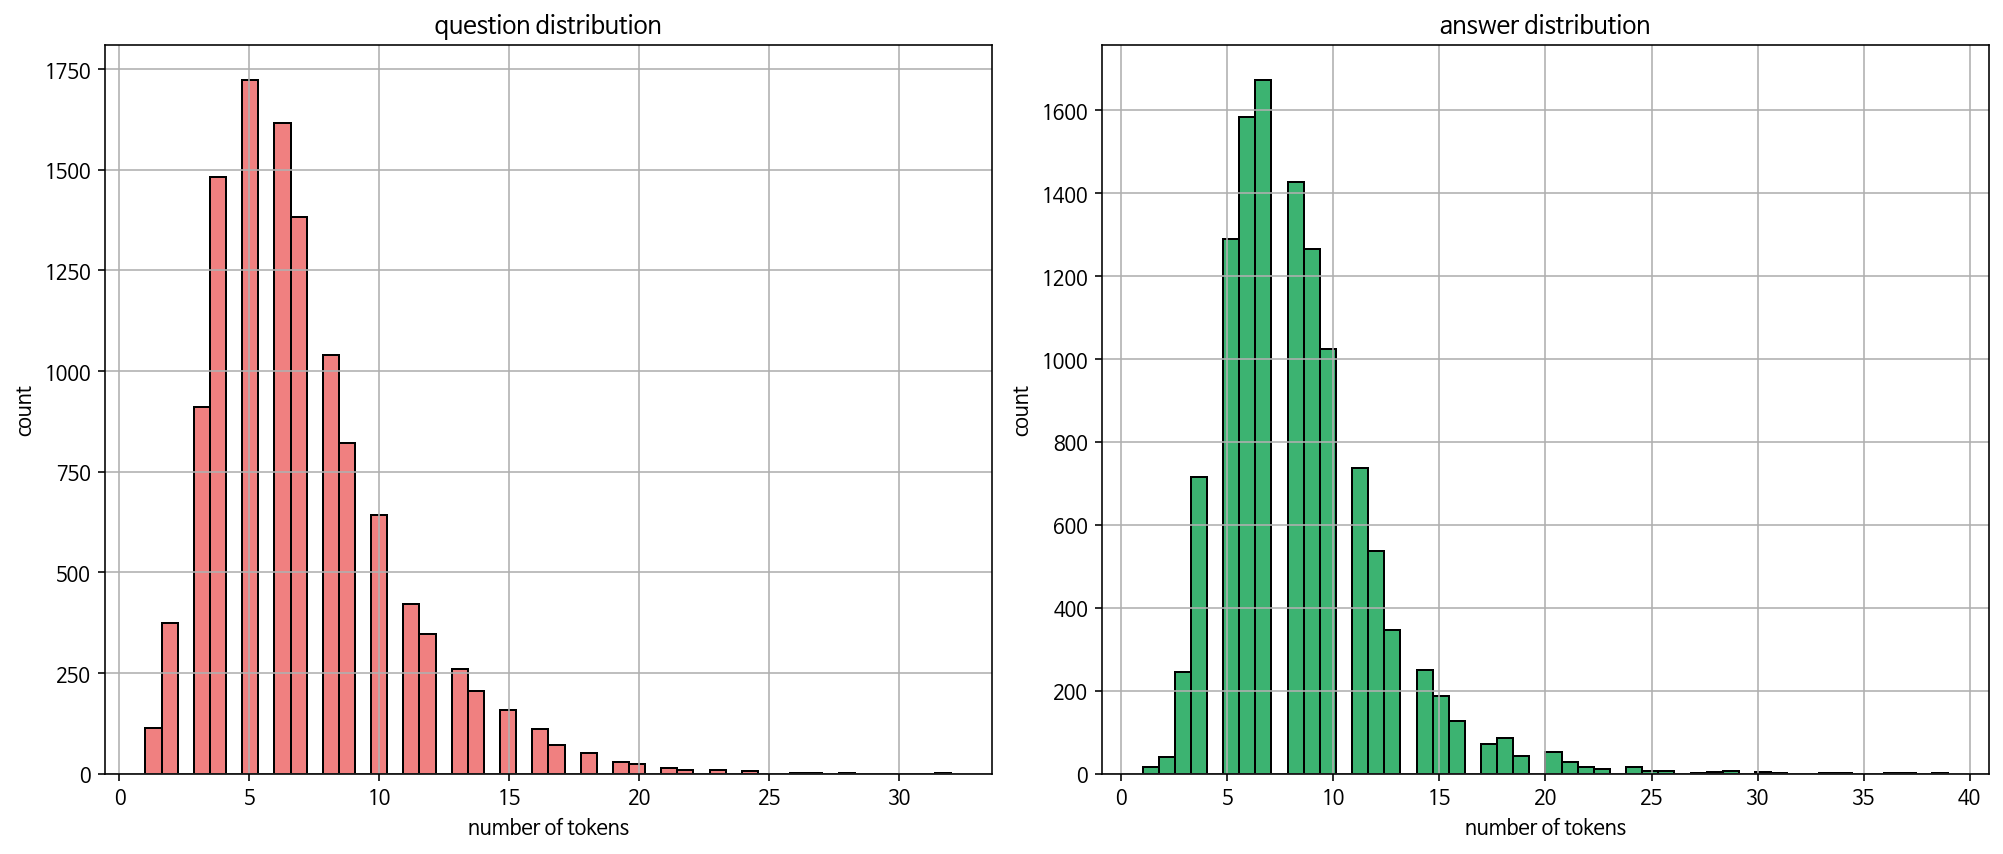

In [5]:
# 전처리
df["Q_"] = df["Q"].apply(preprocess)
df["A_"] = df["A"].apply(preprocess)
token_leng1 = df["Q_"].apply(lambda x: len(x))
token_leng2 = df["A_"].apply(lambda x: len(x))

# 토큰 수 분포 확인
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(token_leng1, bins=50, color="lightcoral", edgecolor="black")
plt.title("question distribution")
plt.xlabel("number of tokens")
plt.ylabel("count")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(token_leng2, bins=50, color="mediumseagreen", edgecolor="black")
plt.title("answer distribution")
plt.xlabel("number of tokens")
plt.ylabel("count")
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
que_corpus_t, ans_corpus_t = build_corpus(df)

총 토큰 수: 205294
전체 단어 수 (고유): 6818
Vocab Size =  1000 → Coverage: 90.64%
Vocab Size =  2000 → Coverage: 95.13%
Vocab Size =  5000 → Coverage: 99.11%
Vocab Size =  8000 → Coverage: 100.00%
Vocab Size = 10000 → Coverage: 100.00%
Vocab Size = 20000 → Coverage: 100.00%


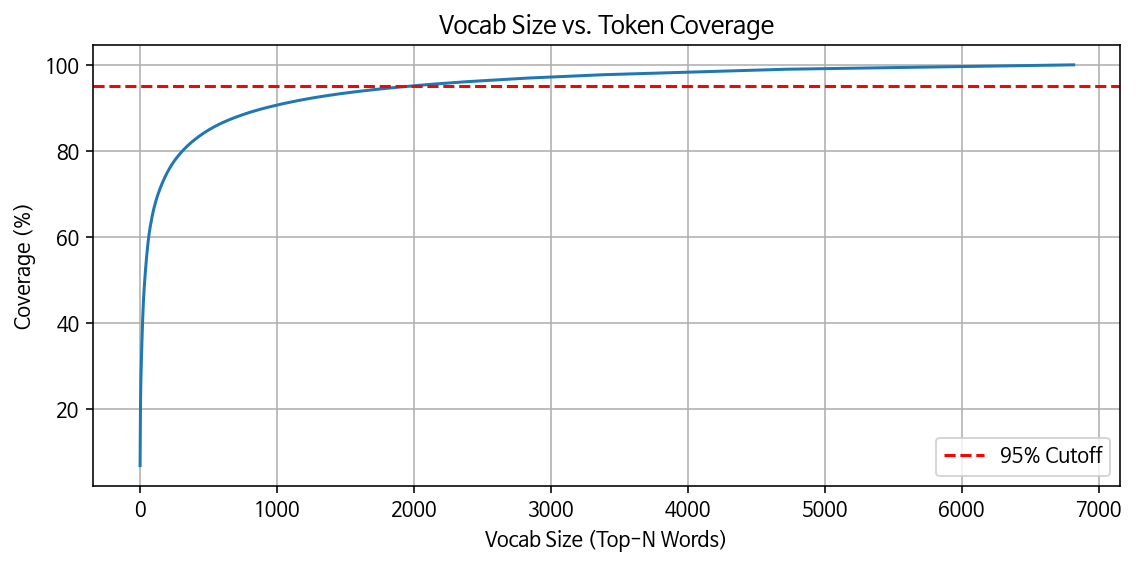

In [7]:
compute_vocab_coverage( que_corpus_t + ans_corpus_t )

### 토큰화

In [8]:
que_corpus = [" ".join(tokens) for tokens in que_corpus_t]
ans_corpus = [" ".join(tokens) for tokens in ans_corpus_t]
enc_corpus, dec_corpus, tokenizer = tokenize(que_corpus, ans_corpus)

### 훈련 검증 데이터 분리

In [9]:
enc_train, enc_test, dec_train, dec_test = train_test_split(
    enc_corpus, dec_corpus, test_size=0.1, shuffle=True, random_state=42
)

BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = (
    train_dataset.shuffle(len(enc_train)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

valid_dataset = tf.data.Dataset.from_tensor_slices((enc_test, dec_test))
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

## 실험 조건 설정 ( 하이퍼파라미터 )
- 독립 변인 
    - 레이어 수 : 1, 2
    - 모델차원  : 128, 368
- 기타 변인 통제
    - 헤더수 : 8
    - 피드포워드 차원 : 1024
    - Dropout : 0.2

In [10]:
from itertools import product

search_space = {
    "n_layers": [1,2],
    "d_model": [128,368],
    "n_heads": [8],
    "d_ff": [1024],
    "dropout": [0.2],
}

In [11]:
keys, values = zip(*search_space.items())
arg_combinations = [dict(zip(keys, v)) for v in product(*values)]

## 모델 훈련 및 결과 확인

Trial 1/4: {'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 1 Train Loss: 5.2315
Epoch 1 Validation Loss: 3.7169
[Epoch 1] BLEU: 0.0000
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 저 도 좋 은 좋 은 좋 은 좋 아요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 67.90
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 저 도 좋 은 사람 이 에요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 61.79
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 사랑 은 사랑 이 에요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 61.91
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 저 도 좋 은 사람 이 에요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 56.62
----------------------------------------


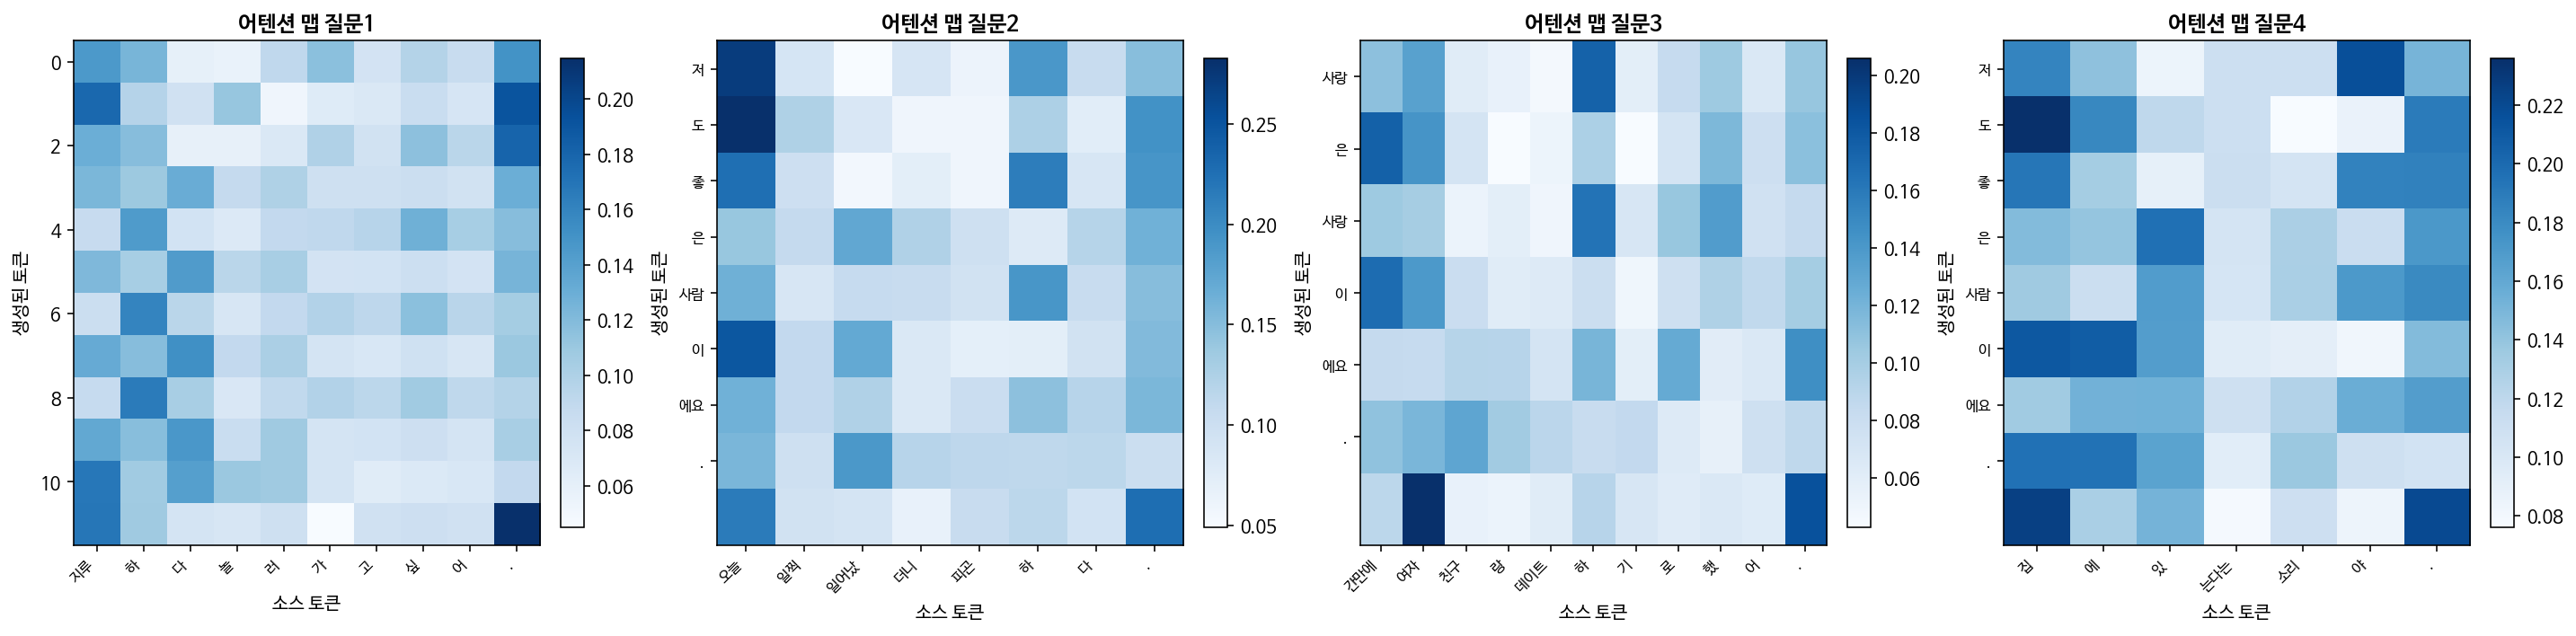

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 2 Train Loss: 3.2724
Epoch 2 Validation Loss: 3.1414
[Epoch 2] BLEU: 0.0000
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 혼자 만 놀 아요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 43.25
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 제 가 채워 줄게요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 39.59
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 친구 를 즐기 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 36.59
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 제 가 채워 줄게요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 42.89
----------------------------------------


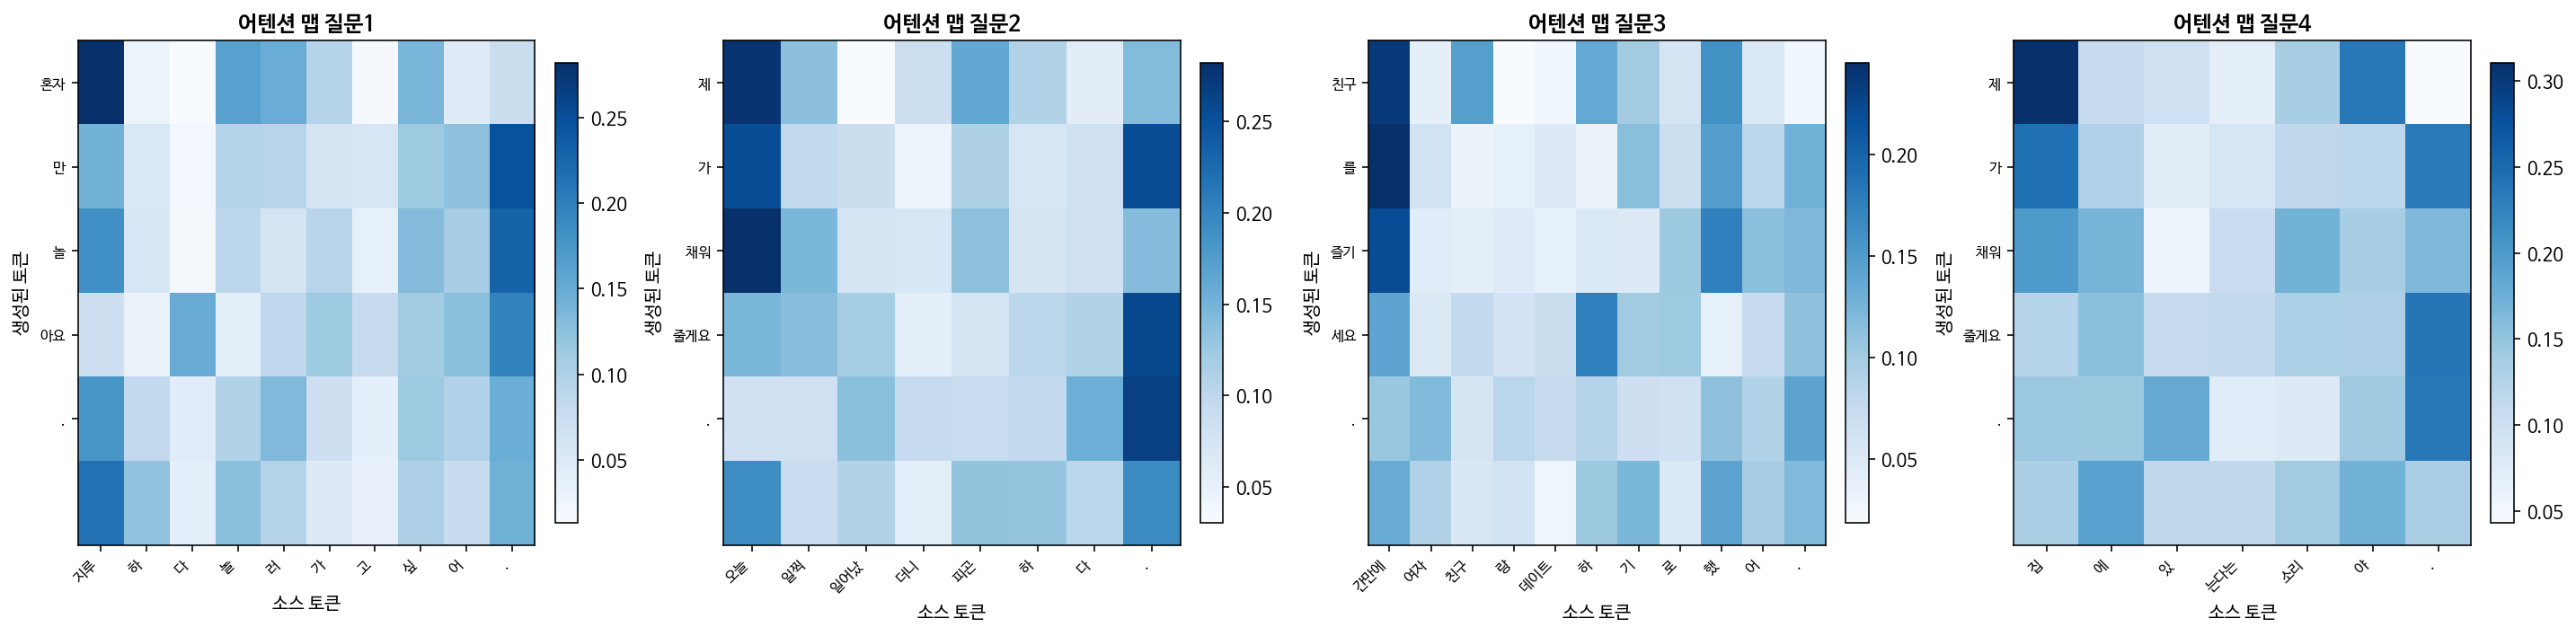

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 3 Train Loss: 2.6284


/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch 3 Validation Loss: 2.9585
[Epoch 3] BLEU: 0.0000
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 제 가 있 잖아요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 28.90
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 제 가 생각 하 셨 나 봐요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 49.13
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 노력 하 면 하 겠 어요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 44.58
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 제 가 생각 하 잖아요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 30.01
----------------------------------------


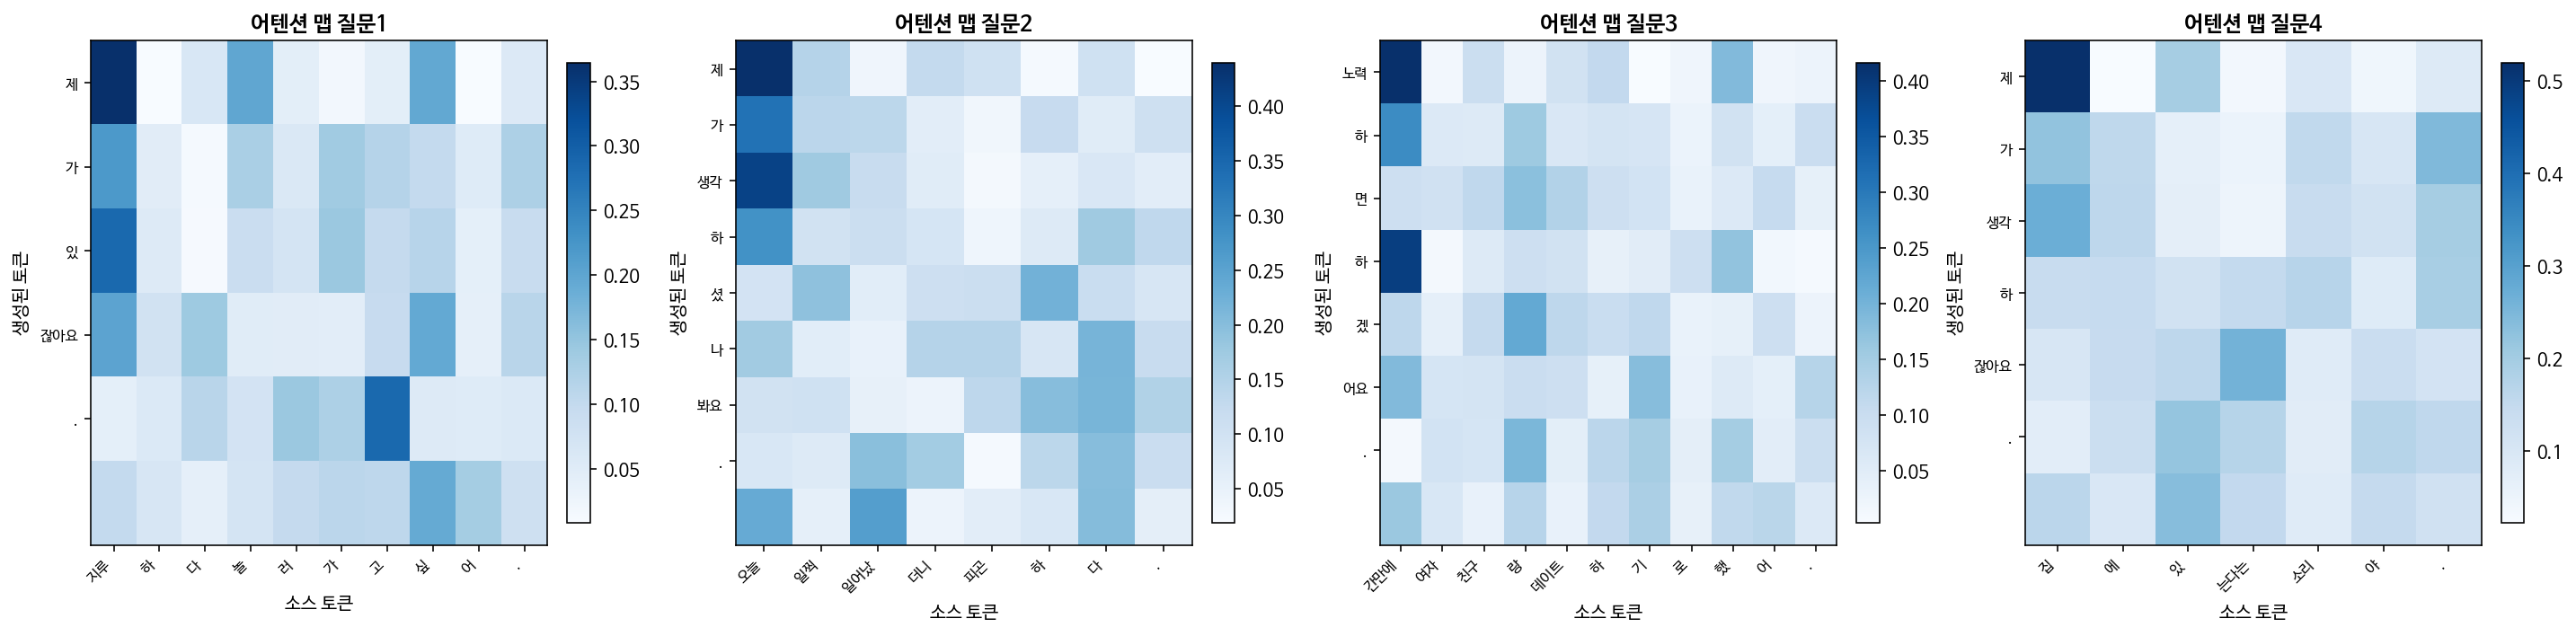

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.0706
Epoch 4 Validation Loss: 2.7898
[Epoch 4] BLEU: 0.0000
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 좋 은 사람 만날 수 있 을 거 예요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 83.00
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 조금 만 더 버텨 보 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 32.16
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 당신 의 삶 에 대해 생각 해 보 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 51.72
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 글 을 쓰 고 싶 네요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 43.64
----------------------------------------


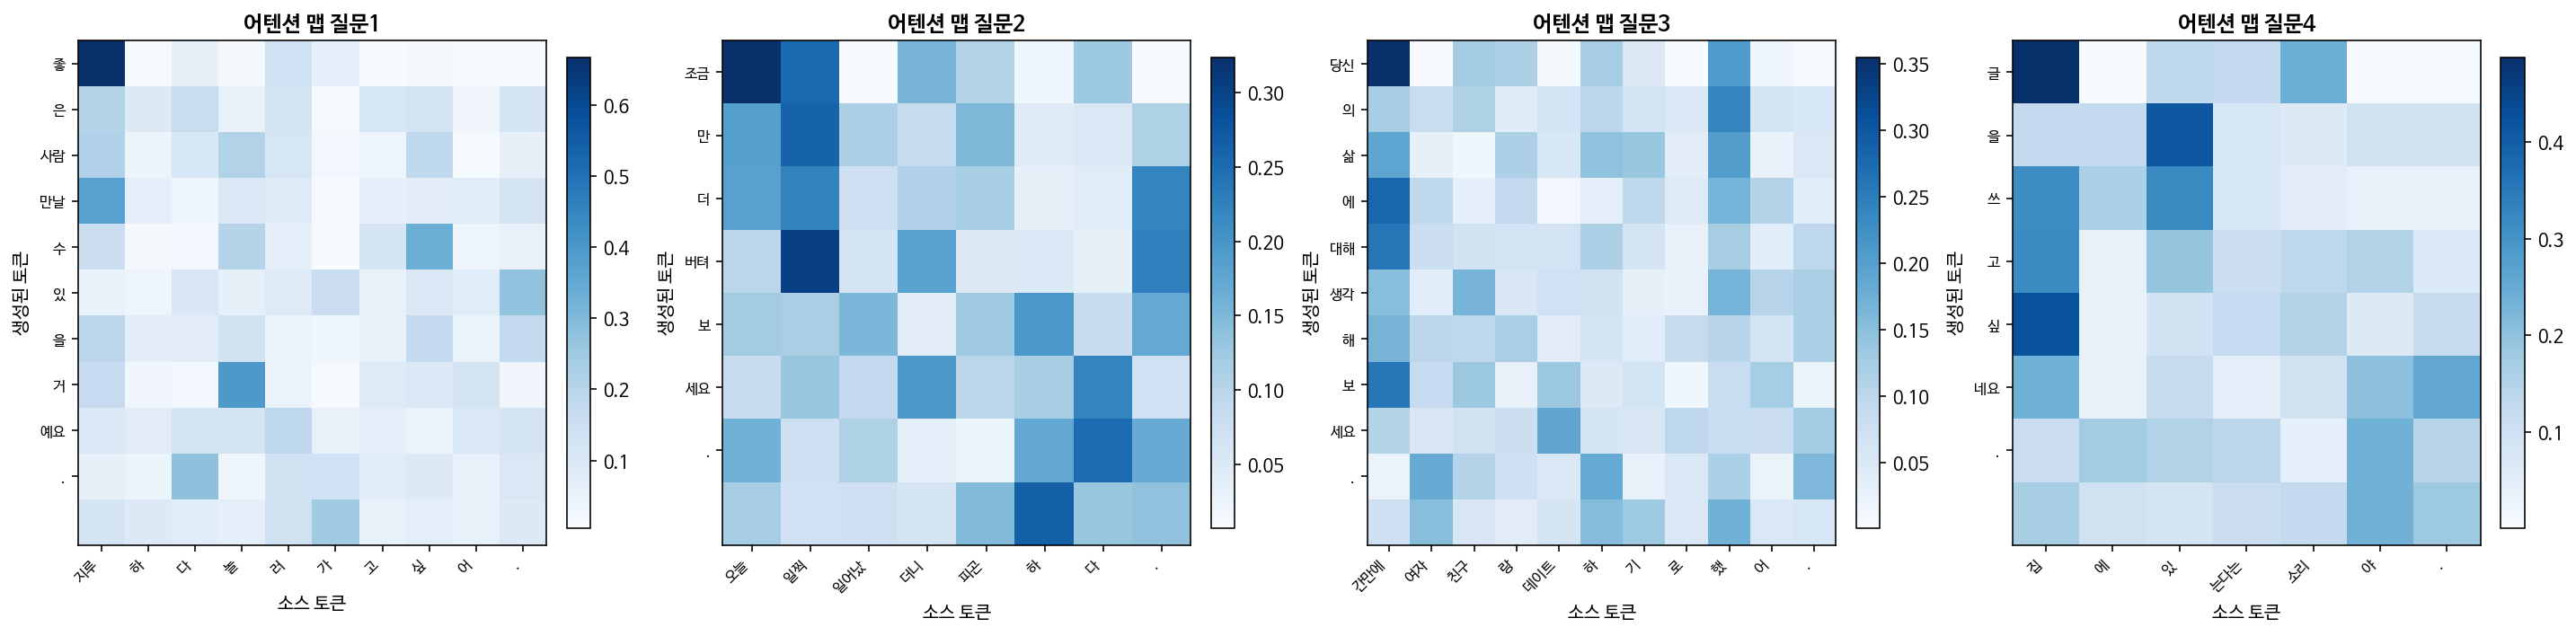

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 5 Train Loss: 1.5004
Epoch 5 Validation Loss: 2.7801
[Epoch 5] BLEU: 0.0389
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 마음 에 따라 얼마 든지 바뀔 수 있 어요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 41.60
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 제 가 들 어 가 있 네요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 24.77
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 인생 은 아니 었 을 거 예요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 38.29
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 같이 가 보 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 20.33
----------------------------------------


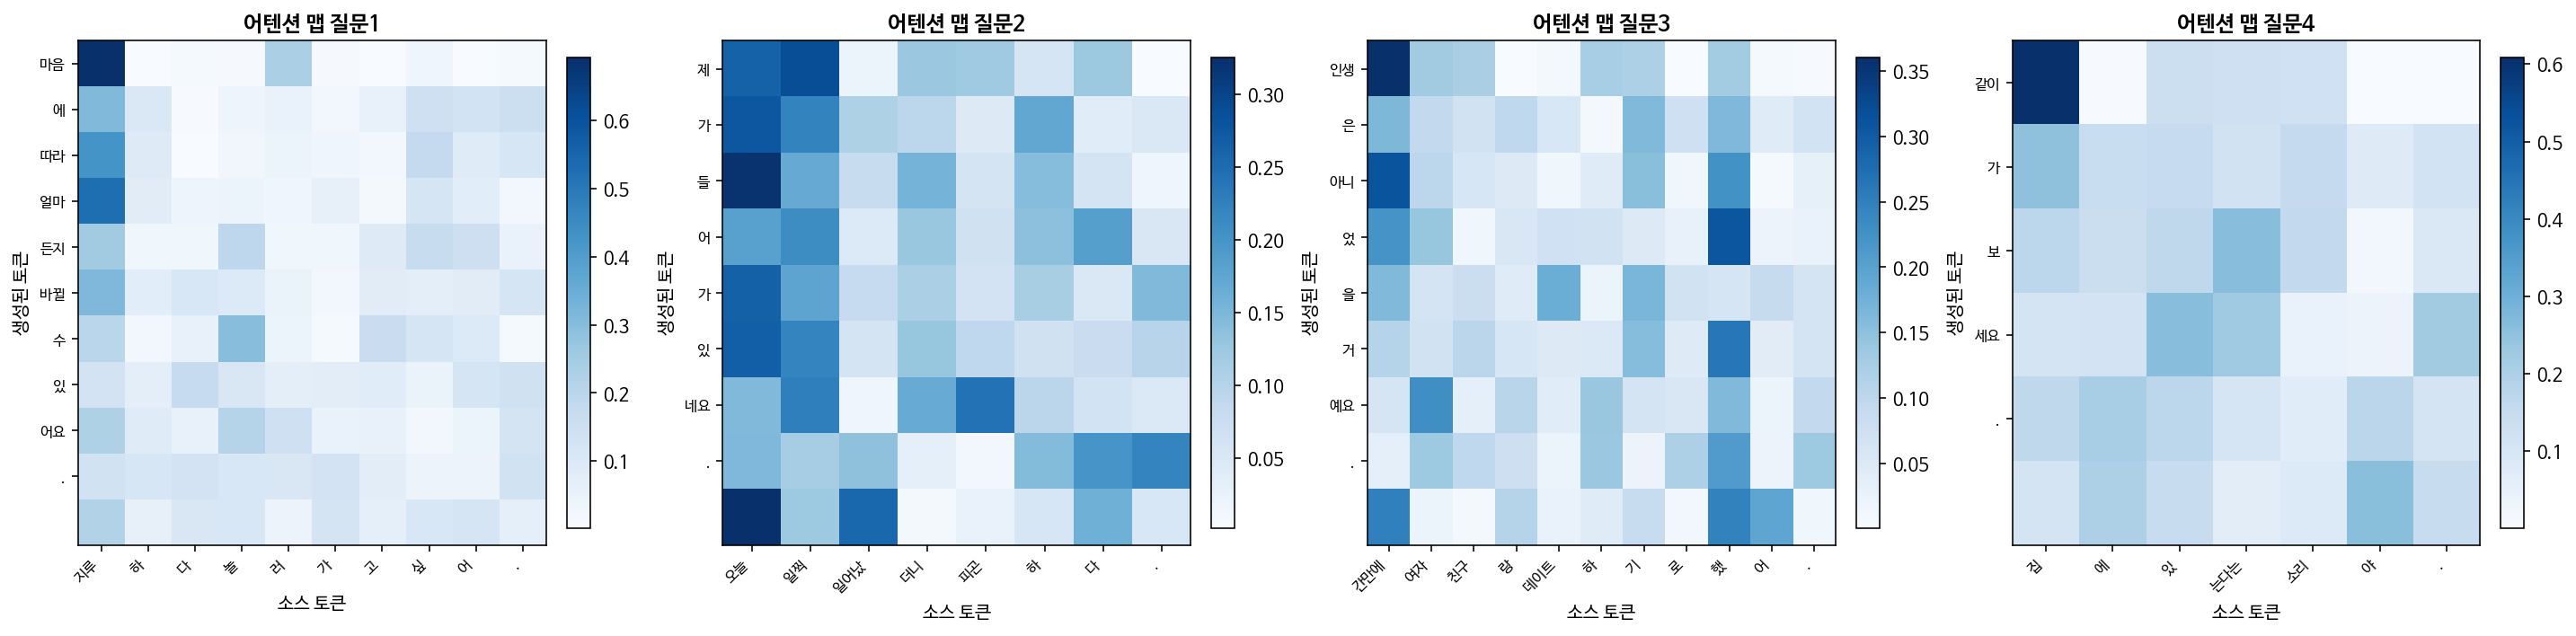

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.0852
Epoch 6 Validation Loss: 2.9346
[Epoch 6] BLEU: 0.0268
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 마음 에 따라 얼마 든지 바뀔 수 있 어요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 41.60
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 안전 귀 가 하 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 20.10
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 아니 에요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 44.39
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 같이 가 보 고 싶 네요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 22.19
----------------------------------------


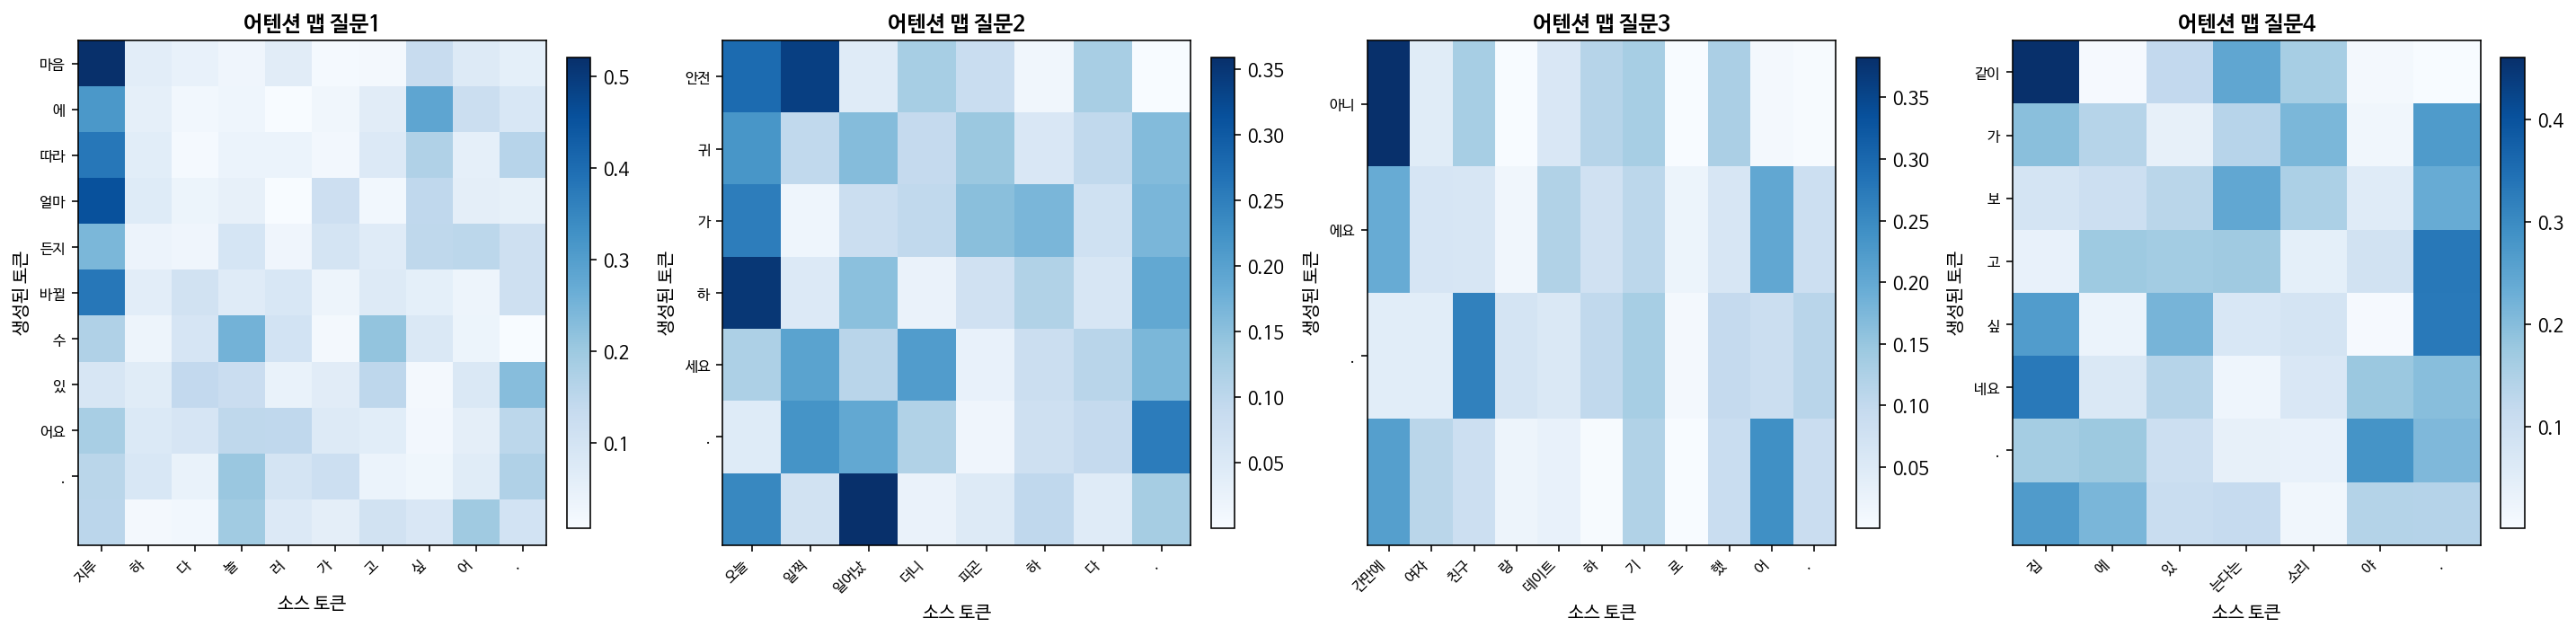

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.8026
Epoch 7 Validation Loss: 3.0757
[Epoch 7] BLEU: 0.0268
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 같이 운동 해 봐요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 18.78
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 헛헛 하 시 군요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 38.08
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 싸우 면서 정 들 거 예요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 39.42
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 운동 은 현실 과 못할 이 에요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 17.63
----------------------------------------


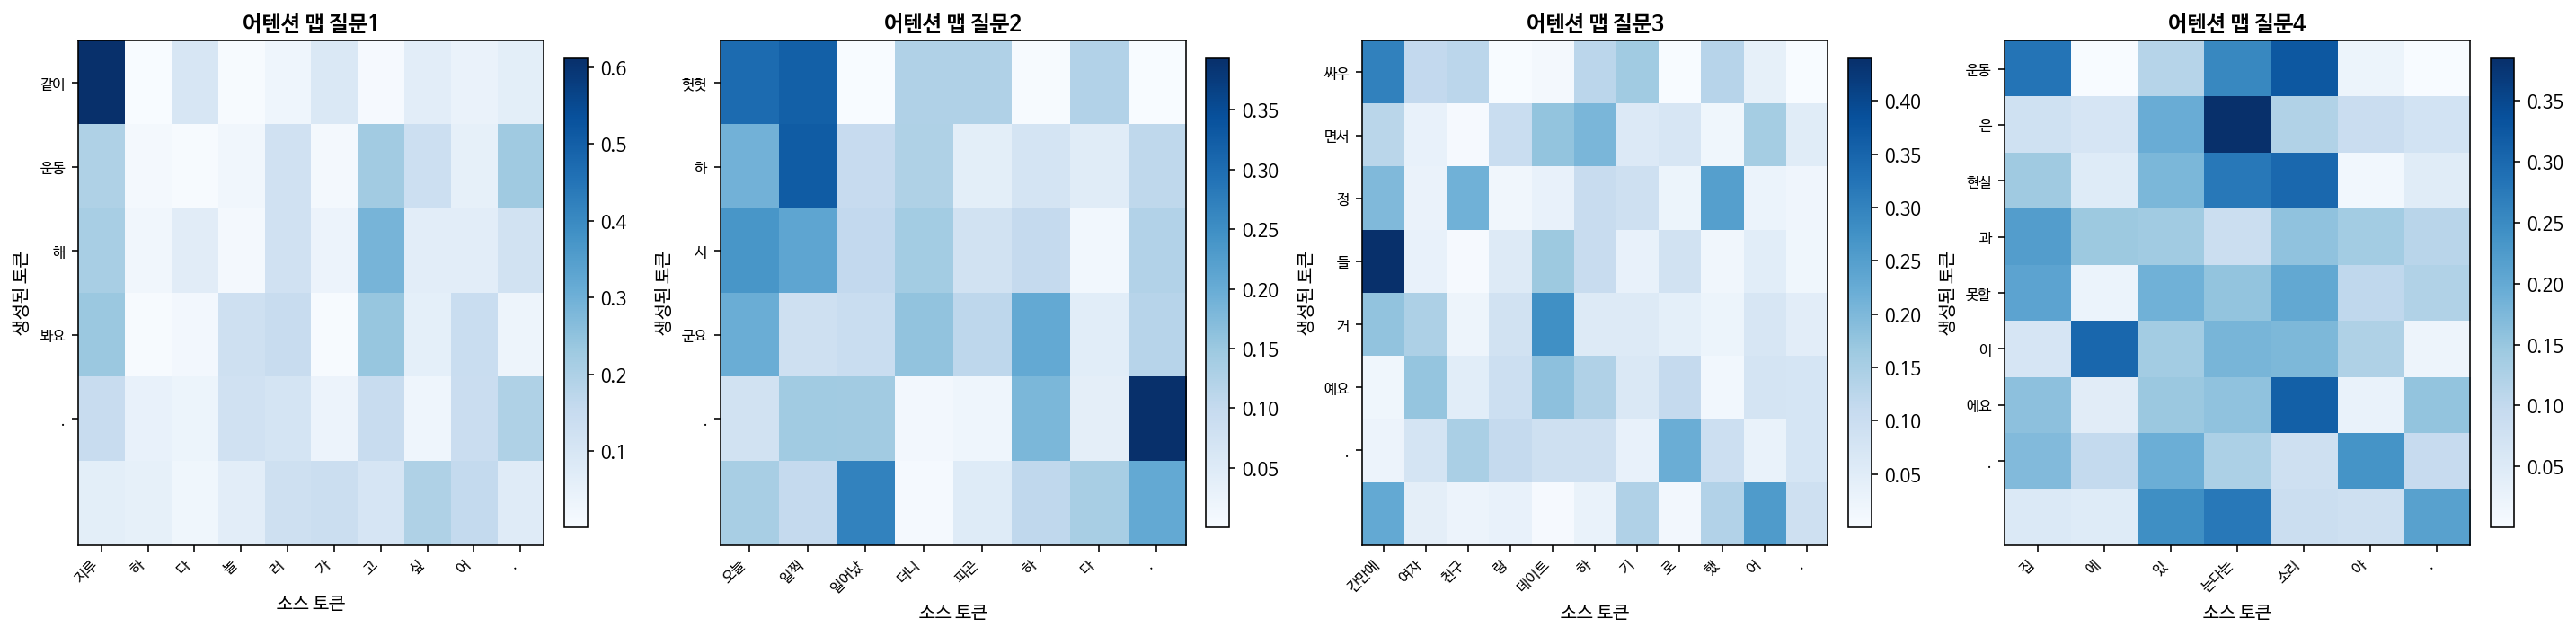

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 8 Train Loss: 0.5950
Epoch 8 Validation Loss: 3.3295
[Epoch 8] BLEU: 0.0408
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 같이 놀 때 가 보 고 싶 네요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 24.52
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 헛헛 하 다고 말 해 봐요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 27.02
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 좋 은 일 만 있 었 나 봐요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 40.83
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 출퇴근 하 기 싫 고 있 고 있 어요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 26.93
----------------------------------------


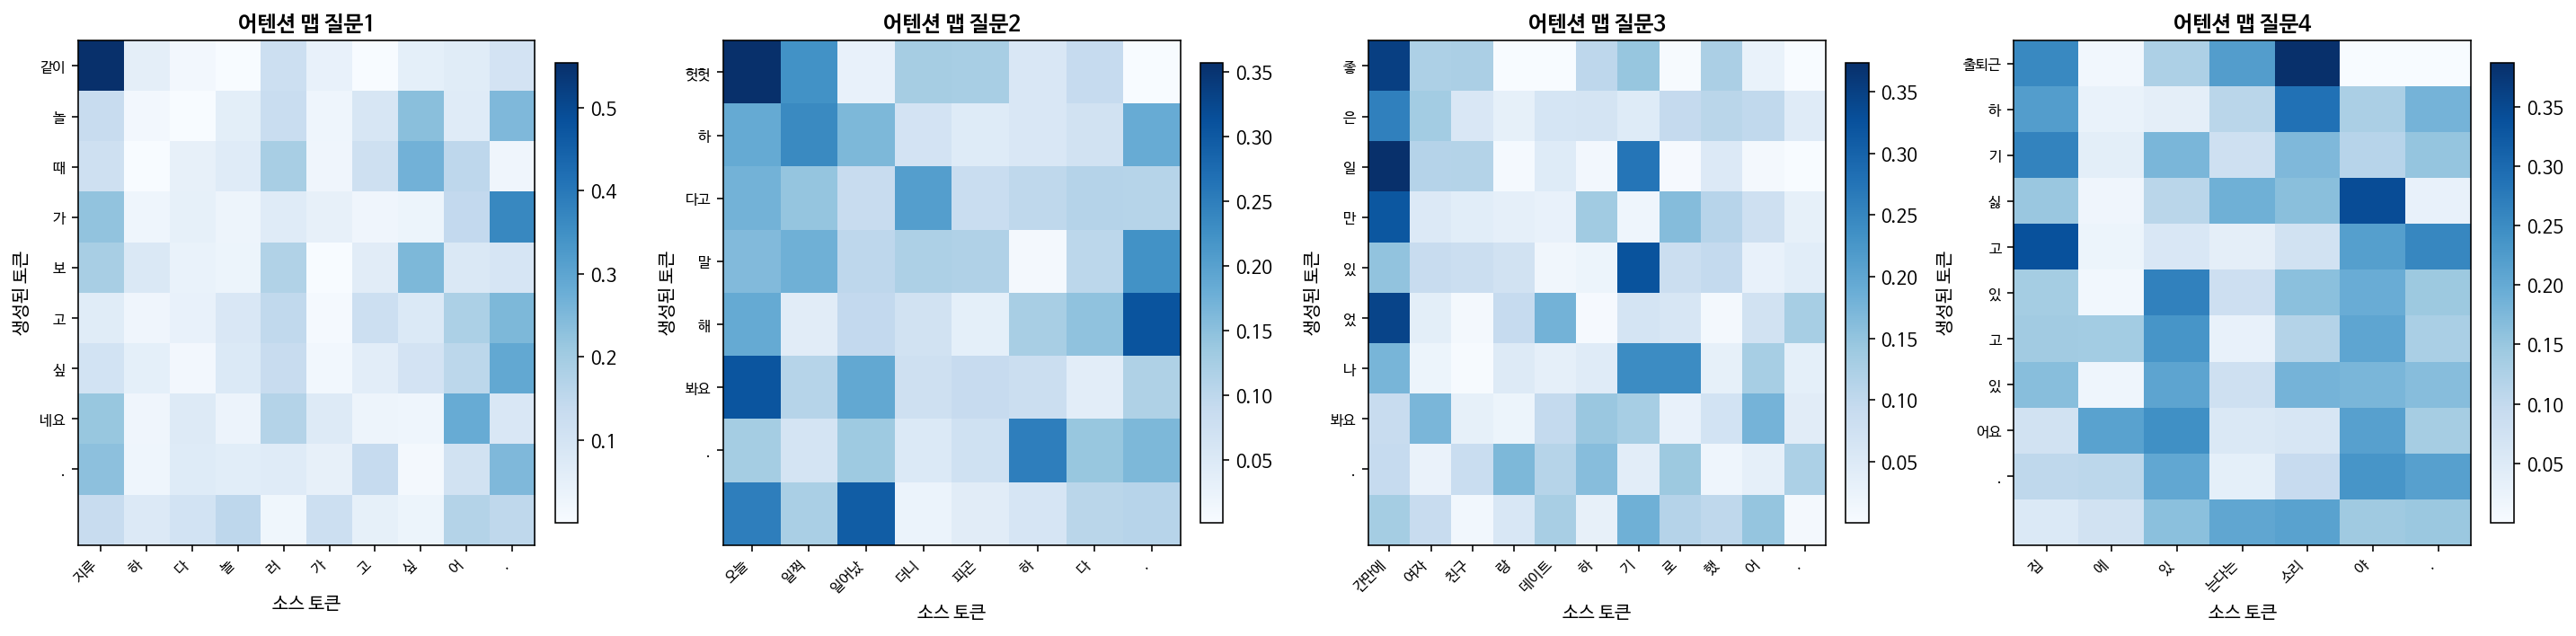

Early stopping triggered at epoch 8


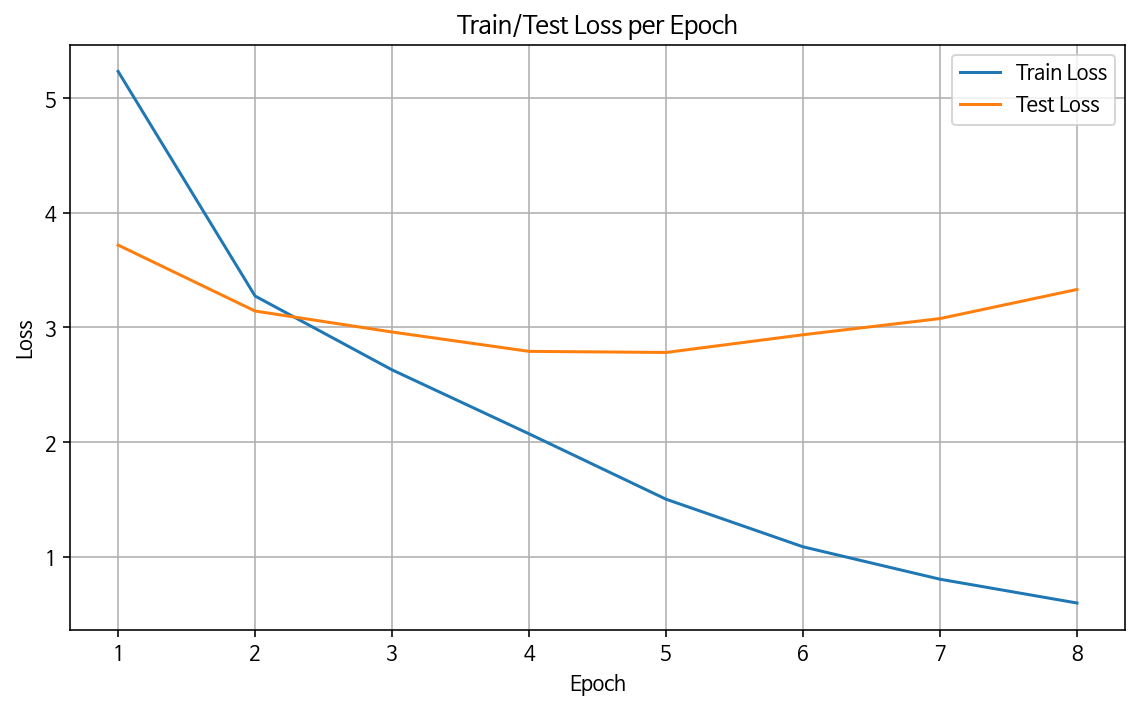

트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 같이 놀 때 가 보 고 싶 네요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 24.52
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 헛헛 하 다고 말 해 봐요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 27.02
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 좋 은 일 만 있 었 나 봐요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 40.83
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 출퇴근 하 기 싫 고 있 고 있 어요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 26.93
----------------------------------------


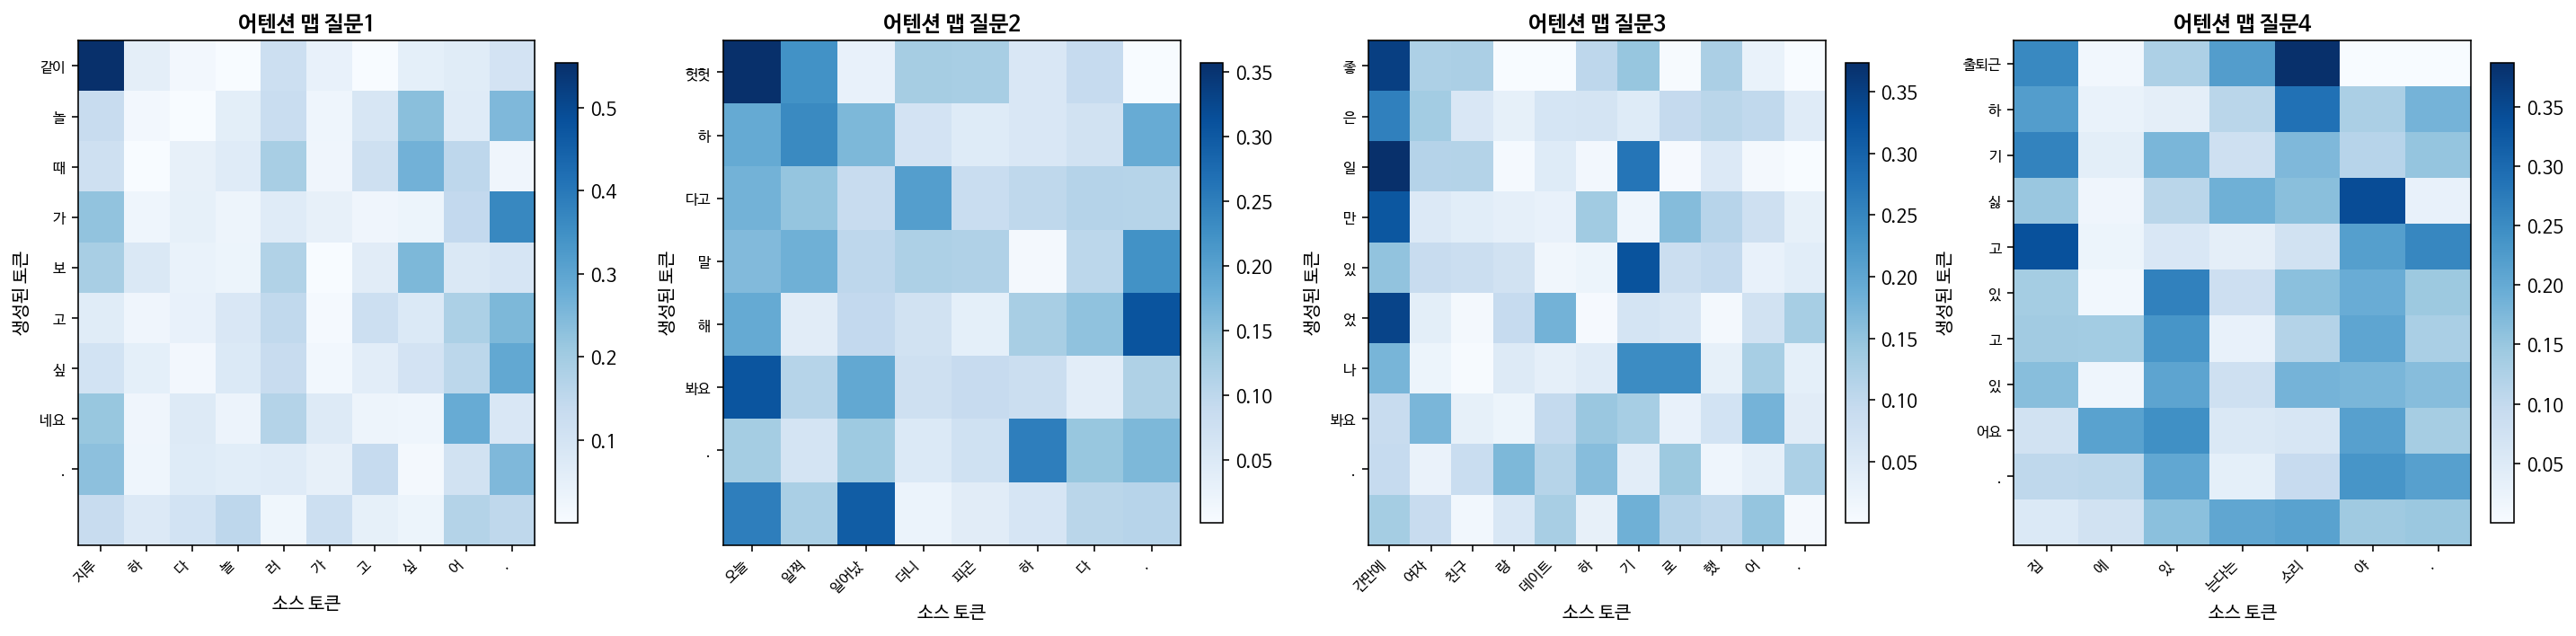

Trial 2/4: {'n_layers': 1, 'd_model': 368, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 1 Train Loss: 4.8390
Epoch 1 Validation Loss: 3.4905
[Epoch 1] BLEU: 0.0000
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 잘 할 수 있 을 거 예요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 41.52
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 잘 지내 고 있 을 거 예요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 51.01
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 더 좋 은 것 같 아요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 26.53
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 잘 지내 고 있 을 거 예요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 35.35
----------------------------------------


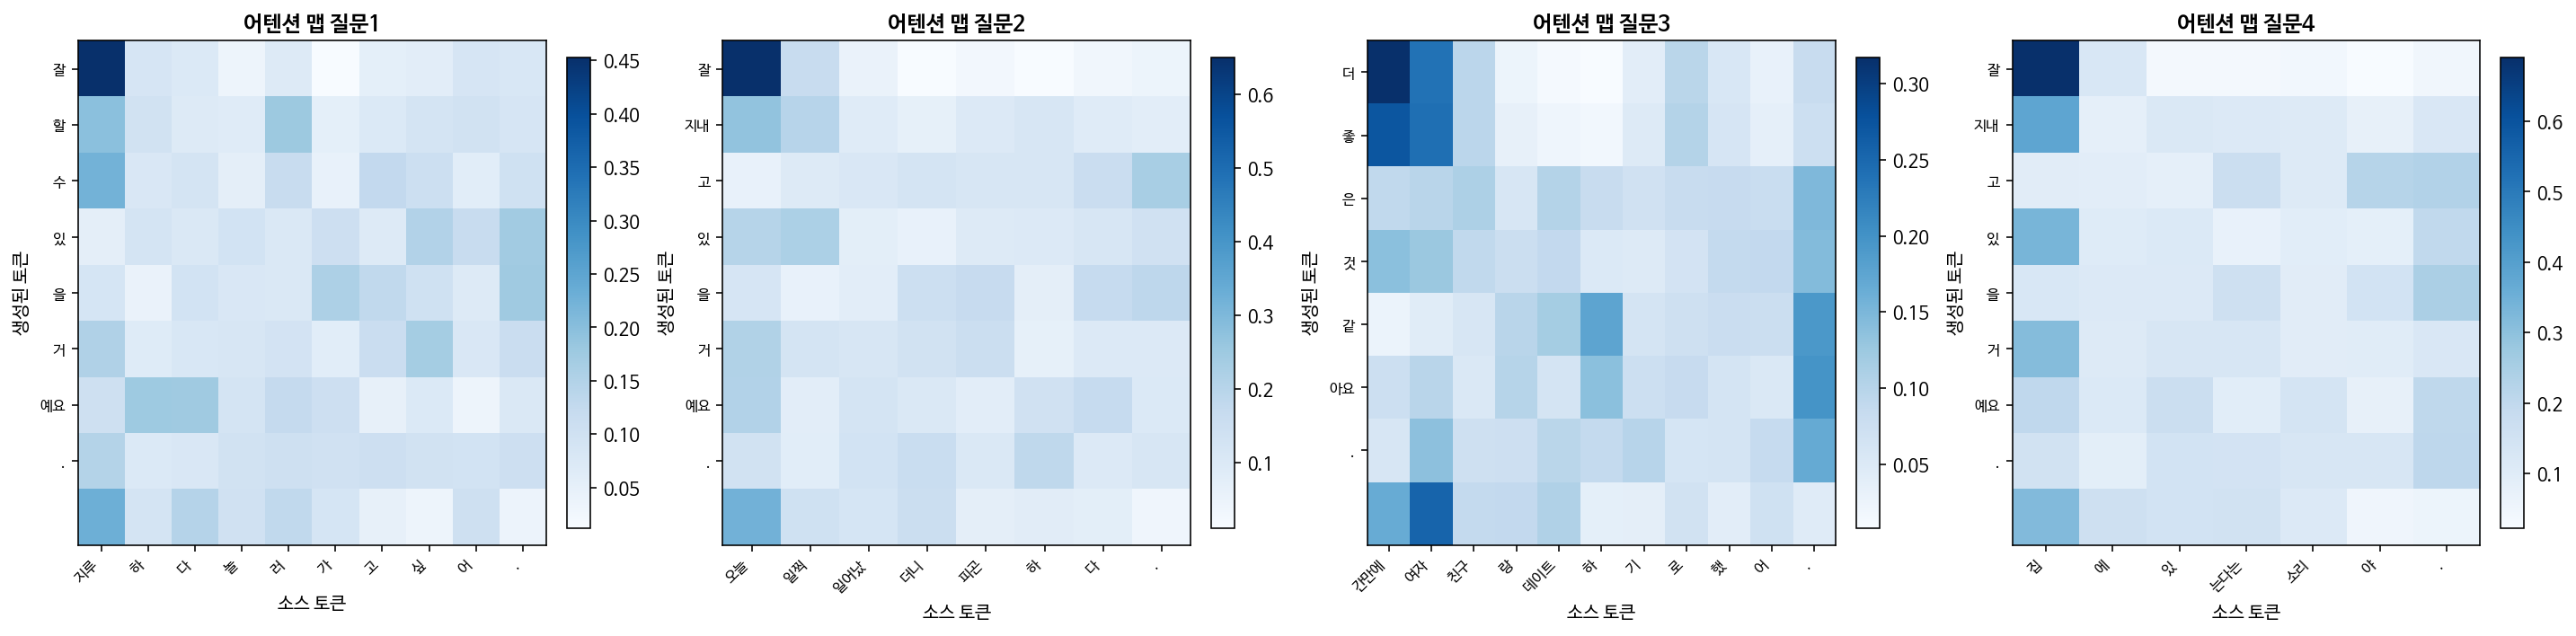

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 2 Train Loss: 2.9628
Epoch 2 Validation Loss: 2.9826
[Epoch 2] BLEU: 0.0928
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 같이 놀 아요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 30.26
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 오늘 일찍 주무세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 12.61
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 같이 가 보 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 19.58
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 마음 이 좀 챙겨 드세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 34.73
----------------------------------------


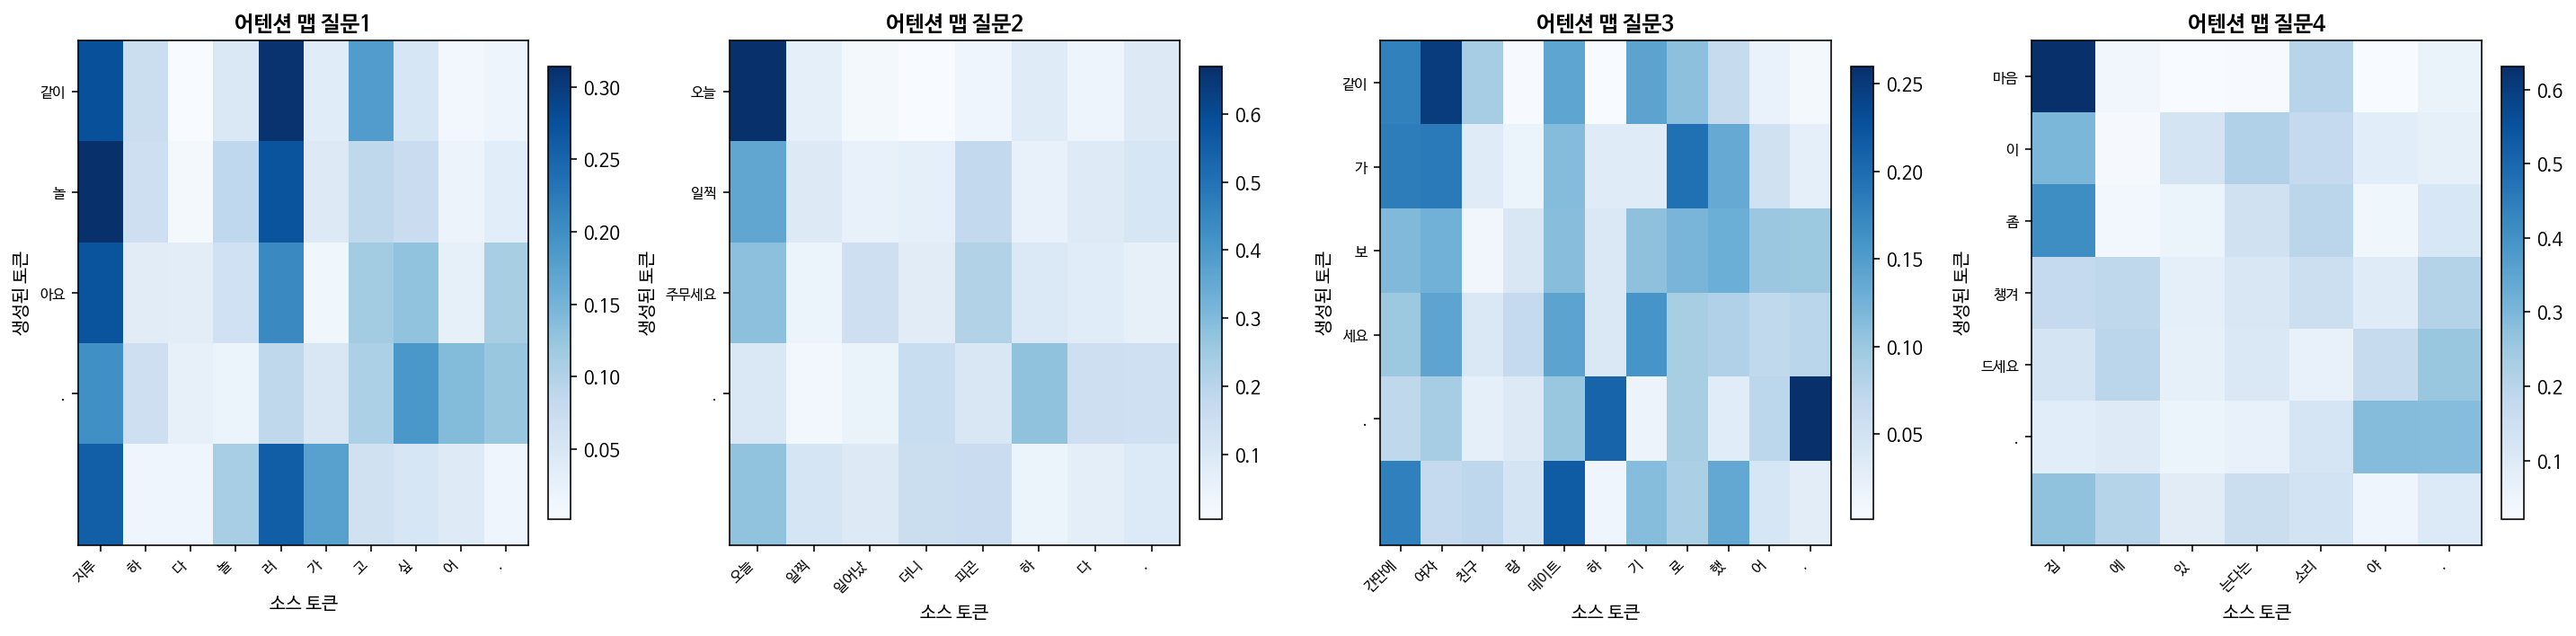

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 3 Train Loss: 2.2739
Epoch 3 Validation Loss: 2.9457
[Epoch 3] BLEU: 0.0000
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 지금 처럼 마음 이 바뀔 거 예요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 27.56
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 오늘 은 살쪄 도 있 어요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 34.00
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 같이 가 보 는 게 좋 을 거 같 아요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 32.08
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 조심히 오 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 37.28
----------------------------------------


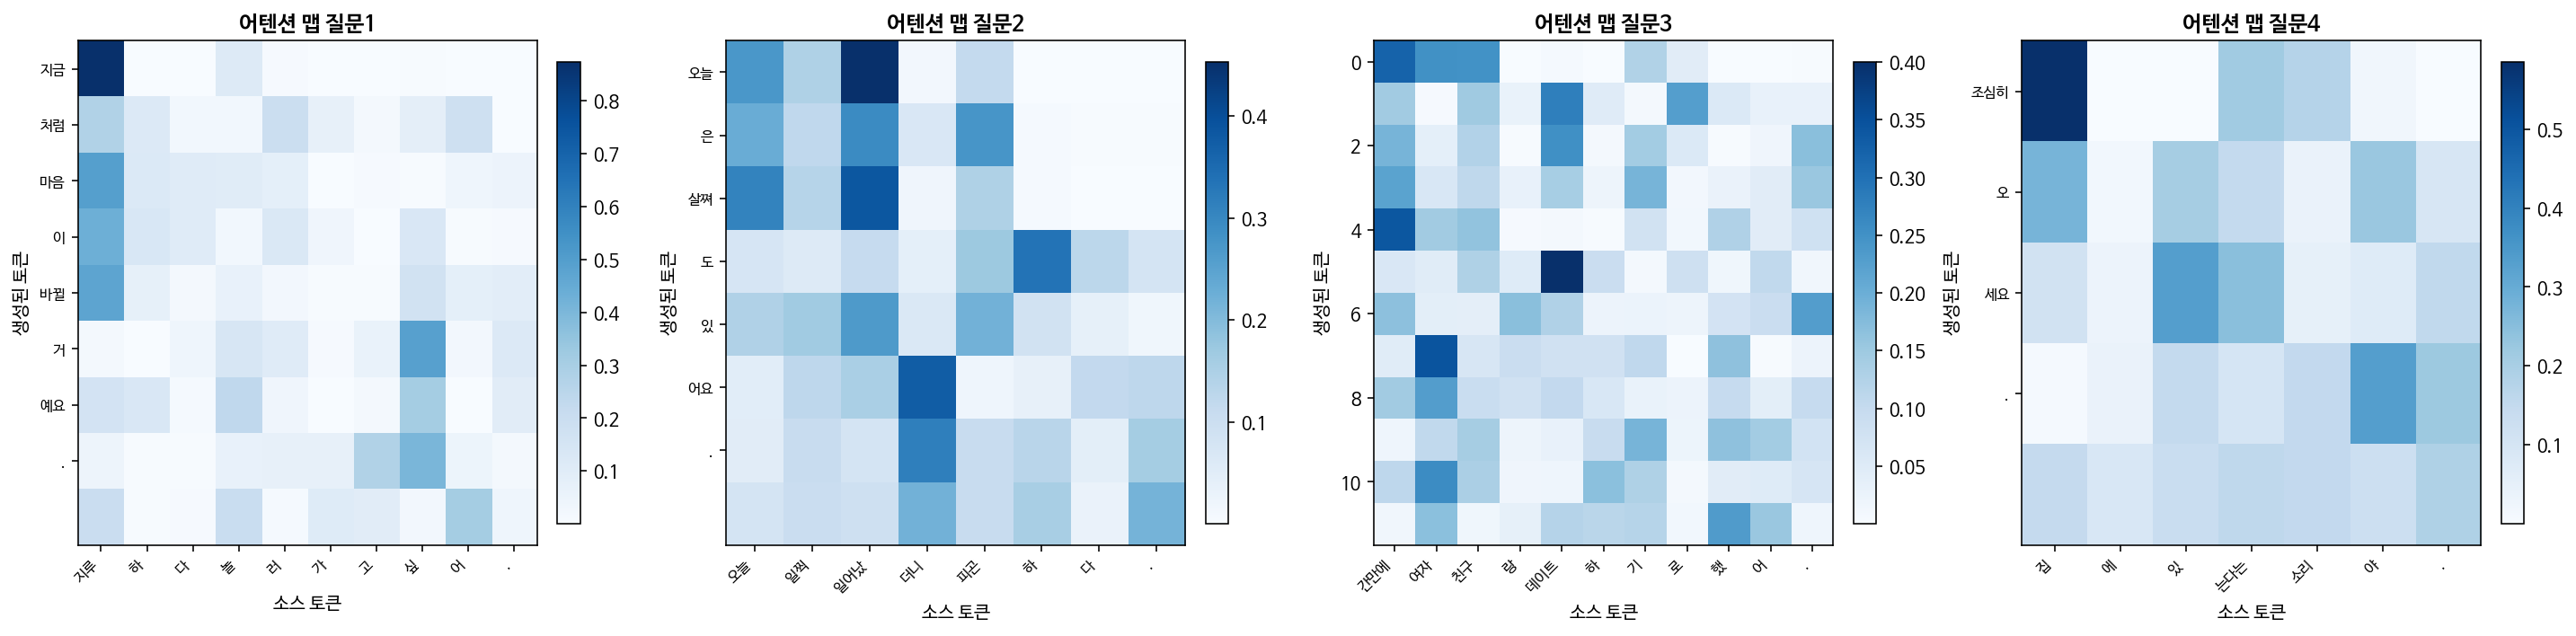

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 4 Train Loss: 1.8208
Epoch 4 Validation Loss: 2.8055
[Epoch 4] BLEU: 0.0000
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 저 랑 같이 가요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 32.83
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 사춘기 인가 봅니다 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 29.88
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 그 사람 도 당신 을 좋아하 는지 깊 게 만들 어요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 35.32
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 내 집 에 는 들어줄 거 예요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 36.71
----------------------------------------


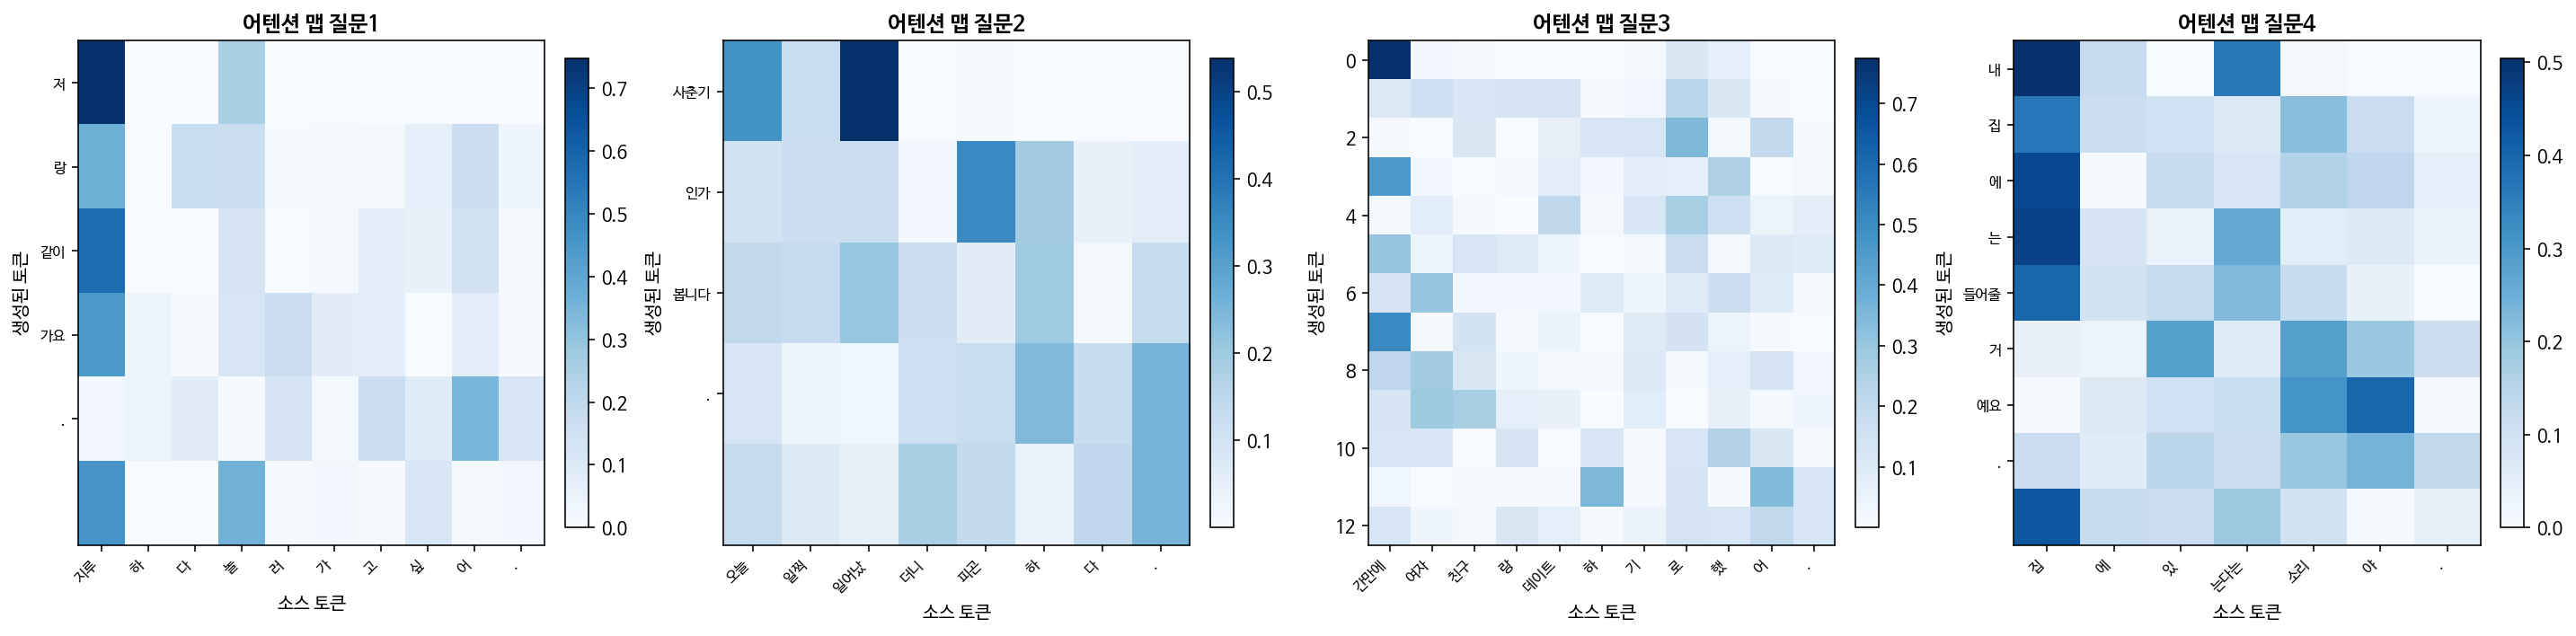

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 5 Train Loss: 1.2848
Epoch 5 Validation Loss: 2.8466
[Epoch 5] BLEU: 0.0000
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 마음 에 따라 얼마 든지 바뀔 수 있 어요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 41.60
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 좋 은 도구 죠 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 63.61
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 이번 엔 당황 해서 놀 러 가 될 거 예요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 49.83
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 내 가 원 하 는 것 보다 좋 은 방법 이 에요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 29.52
----------------------------------------


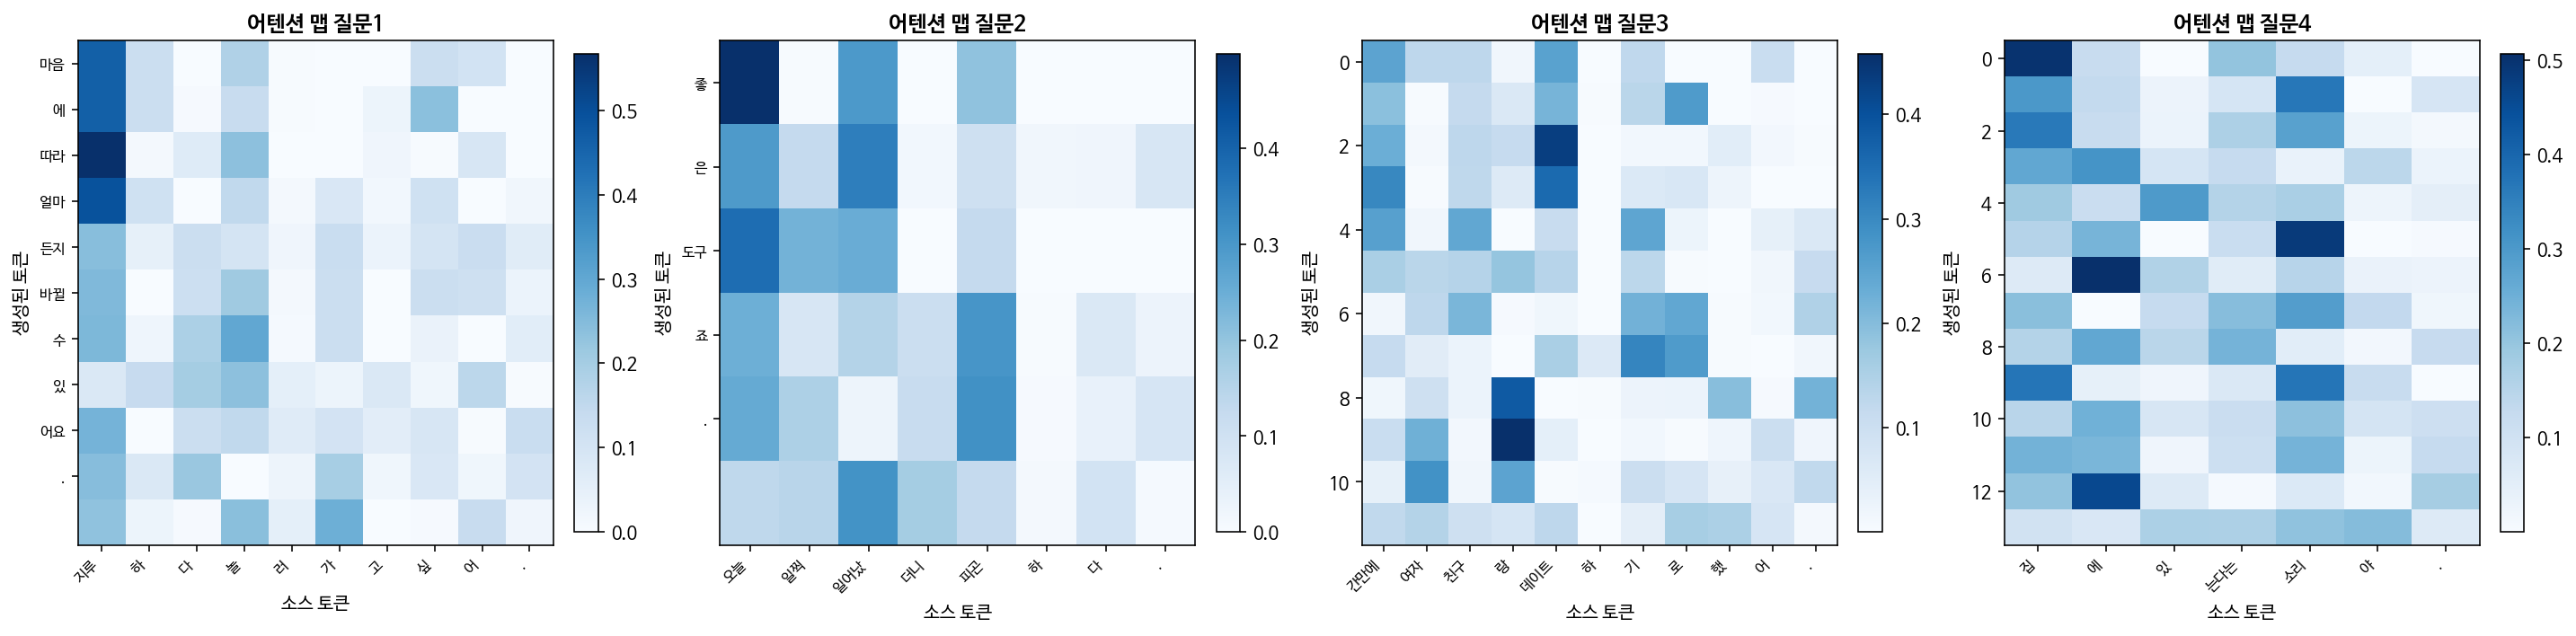

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 6 Train Loss: 0.9253
Epoch 6 Validation Loss: 3.0142
[Epoch 6] BLEU: 0.0207
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 저 랑 놀 아요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 55.06
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 눈 에서 멀 어 가 죠 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 65.27
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 좋 은 곳 에서 일 거 예요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 45.48
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 항상 아쉽 지요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 35.91
----------------------------------------


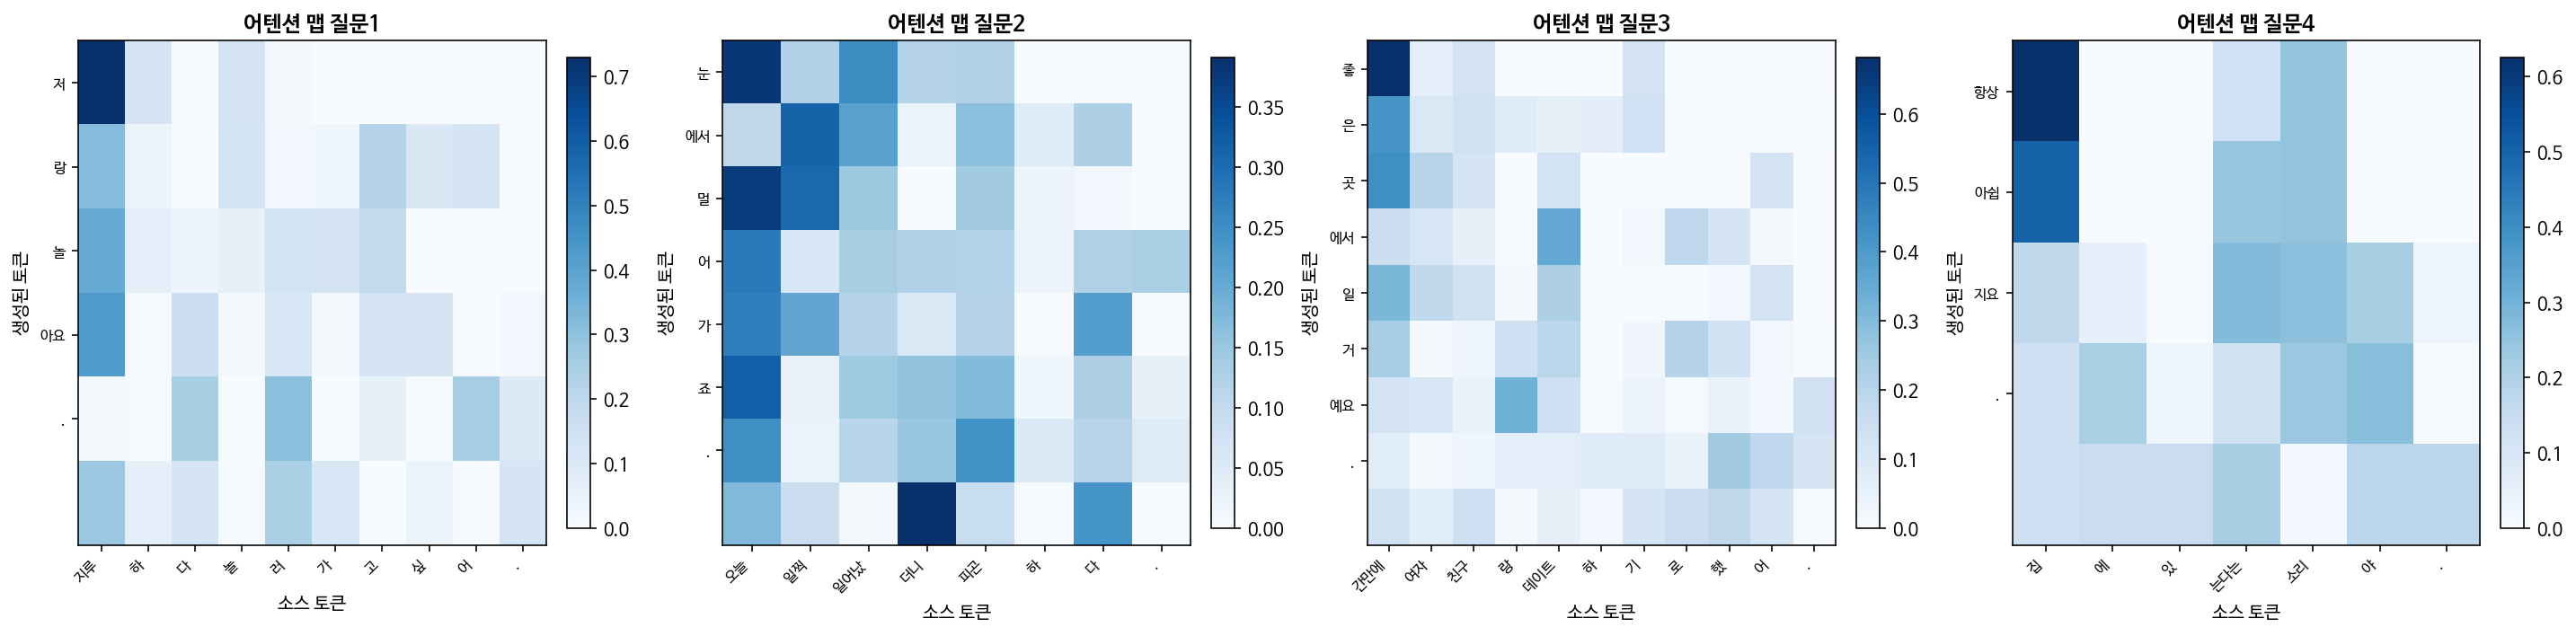

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.6956
Epoch 7 Validation Loss: 3.1804
[Epoch 7] BLEU: 0.0982
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 마음 과 걱정 을 덜 하 면 돼요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 61.12
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 요즘 많이 피곤 했 나 봐요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 26.82
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 그 분 생각 해 보 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 26.51
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 좋 은 일 해요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 75.65
----------------------------------------


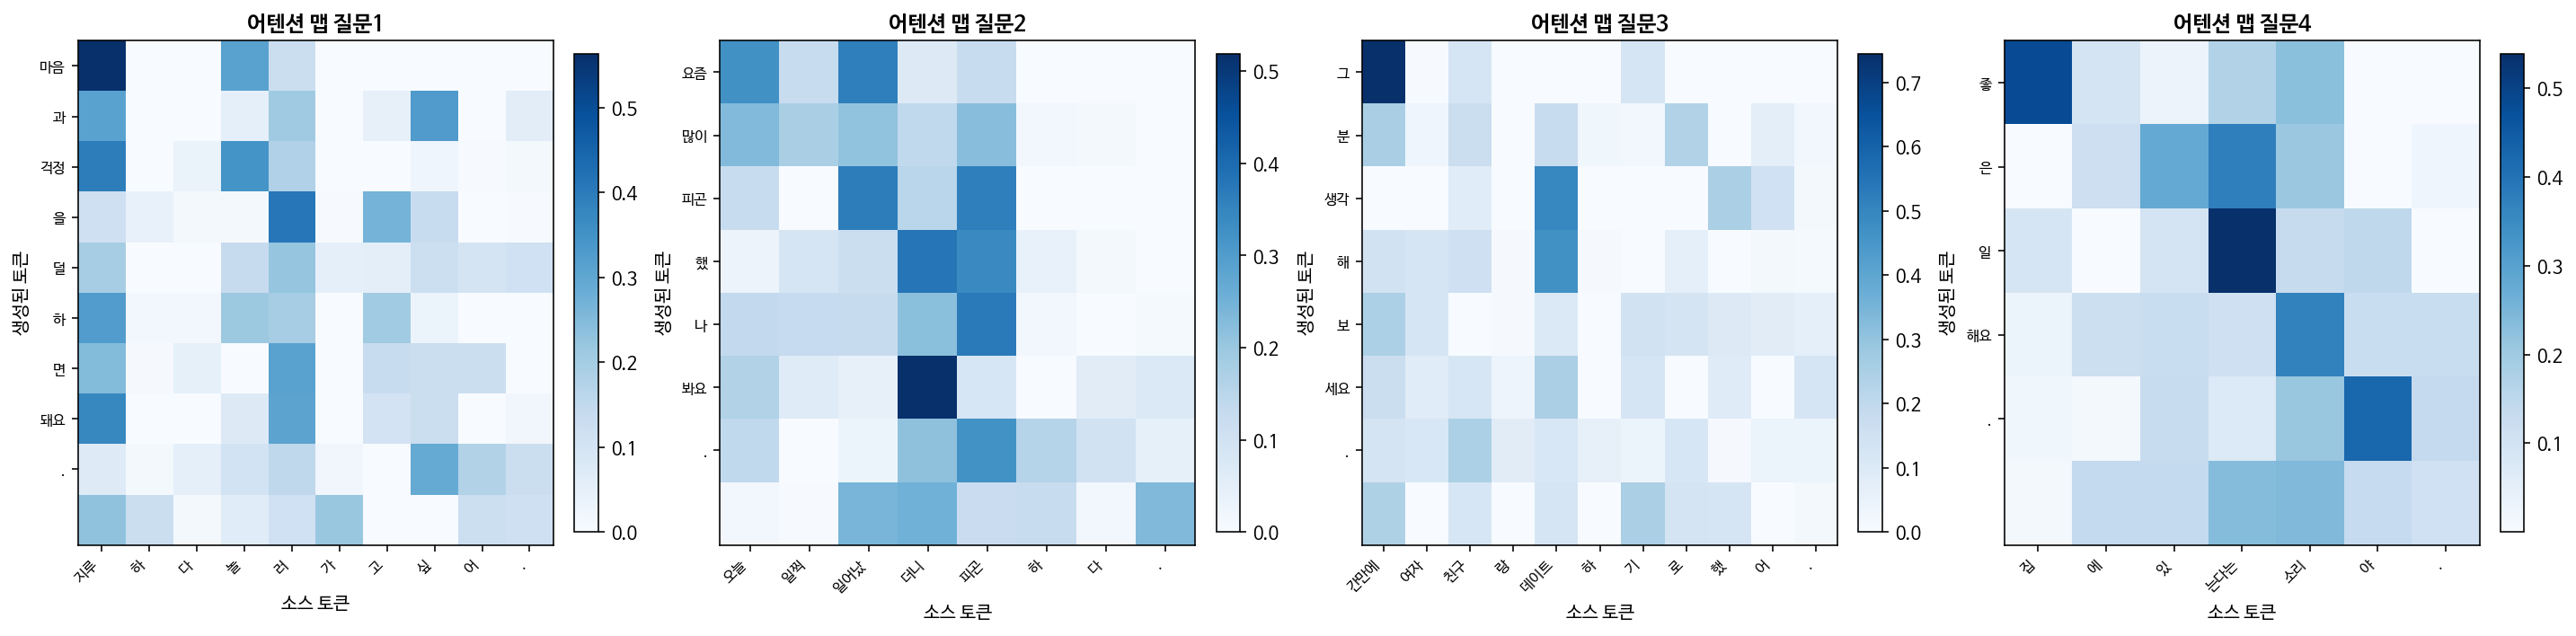

Early stopping triggered at epoch 7


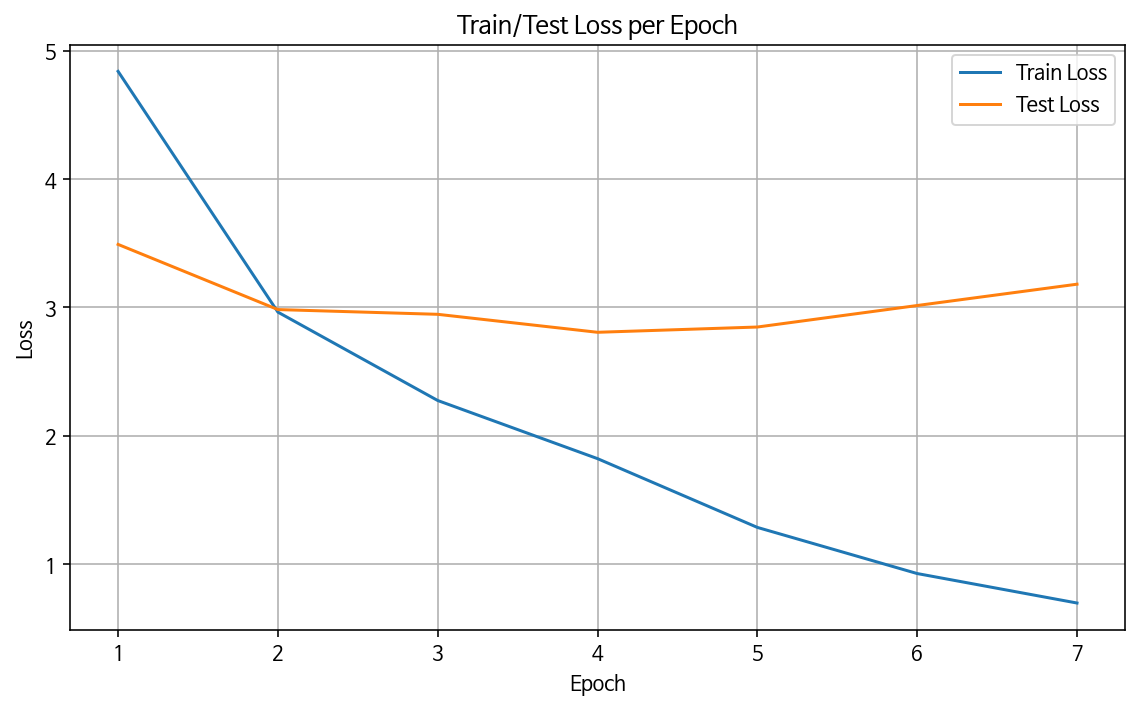

트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 마음 과 걱정 을 덜 하 면 돼요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 61.12
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 요즘 많이 피곤 했 나 봐요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 26.82
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 그 분 생각 해 보 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 26.51
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 좋 은 일 해요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 75.65
----------------------------------------


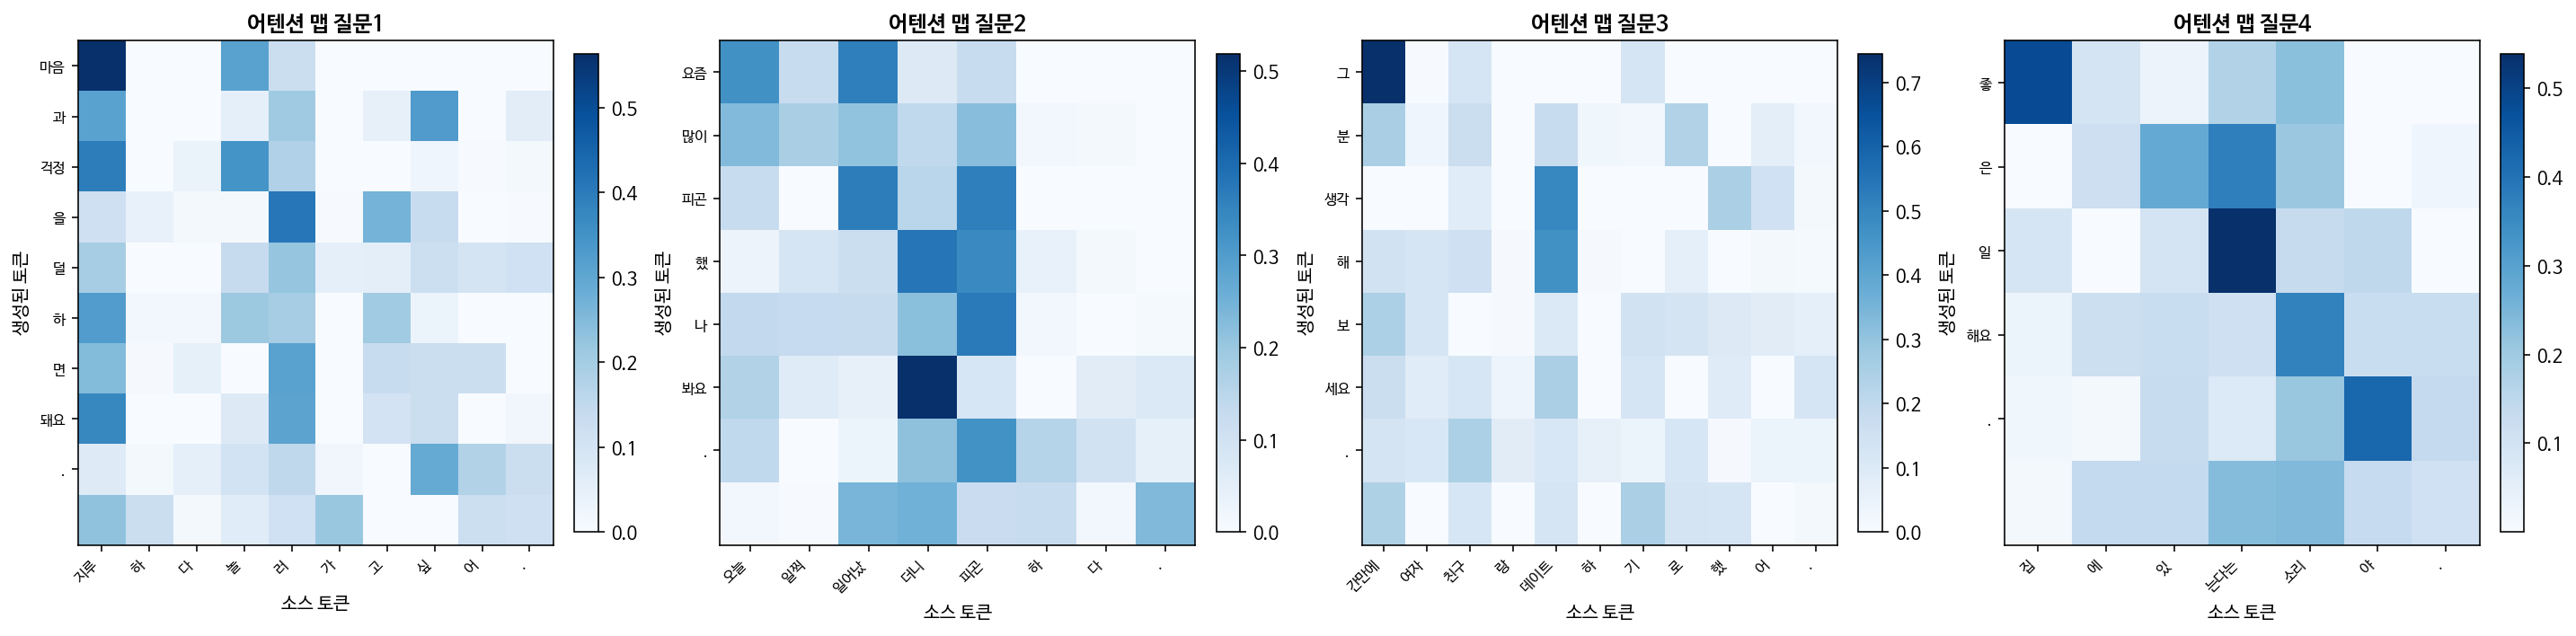

Trial 3/4: {'n_layers': 2, 'd_model': 128, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 1 Train Loss: 5.1158
Epoch 1 Validation Loss: 3.7342
[Epoch 1] BLEU: 0.0105
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 좋 은 사람 이 있 어요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 57.01
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 마음 이 많 은 사람 이 에요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 48.66
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 좋 은 사람 이 있 어요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 46.91
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 좋 은 사람 이 네요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 81.80
----------------------------------------


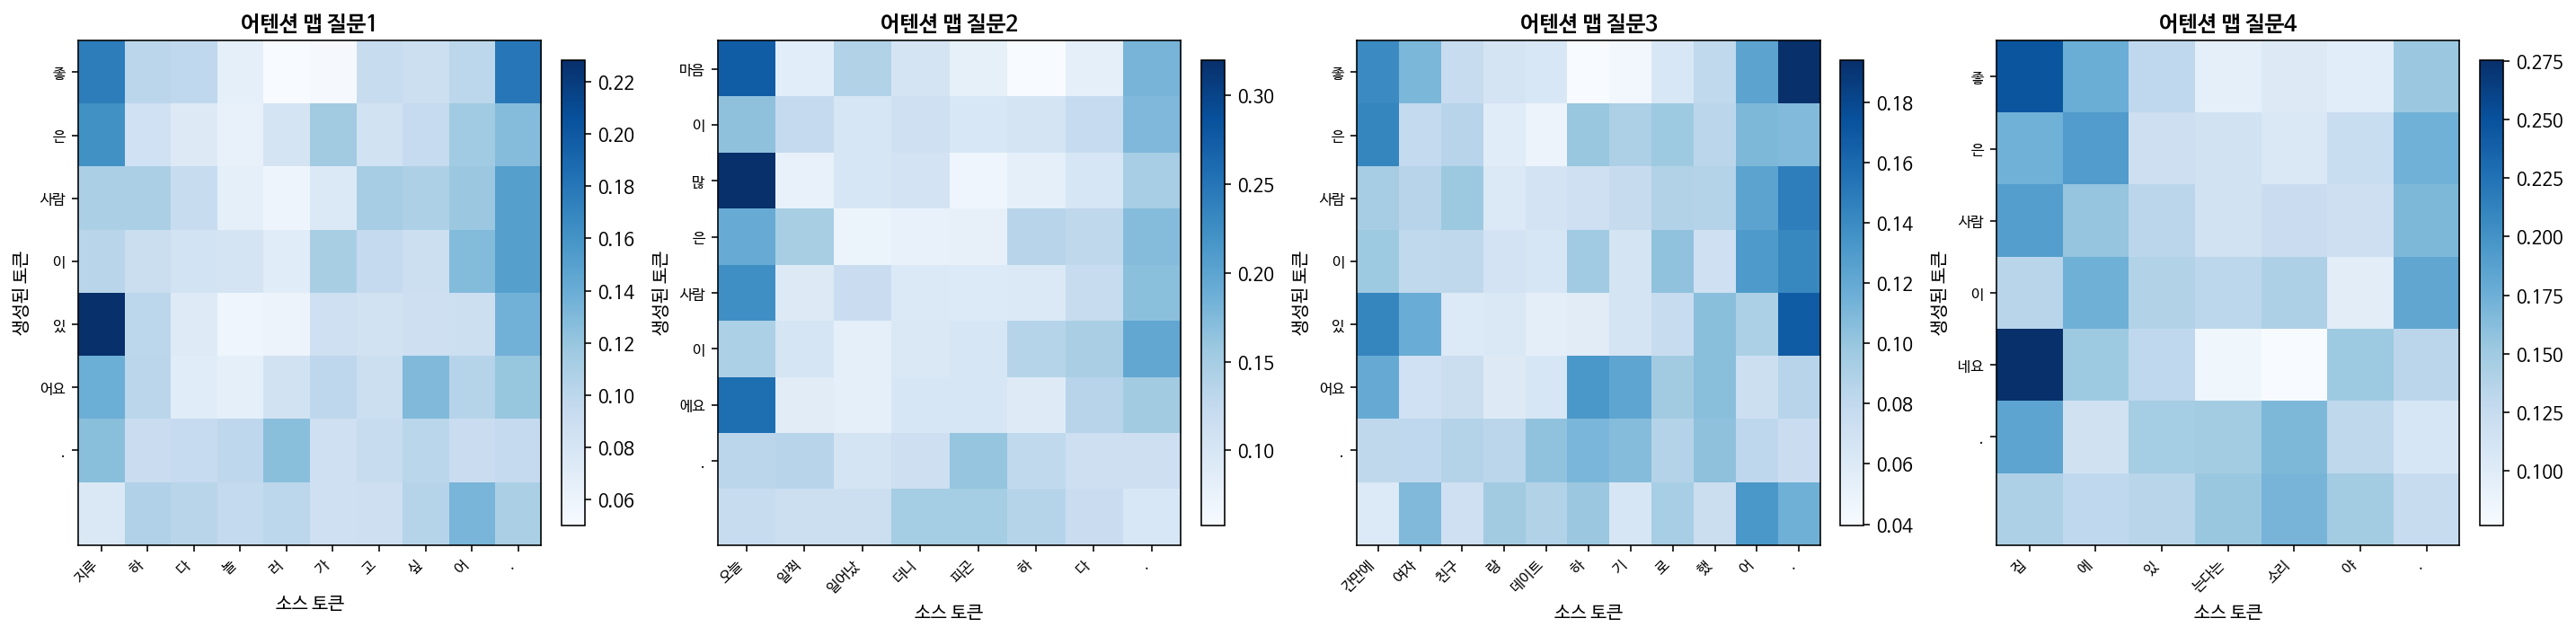

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 2 Train Loss: 3.2790
Epoch 2 Validation Loss: 3.2260
[Epoch 2] BLEU: 0.0000
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 좋 은 선택 이 에요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 60.92
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 조금 씩 더 일찍 주무세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 45.77
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 좋 은 선택 을 거 예요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 38.91
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 좋 은 선택 을 거 예요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 51.84
----------------------------------------


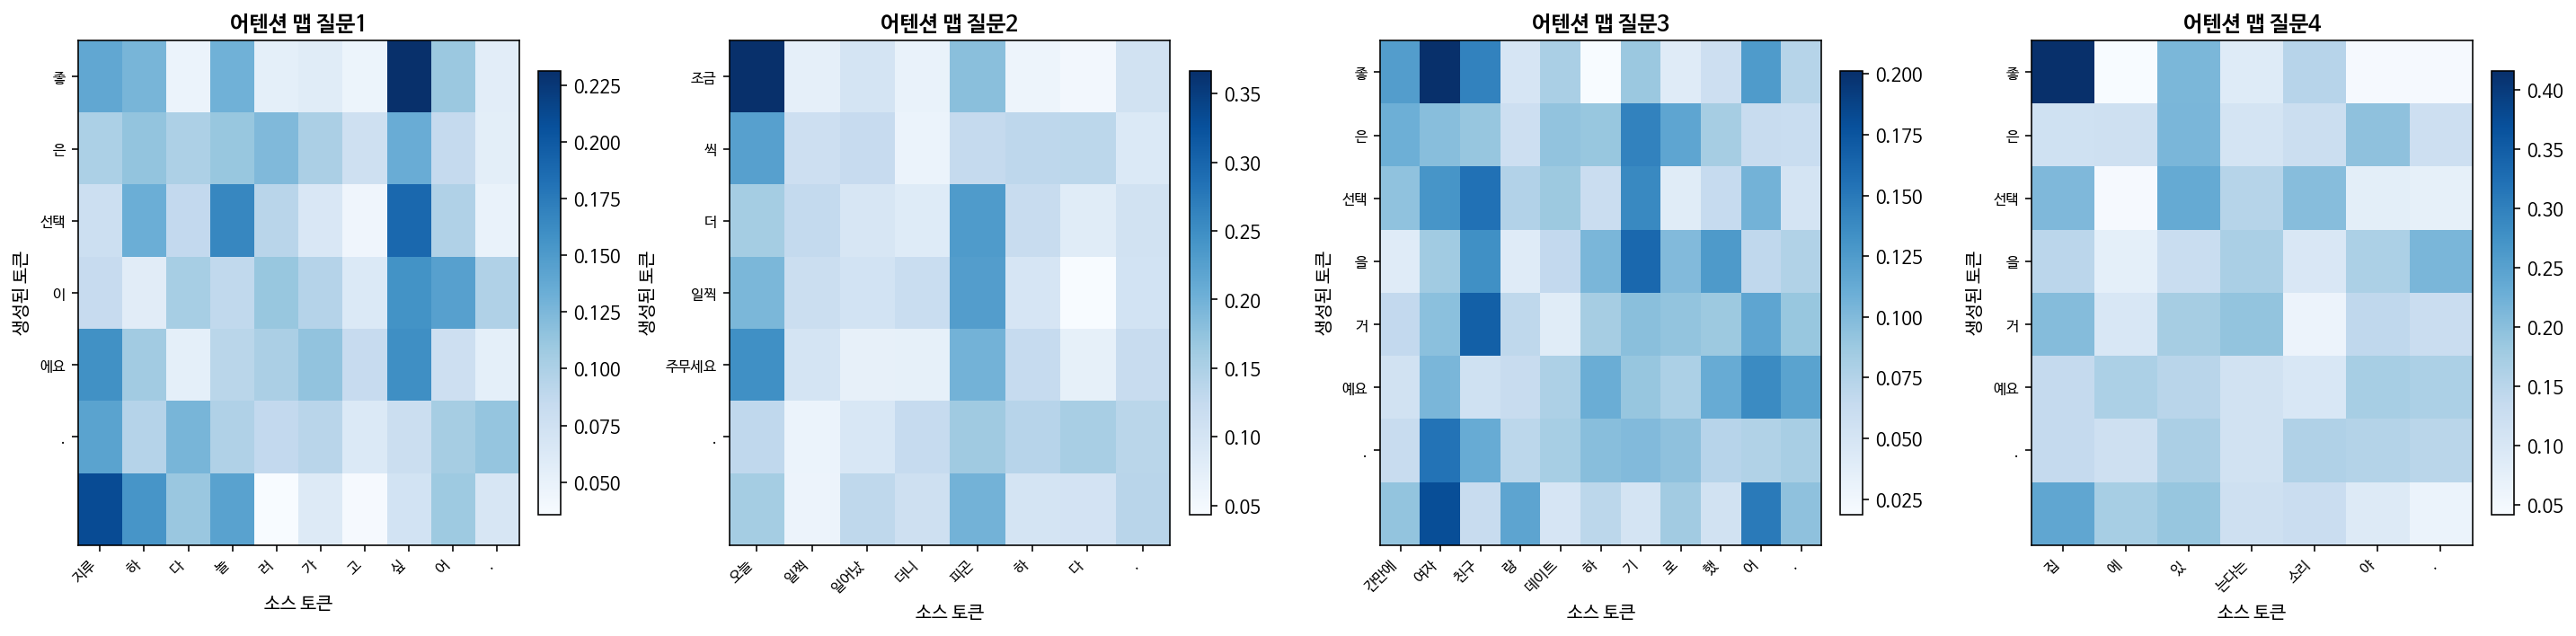

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 3 Train Loss: 2.6811
Epoch 3 Validation Loss: 3.0122
[Epoch 3] BLEU: 0.0545
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 저 는 마음 이 라도 쉬 는 게 아니 에요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 62.64
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 저 는 노래 도 좋 아요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 59.25
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 좋 은 소식 이 네요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 46.72
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 혼자 만 의 시간 이 필요 하 겠 네요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 26.59
----------------------------------------


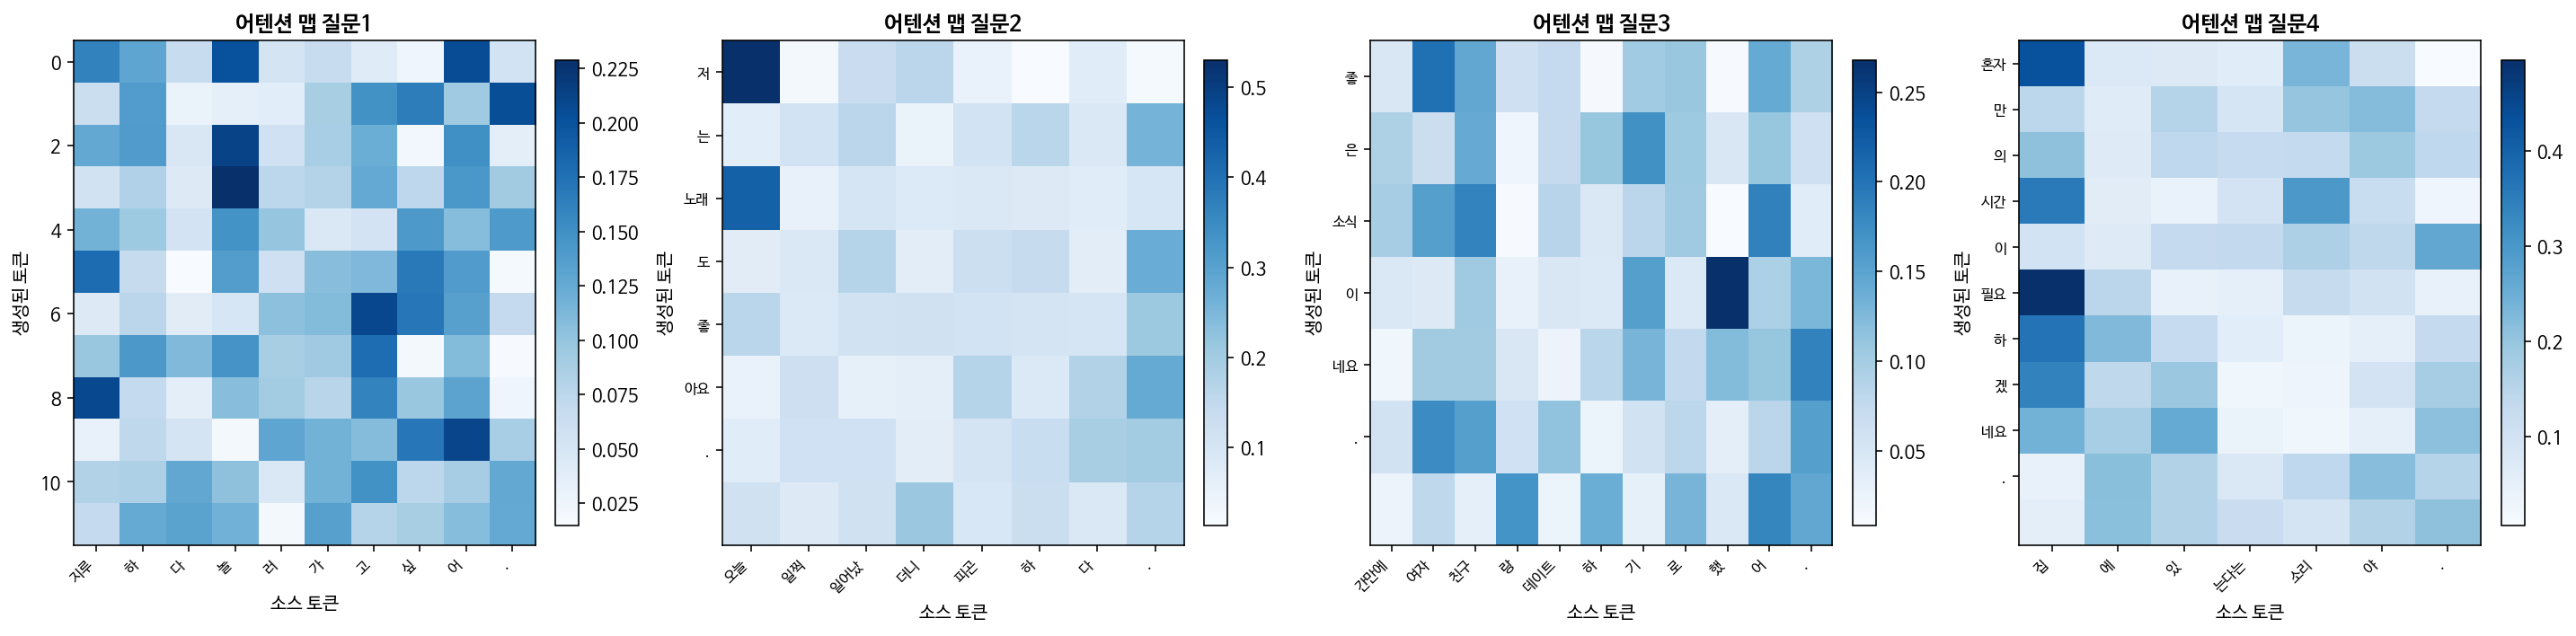

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.1551
Epoch 4 Validation Loss: 2.8698
[Epoch 4] BLEU: 0.0000
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 저 도 데려가 주 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 39.81
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 추억 이 되 기 도 하 죠 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 50.53
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 같이 가 요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 25.77
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 같이 가 요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 15.73
----------------------------------------


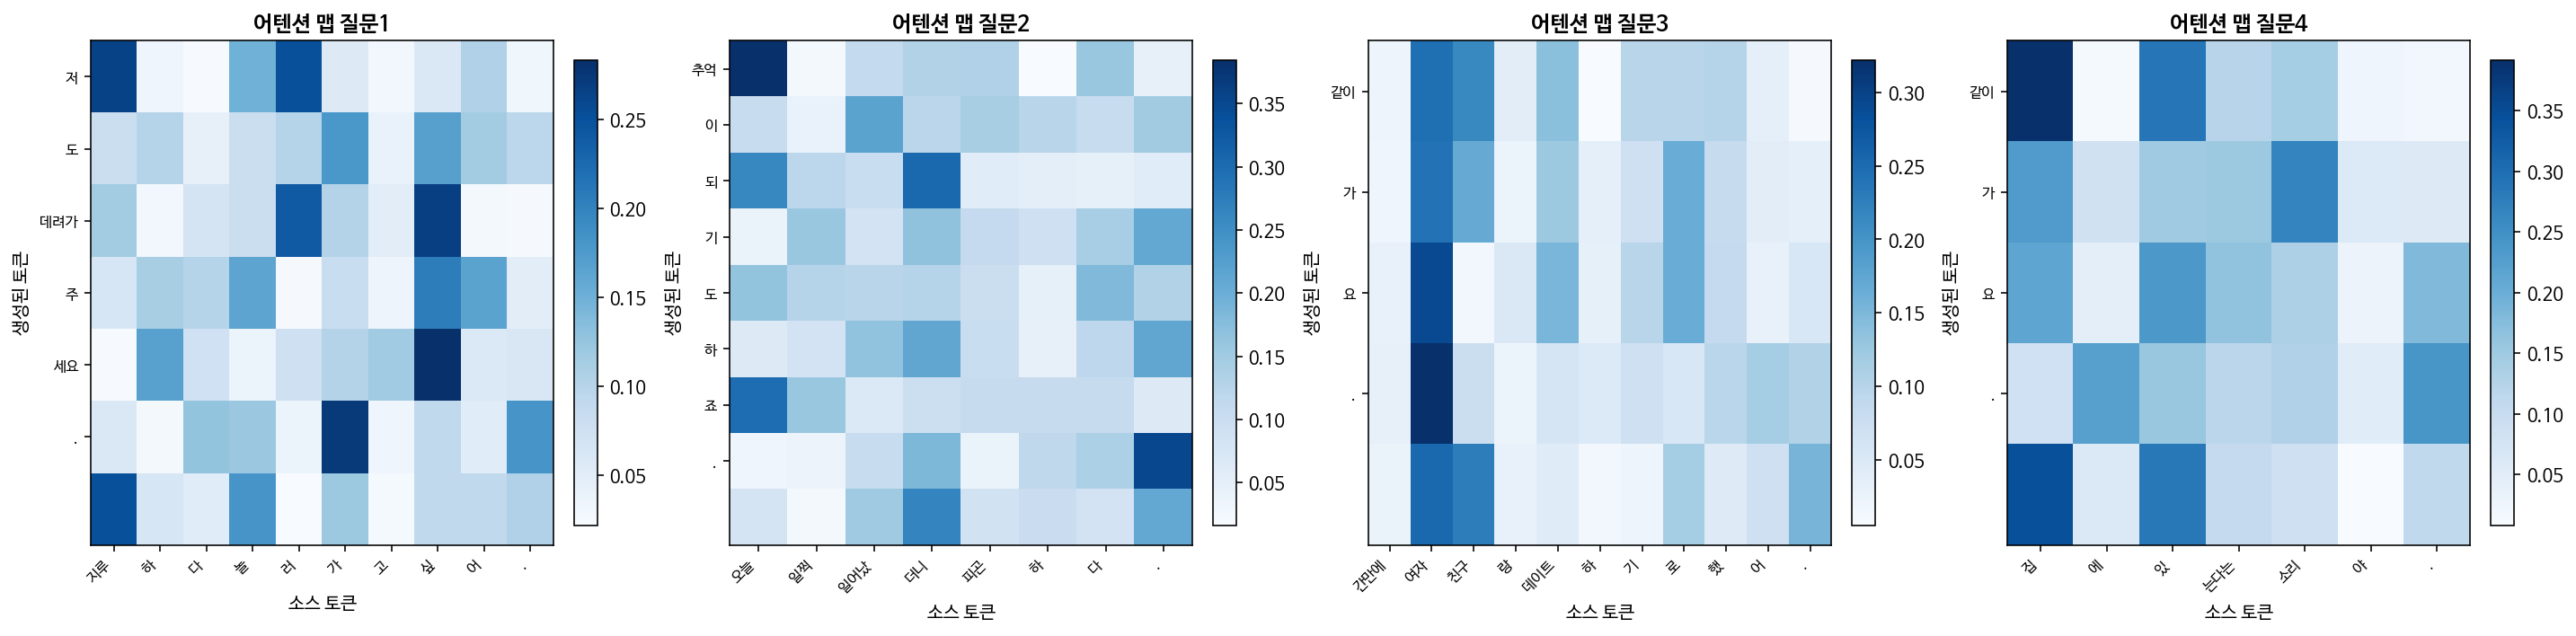

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 5 Train Loss: 1.5751
Epoch 5 Validation Loss: 2.7917
[Epoch 5] BLEU: 0.0733
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 저 도 같이 놀 러 가 서 놀 러 가 서 놀 아요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 28.92
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 저 에게 기대 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 27.91
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 다른 곳 에 가 보 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 41.42
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 사랑 은 사람 이 라면 문제 네요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 38.73
----------------------------------------


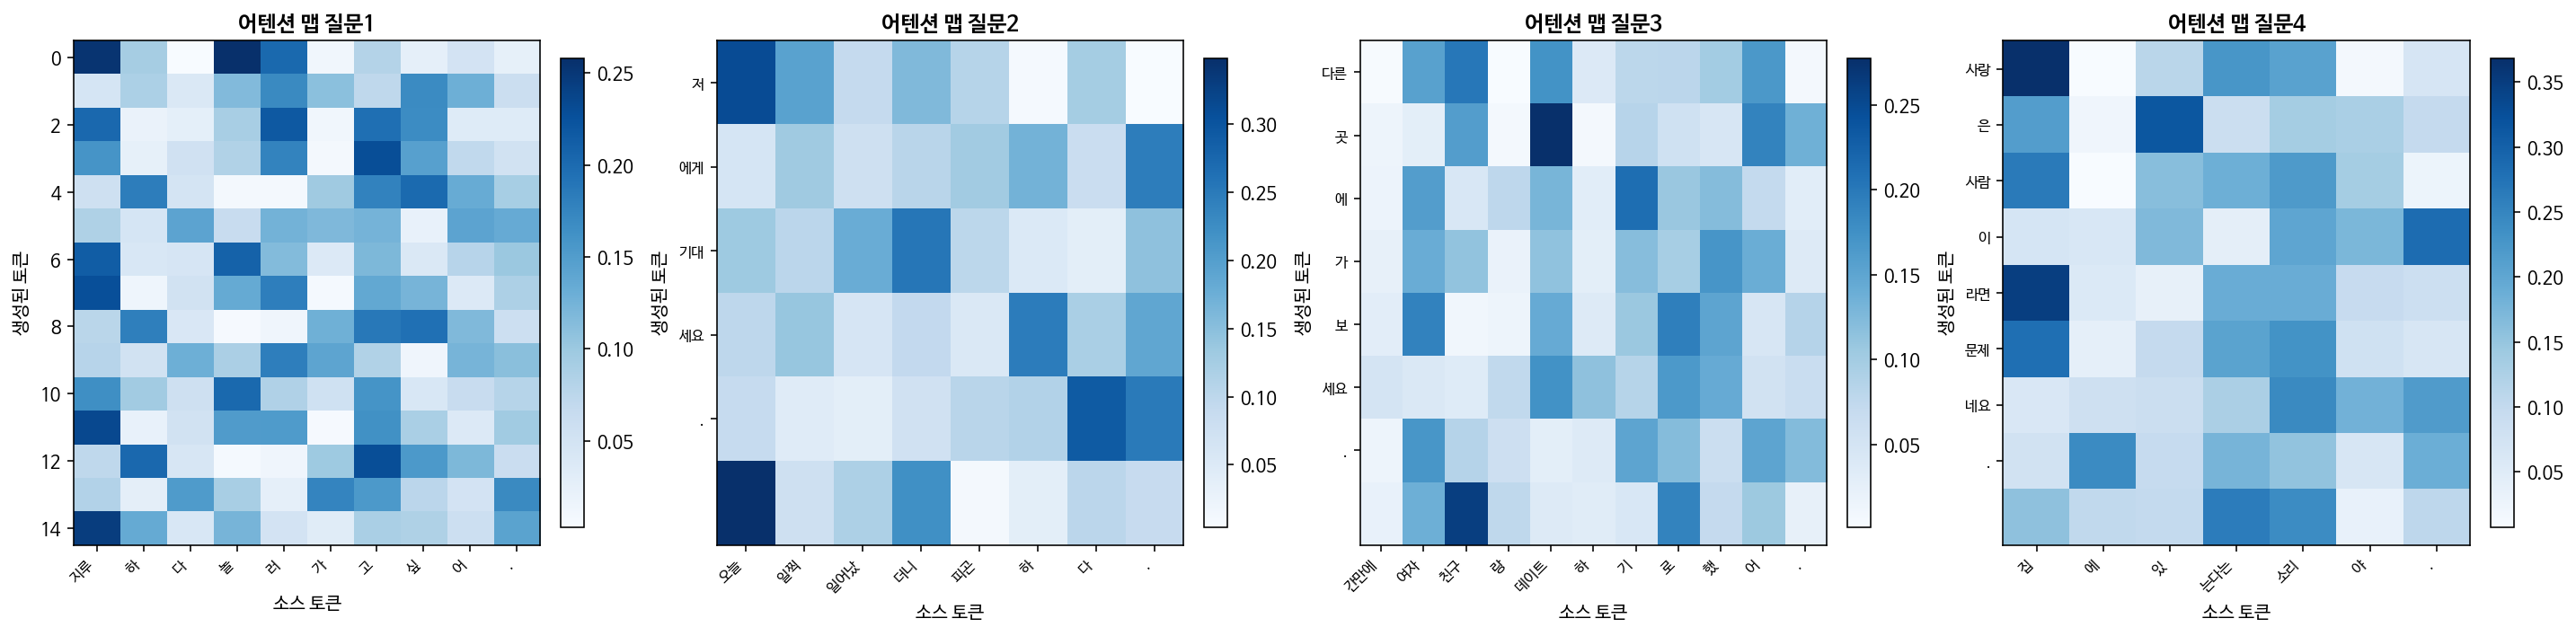

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.1255
Epoch 6 Validation Loss: 2.9624
[Epoch 6] BLEU: 0.0463
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 가 될 수 있 어요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 28.39
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 오늘 은 쉬 는 게 좋 죠 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 52.12
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 그런 사람 들 은근 많 아요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 53.72
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 그럴 만 해요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 17.11
----------------------------------------


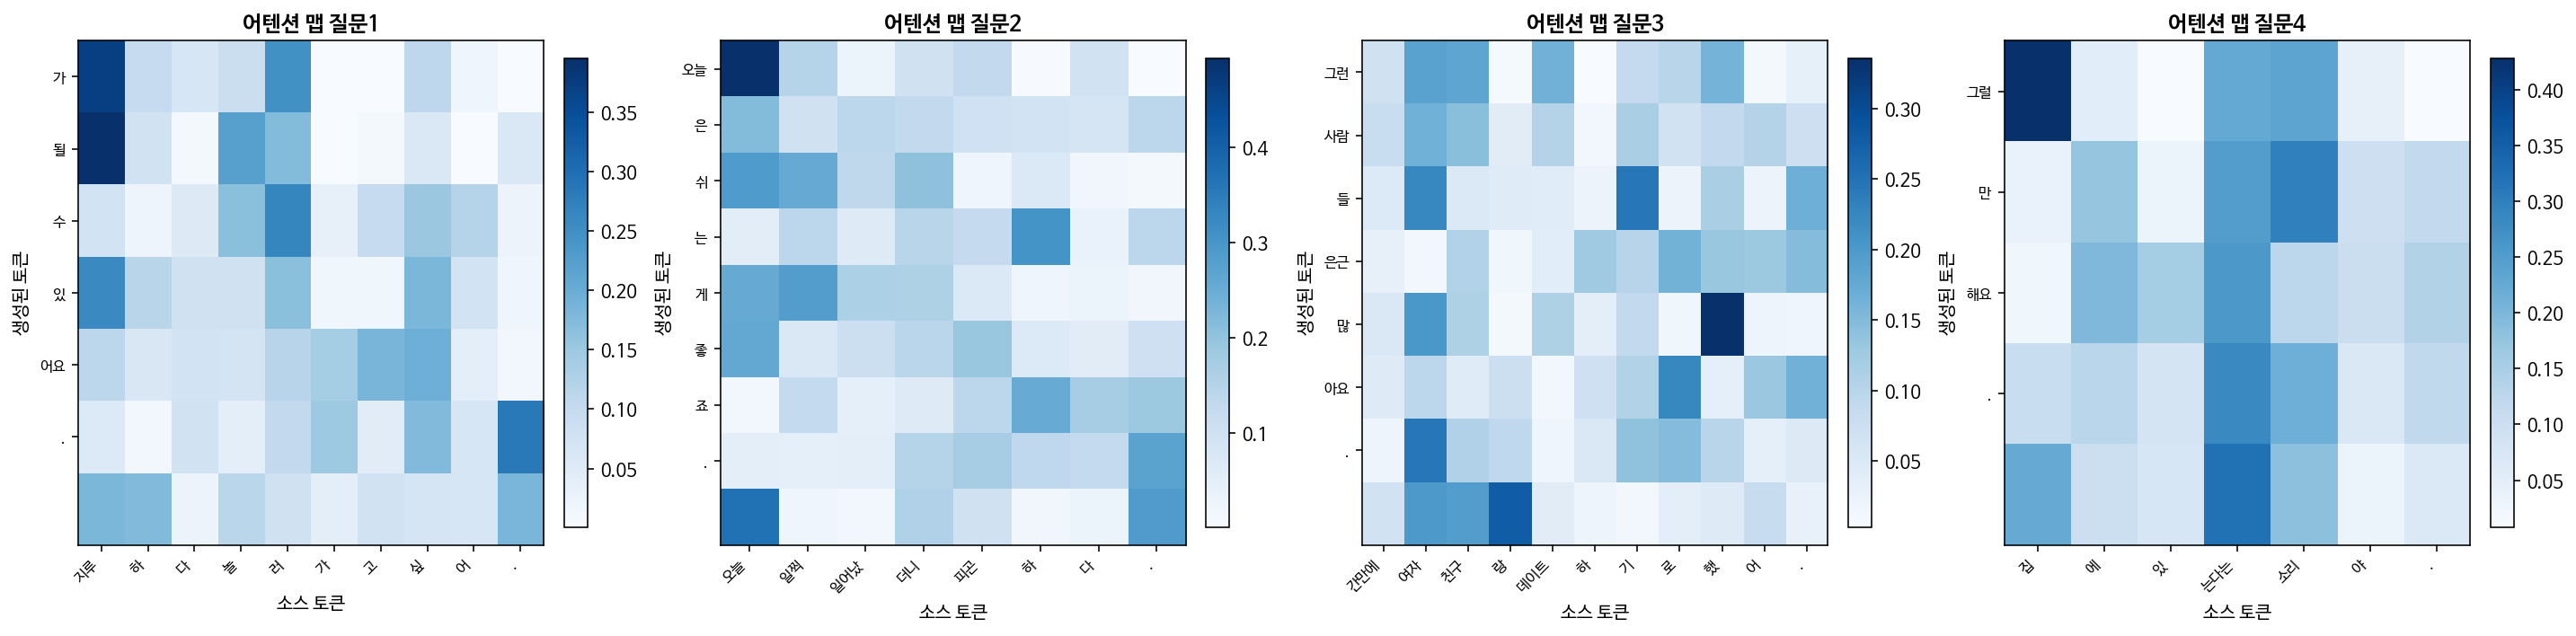

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.8226
Epoch 7 Validation Loss: 3.1233
[Epoch 7] BLEU: 0.0465
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 저 도 같이 놀 수 없 어요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 33.71
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 오늘 은 약간 의 변화 를 줘 보 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 39.16
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 환승 은 친구 이 라고 생각 해 주 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 23.36
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 항상 즐거운 시간 이 될 때 가 있 죠 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 21.98
----------------------------------------


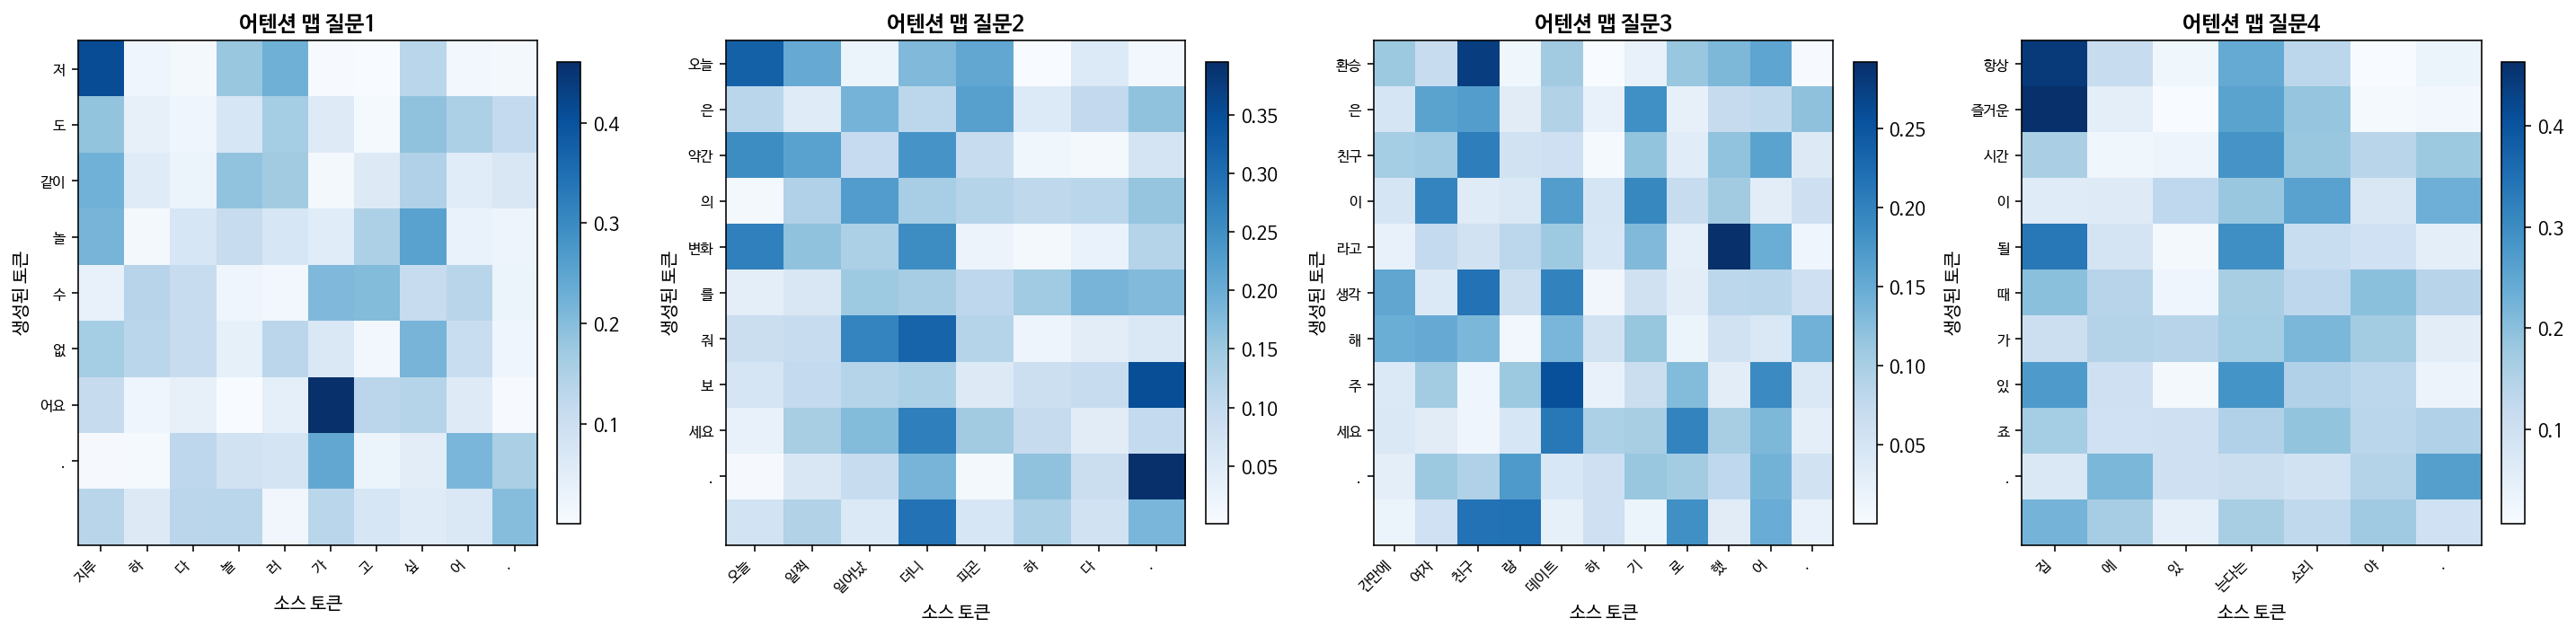

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 8 Train Loss: 0.6000
Epoch 8 Validation Loss: 3.3673
[Epoch 8] BLEU: 0.0674
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 저 도 같이 놀 아요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 42.31
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 오늘 일찍 주무세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 12.61
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 감사 합니다 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 28.60
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 항상 즐거운 목표 죠 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 31.87
----------------------------------------


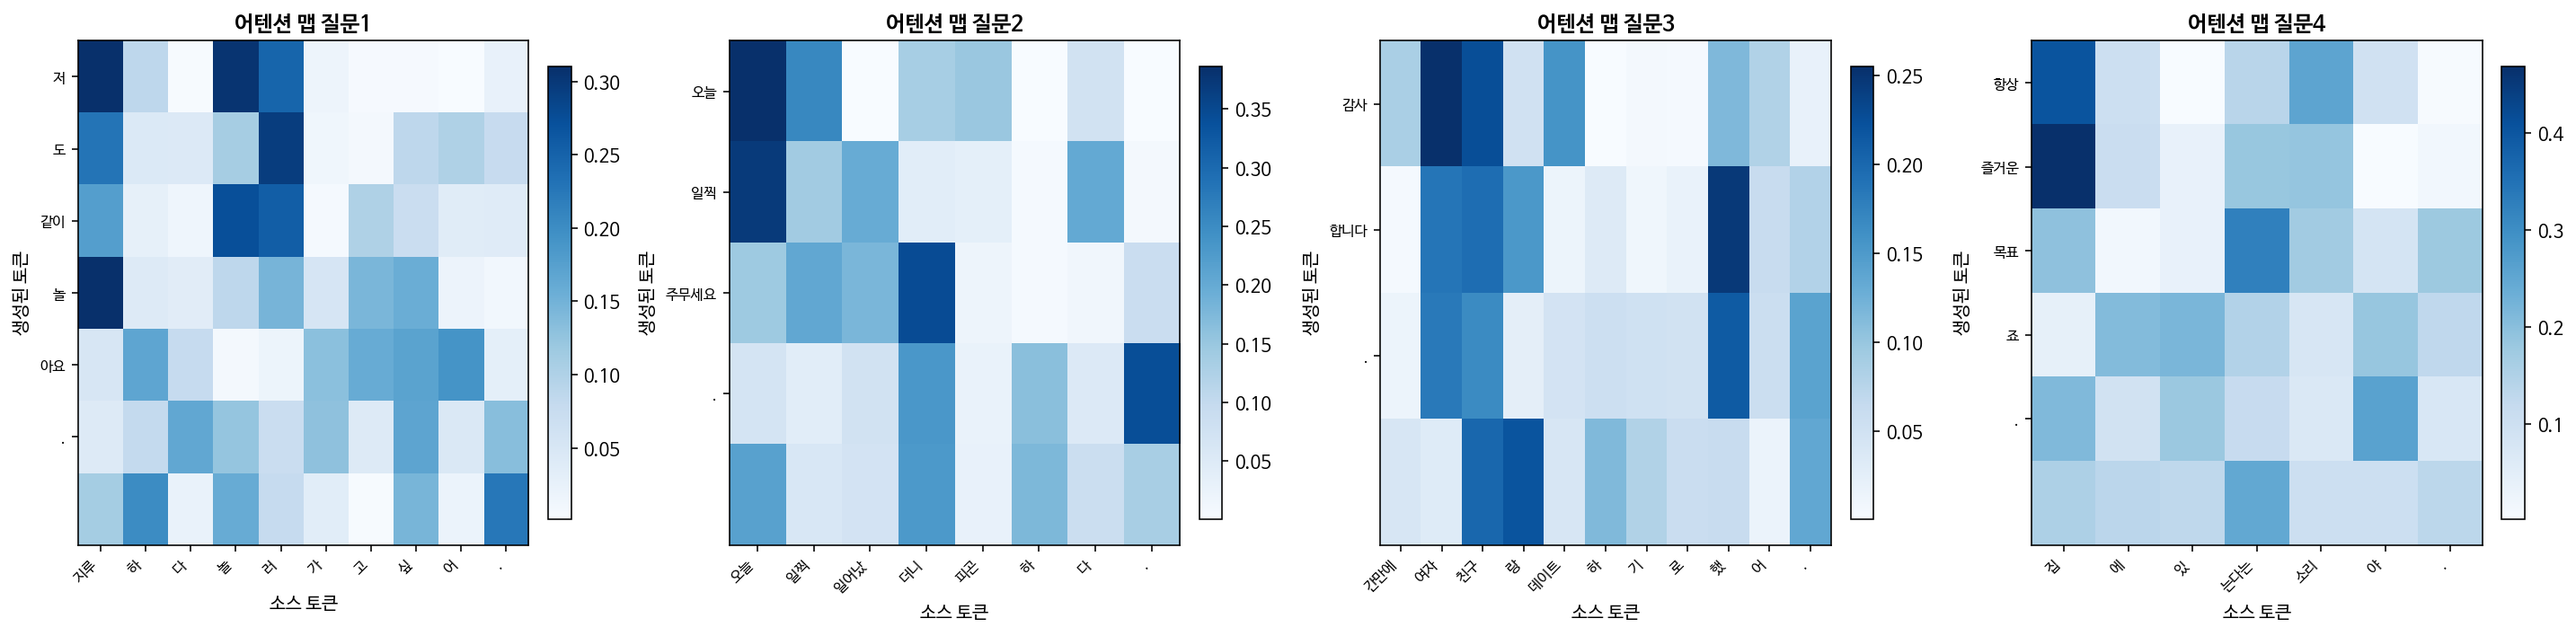

Early stopping triggered at epoch 8


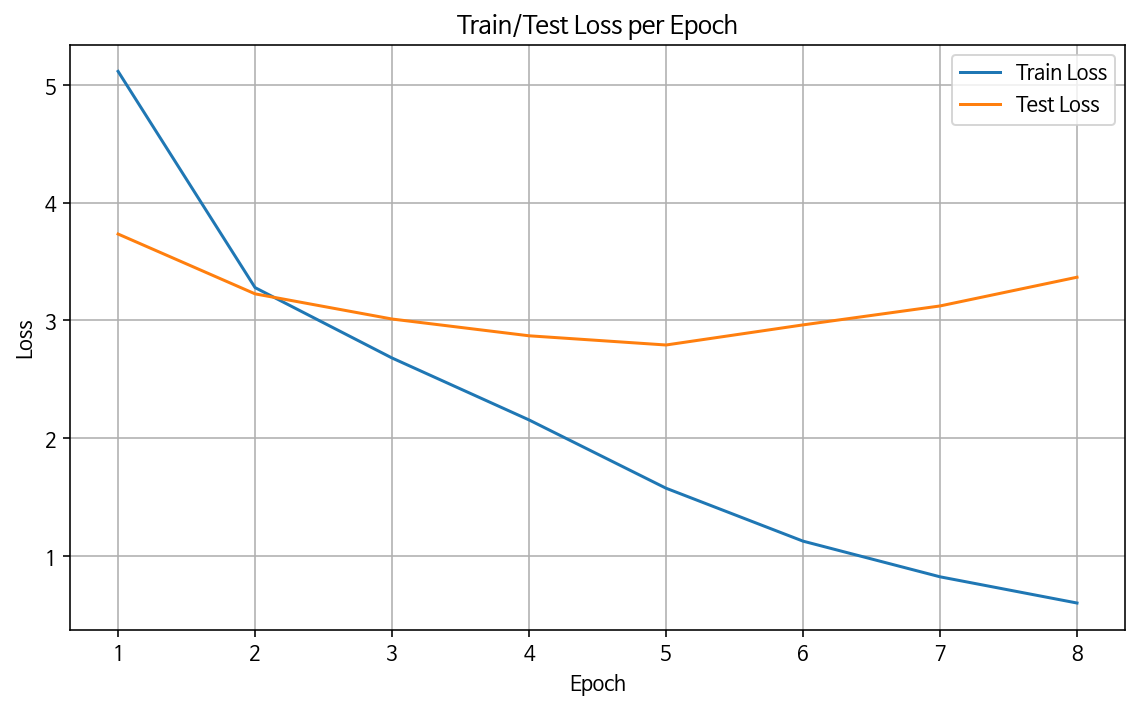

트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 저 도 같이 놀 아요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 42.31
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 오늘 일찍 주무세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 12.61
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 감사 합니다 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 28.60
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 항상 즐거운 목표 죠 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 31.87
----------------------------------------


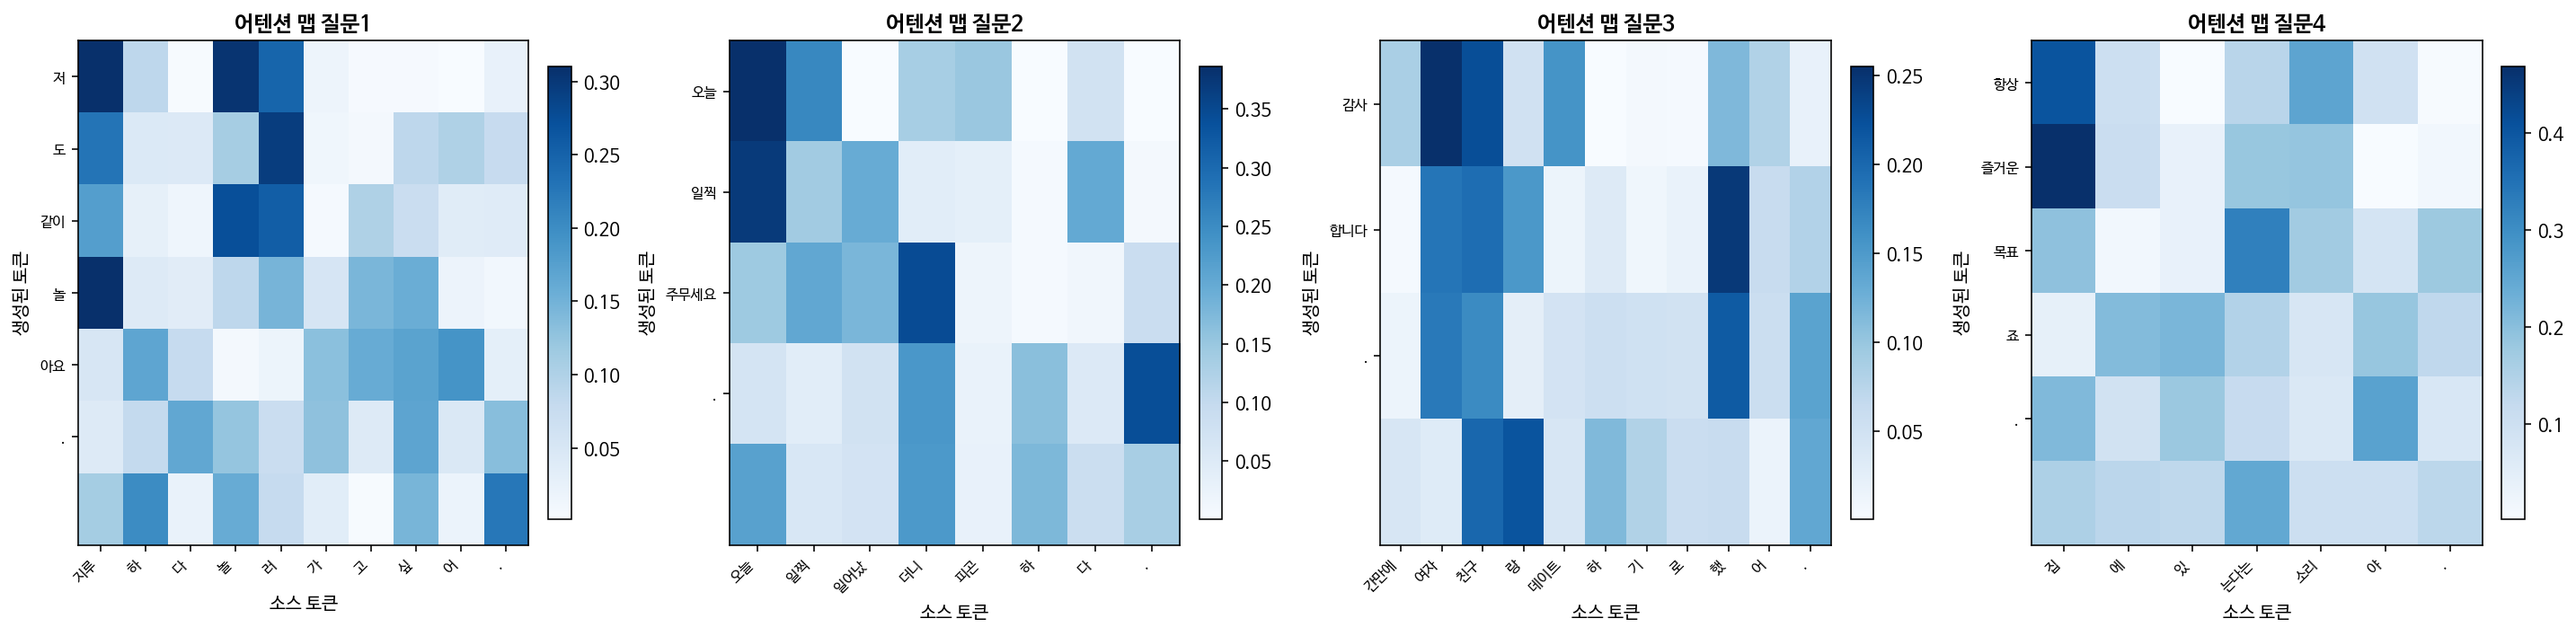

Trial 4/4: {'n_layers': 2, 'd_model': 368, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 1 Train Loss: 4.8063
Epoch 1 Validation Loss: 3.5597
[Epoch 1] BLEU: 0.0000
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 잘 하 는 것 같 아요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 30.53
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 좋 은 것 같 아요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 30.66
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 좋 은 일 이 에요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 54.54
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 잘 하 고 있 어요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 33.58
----------------------------------------


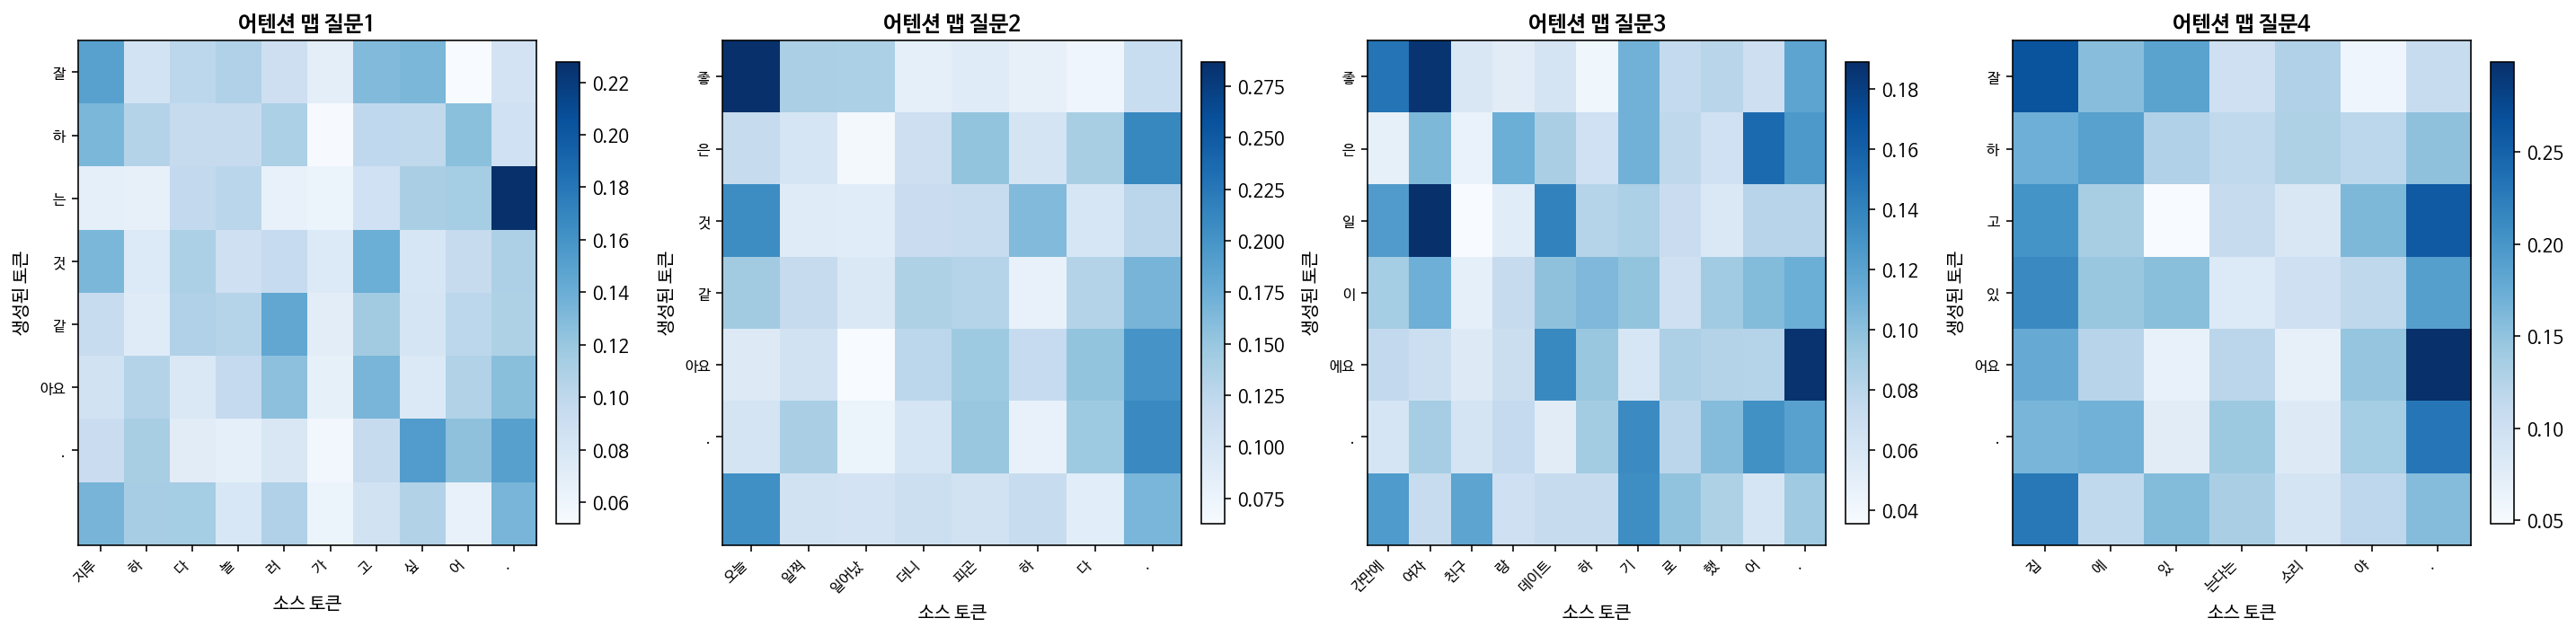

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 2 Train Loss: 3.0128
Epoch 2 Validation Loss: 3.1527
[Epoch 2] BLEU: 0.0000
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 맛있 게 드세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 35.79
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 맛있 게 드세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 25.68
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 직접 적 으로 물 어 보 는 게 좋 아요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 35.11
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 맛있 게 드세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 25.57
----------------------------------------


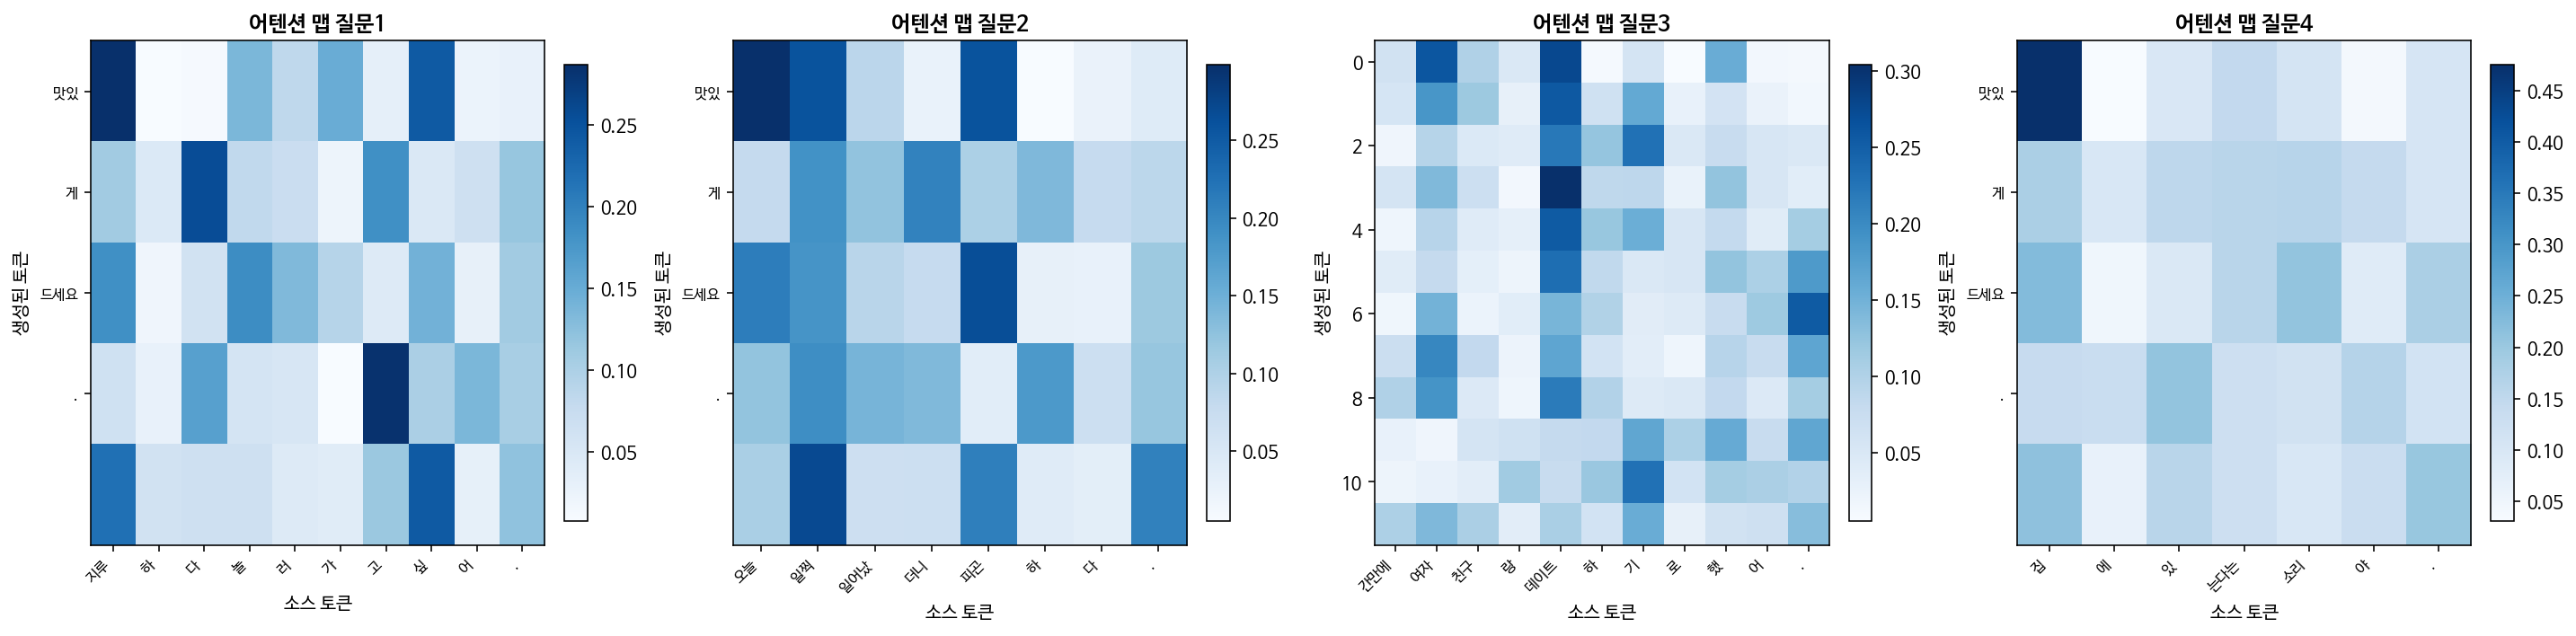

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 3 Train Loss: 2.4089
Epoch 3 Validation Loss: 3.2006
[Epoch 3] BLEU: 0.0000
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 지금 그러 고 있 는 게 지금 도 있 나 는 게 더 나 봅니다 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 19.37
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 오늘 도 같이 어요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 21.18
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 같이 수다 떨 면서 놀 까요 ?


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 39.92
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 조심히 오 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 37.28
----------------------------------------


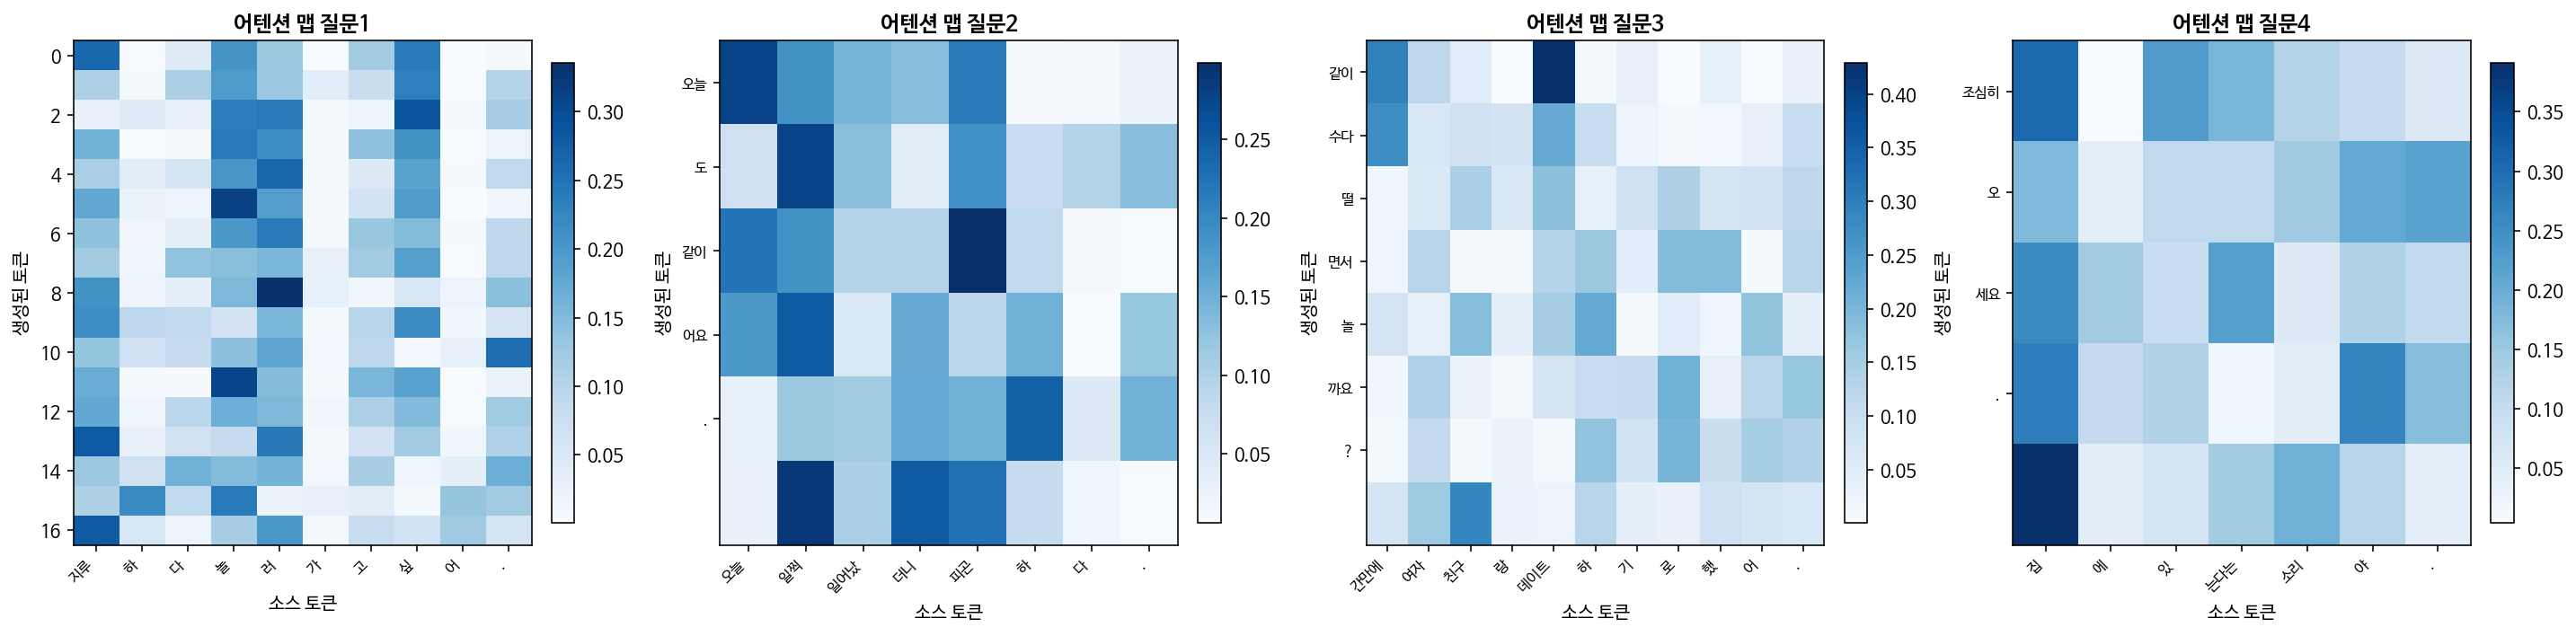

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.0516
Epoch 4 Validation Loss: 2.9923
[Epoch 4] BLEU: 0.0330
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 같이 등산 를 데이트 를 해 보 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 24.63
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 정신 적 이 죠 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 48.44
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 데이트 신청 해 보 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 24.05
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 혼자 를 즐기 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 19.63
----------------------------------------


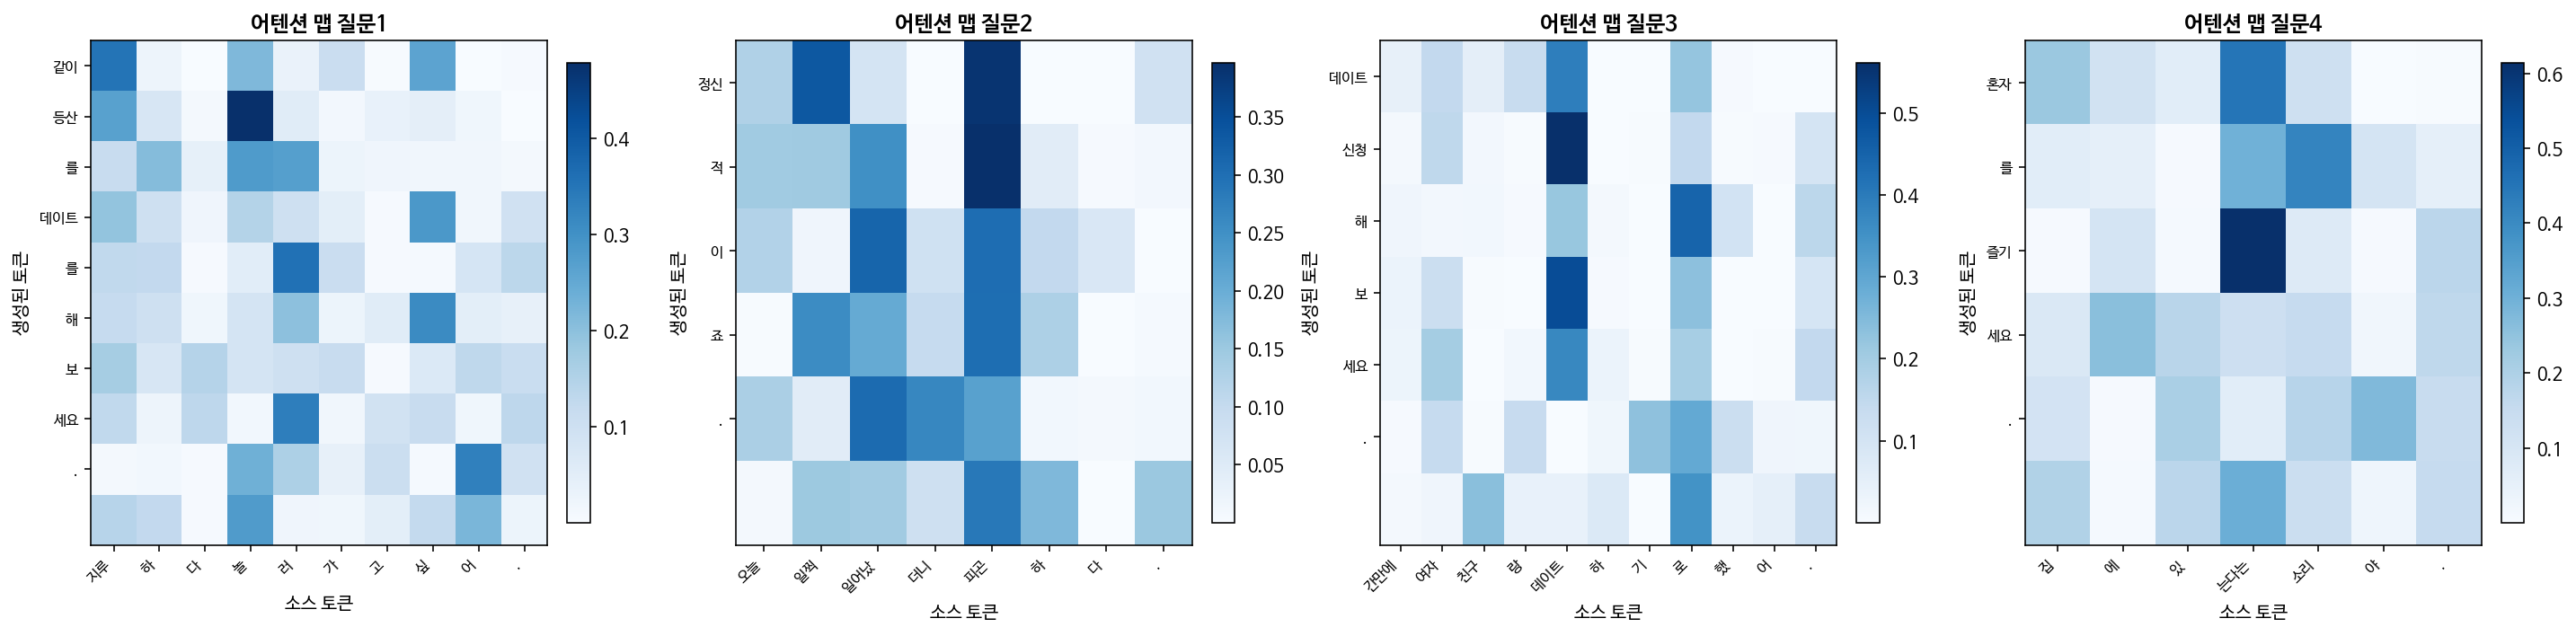

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 5 Train Loss: 1.5015
Epoch 5 Validation Loss: 3.0309
[Epoch 5] BLEU: 0.0468
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 마음 에 묻어두 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 52.76
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 정신 노동 하 세요 . 증거 한가요 . 증거 를 만들 뿐 이 에요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 24.55
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 같이 먹 는 곳 이 보 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 47.16
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 조심히 오 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 37.28
----------------------------------------


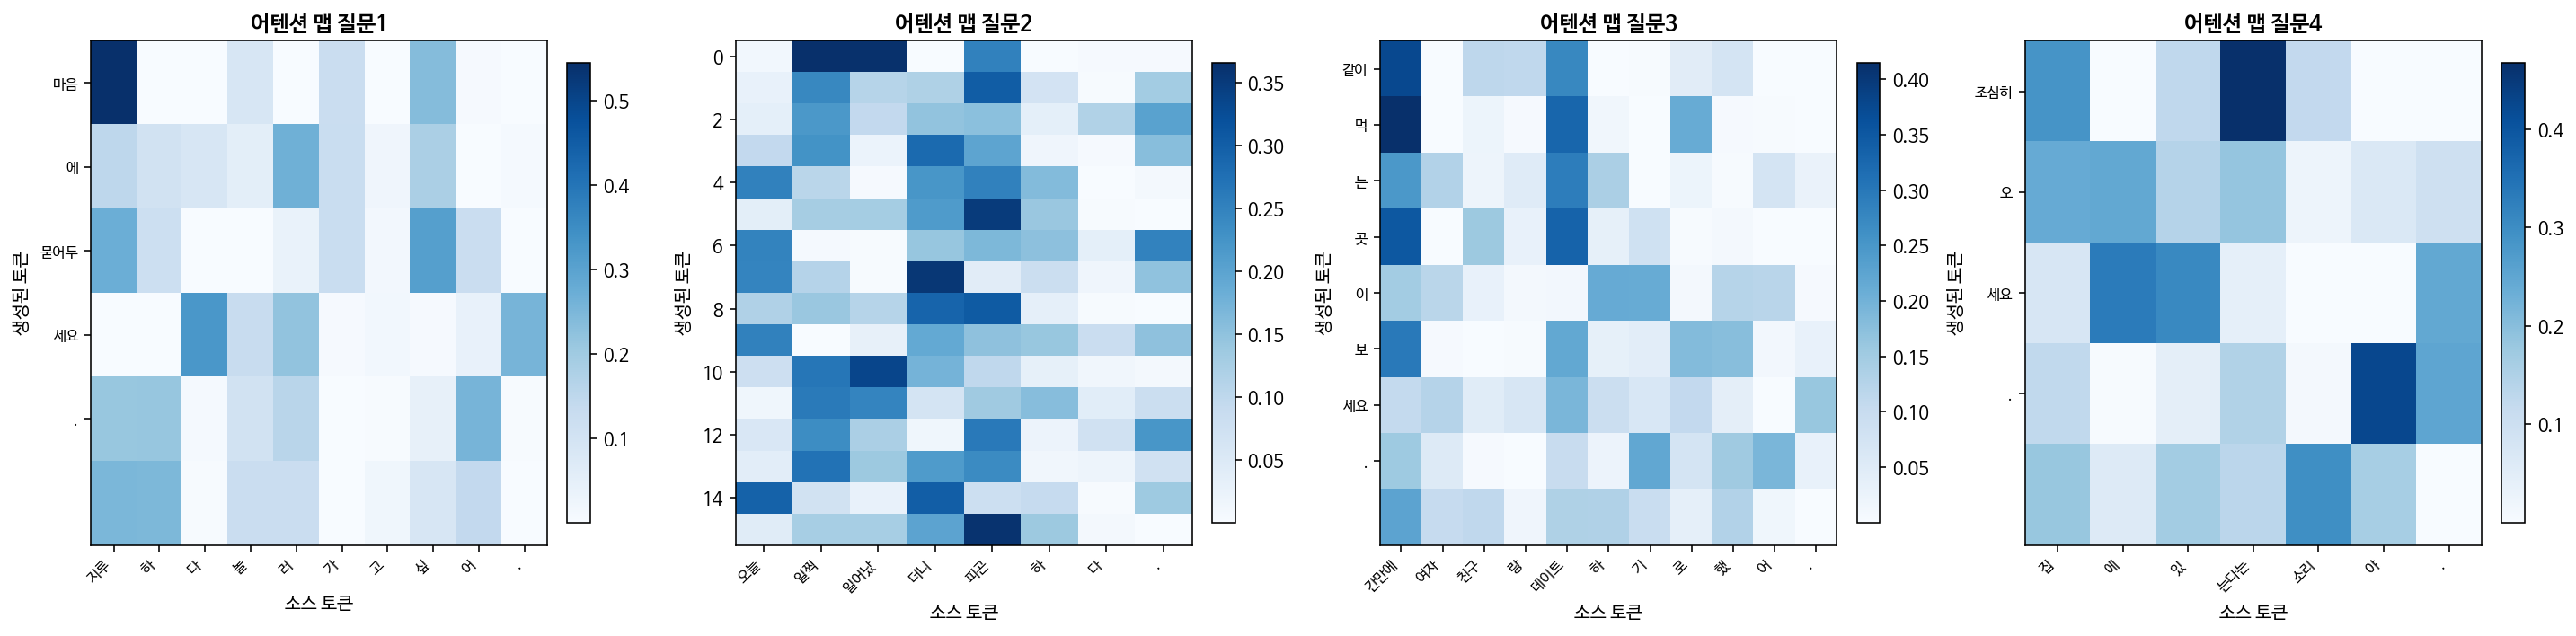

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.1098
Epoch 6 Validation Loss: 3.0784
[Epoch 6] BLEU: 0.0997
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 바뀔 수 있 어요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 59.16
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 푹 많 은 도움 이 될 거 예요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 55.64
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 즐거운 데이트 를 제안 해 보 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 22.98
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 다 챙겨 줘야 해서 상대 로 돌아올 거 예요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 33.16
----------------------------------------


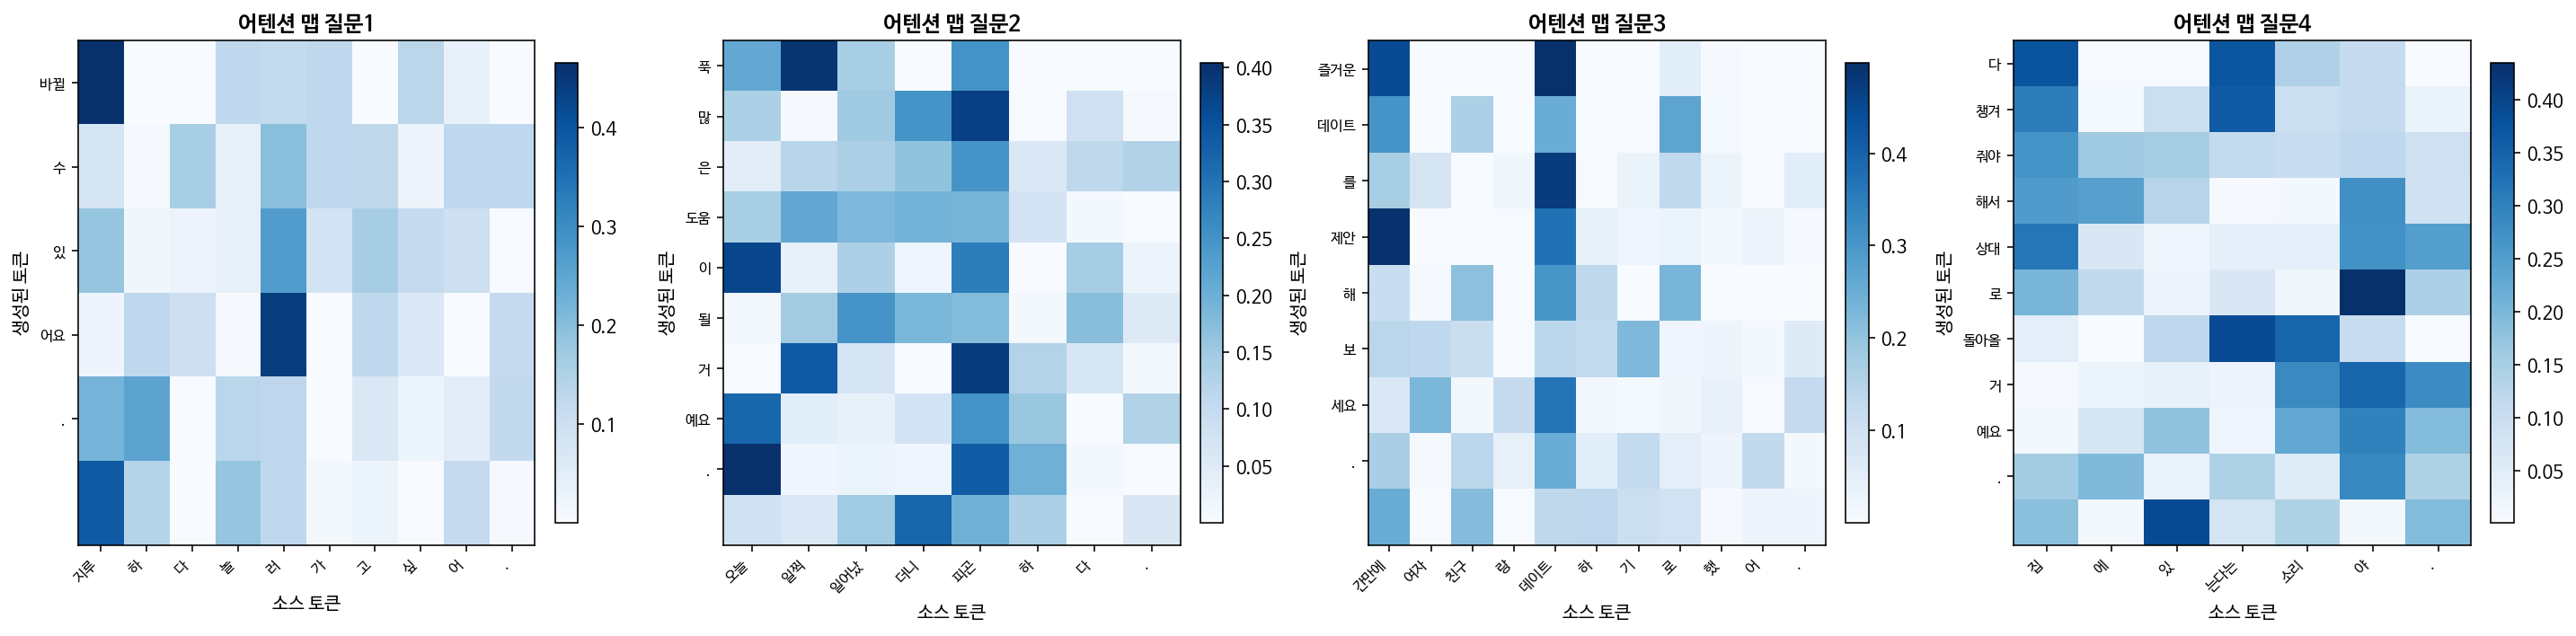

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.8404
Epoch 7 Validation Loss: 3.2651
[Epoch 7] BLEU: 0.0846
트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 마음 에 따라 얼마 든지 바뀔 수 있 어요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 41.60
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 추억 을 위해 함께 도 있 어요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 39.36
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 야경 이 멋져요 . 야경 구경 가 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 26.15
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 상대방 에 대한 지식 이 있 지 않 는 선물 이 좋 을 거 예요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 26.82
----------------------------------------


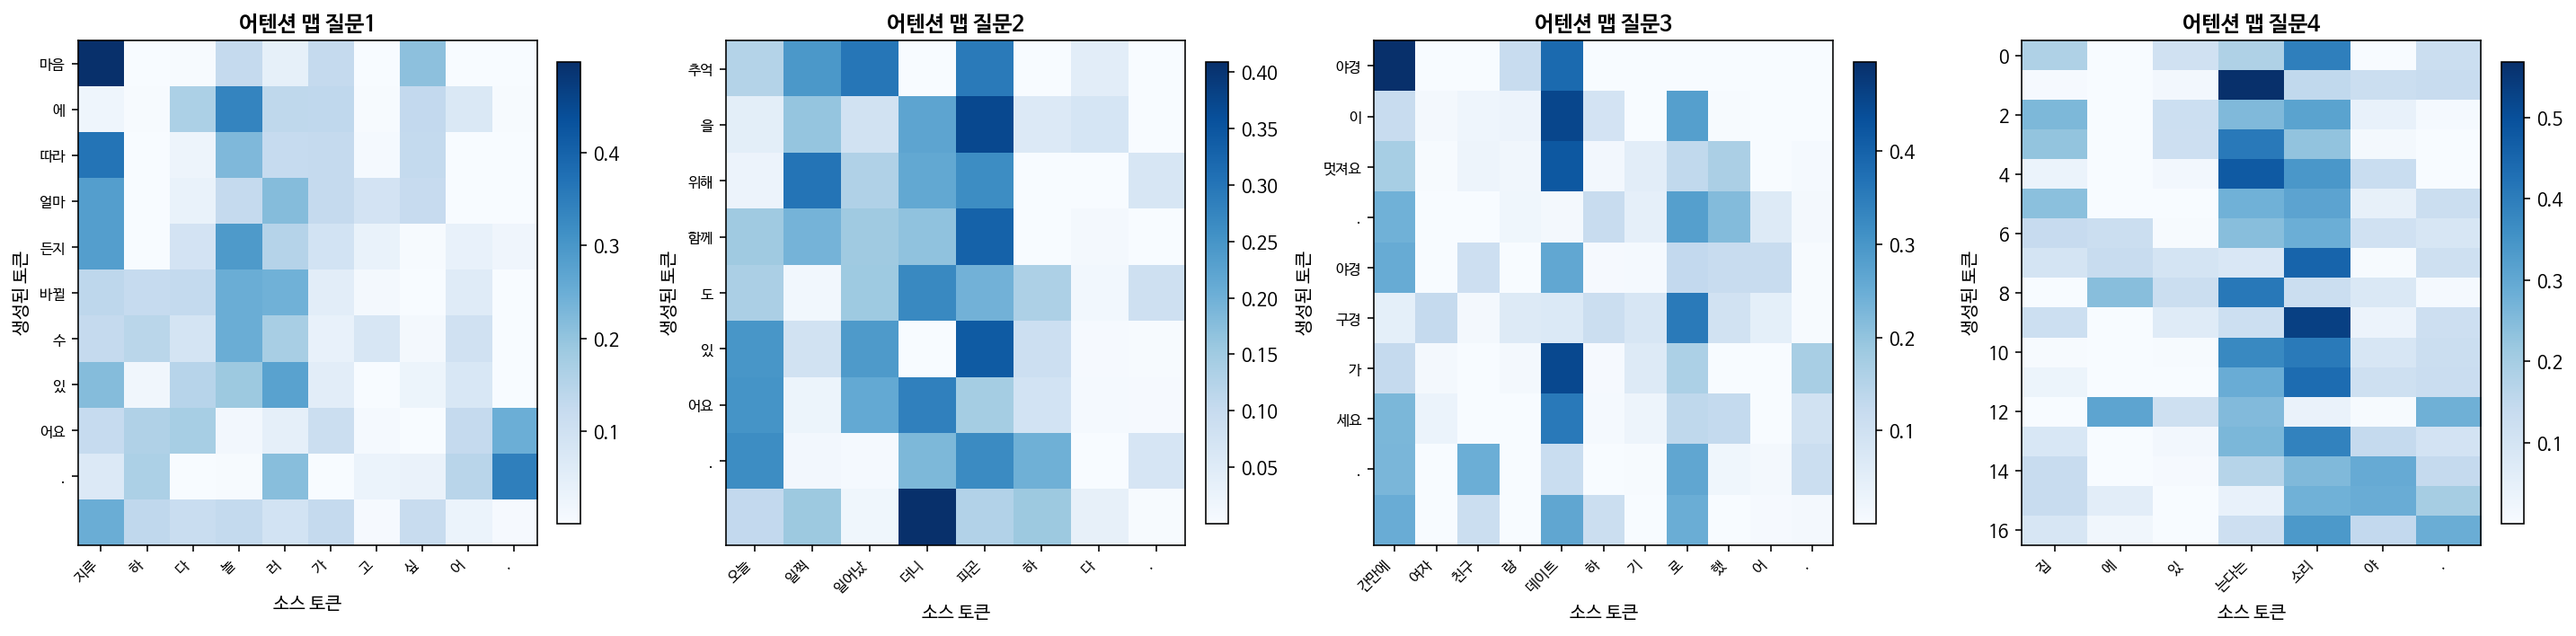

Early stopping triggered at epoch 7


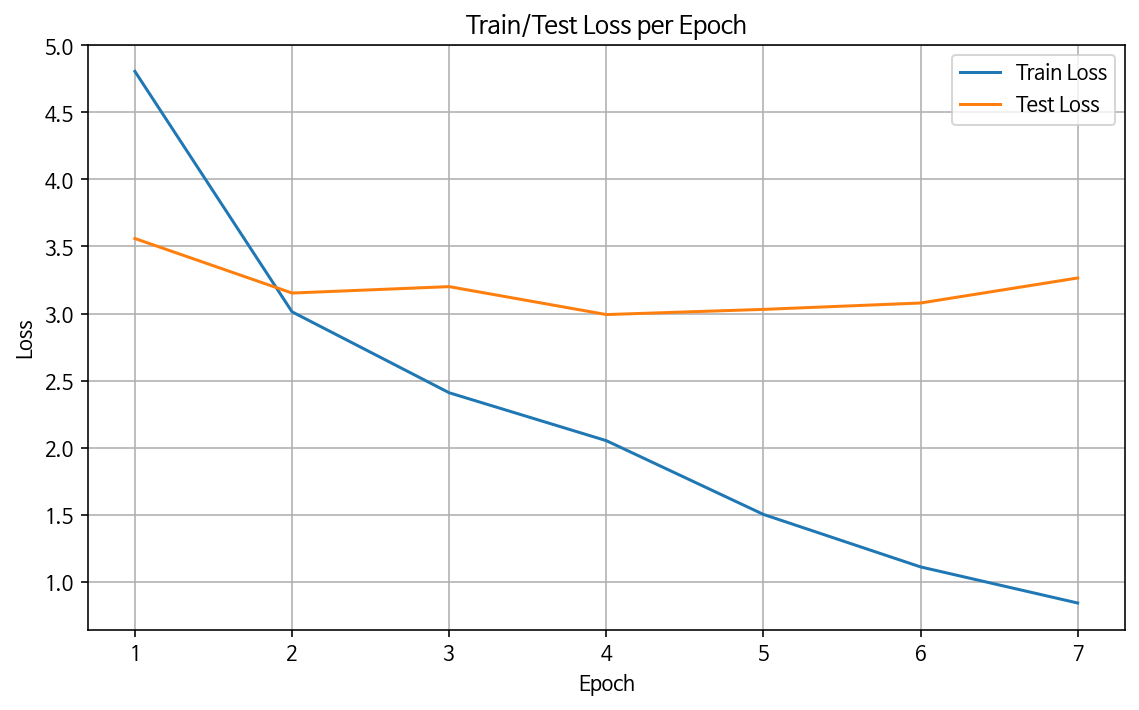

트랜스포머 챗봇 평가 결과
챗봇 응답 결과
질문1: 지루하다, 놀러가고 싶어.
답변1: 마음 에 따라 얼마 든지 바뀔 수 있 어요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 41.60
----------------------------------------
질문2: 오늘 일찍 일어났더니 피곤하다.
답변2: 추억 을 위해 함께 도 있 어요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 39.36
----------------------------------------
질문3: 간만에 여자친구랑 데이트 하기로 했어.
답변3: 야경 이 멋져요 . 야경 구경 가 세요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 26.15
----------------------------------------
질문4: 집에 있는다는 소리야.
답변4: 상대방 에 대한 지식 이 있 지 않 는 선물 이 좋 을 거 예요 .


Using pad_token, but it is not set yet.


챗봇 답변 Perplexity: 26.82
----------------------------------------


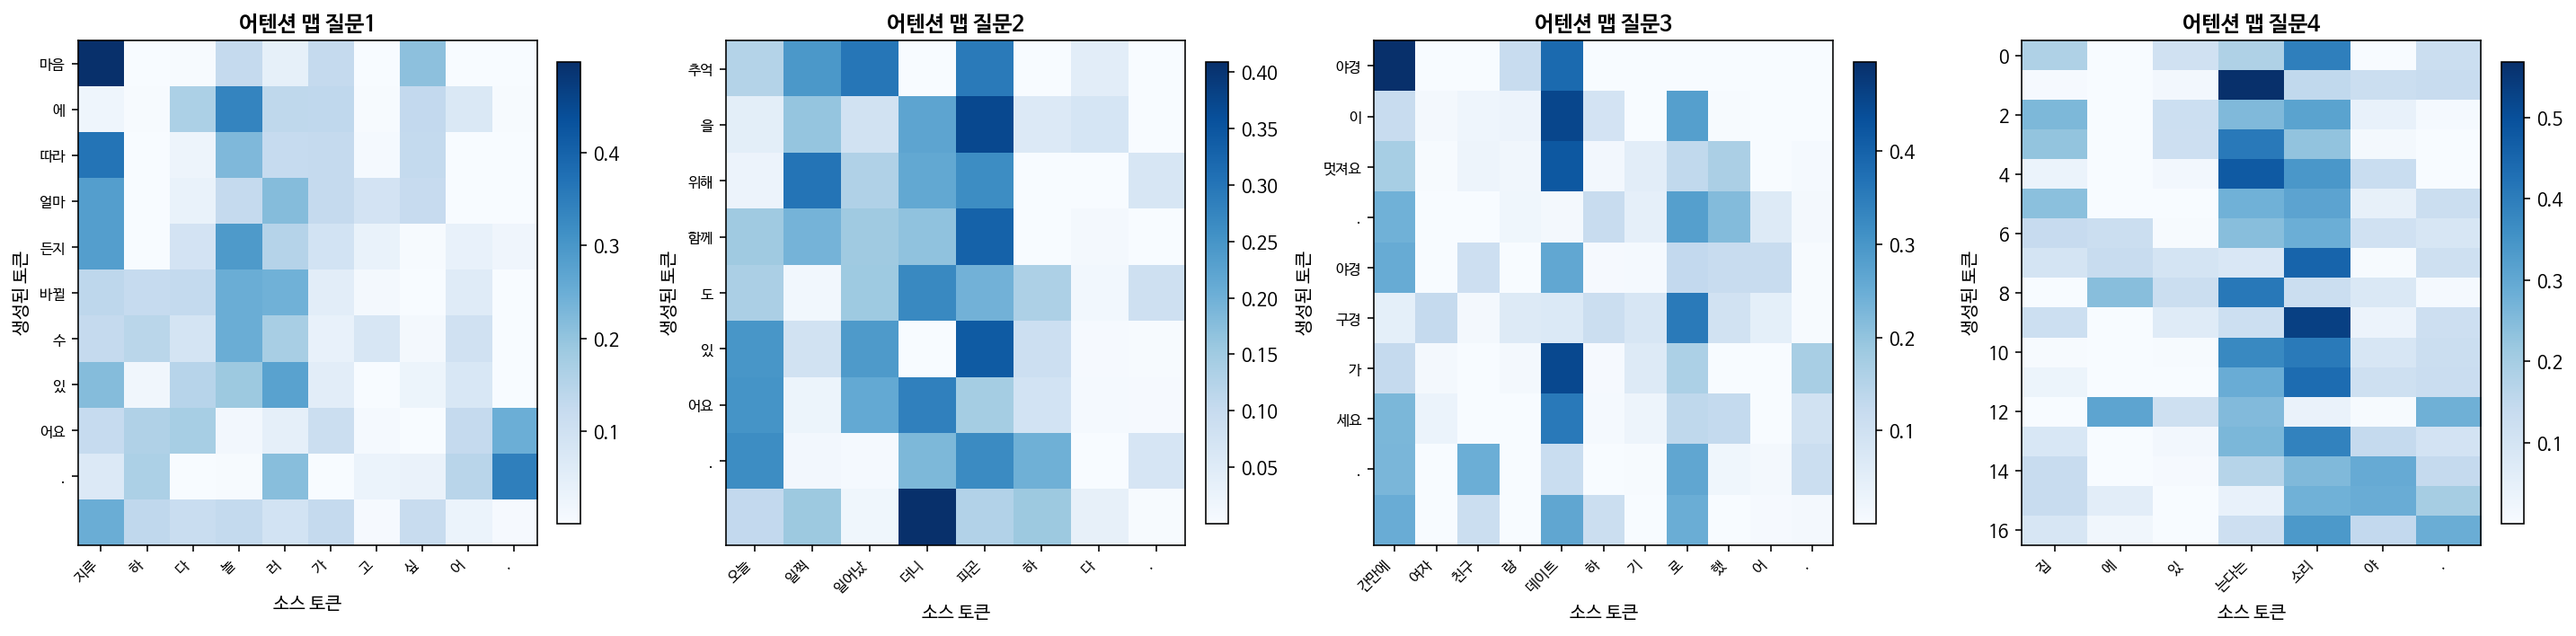

In [12]:
tf.config.run_functions_eagerly(True)
K.clear_session()

result = []
hp_order = ["n_layers", "d_model", "n_heads", "d_ff", "dropout"]
for i, hp_args in enumerate(arg_combinations):
    print(f"Trial {i+1}/{len(arg_combinations)}: {hp_args}")

    full_args = {
        "src_vocab_size": len(tokenizer.word_index) + 1,
        "tgt_vocab_size": len(tokenizer.word_index) + 1,
        "pos_len": 80,
        "shared_fc": True,
        "shared_emb": True,
        **hp_args,
    }

    for warm in [500]:
        print(f"Warmup Steps: {warm}")
        best_val_loss = tuner(
            full_args, f"transformer_{i+1}_", warmup_steps=warm, epoch=20
        )
        hp_tuple = tuple(hp_args[k] for k in hp_order) + (warm, best_val_loss)
        result.append(hp_tuple)
        K.clear_session()

## 결과 분석

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

# CSV 파일 경로
BASELINE_CSV = 'transformer_chatbot_baseline_training_results.csv'
TEAM_CSV     = 'transformer_chatbot_team_results.csv'

# 읽기
baseline = pd.read_csv(BASELINE_CSV)
team     = pd.read_csv(TEAM_CSV)

baseline['perplexity_avg'] = (baseline['Perplexity1'] + baseline['Perplexity2'] + baseline['Perplexity3'] +baseline['Perplexity4'])/4

#  평균 Perplexity 계산 (Perplexity1~Perplexity4 컬럼명이 다르다면 알맞게 수정)
perp_cols = [c for c in team.columns if c.lower().startswith('perplexity_')]
team['perplexity_avg'] = team[perp_cols].mean(axis=1).round(2)
team[perp_cols] = team[perp_cols].round(2)


# 2) 평균 Perplexity 계산 (컬럼명에 'perplex' 포함된 모든 컬럼)
perp_cols = [c for c in baseline.columns if 'perplex' in c.lower()]
baseline['perplexity_avg'] = baseline[perp_cols].mean(axis=1)

# 3) BLEU 값이 가장 높은 실험 3개
top_bleu = baseline.sort_values('BLEU', ascending=False).head(3)

# 4) 평균 Perplexity가 가장 낮은 실험 3개
top_perp = baseline.sort_values('perplexity_avg', ascending=True).head(3)

# 5) Validation Loss가 가장 낮은 실험 3개
top_loss = baseline.sort_values('Validation_Loss', ascending=True).head(3)


### Baselise TEST -  BLEU 와 Validation Loss 그리고 Perplexity  TOP3
- 절대적인 것은 아니지만 perplexity 값이 낮으면 말이 되는 답변인 경우가 많아보인다.
- BLEU와 Validation loss가 좋은 값인 경우와 perplexity 나 좋은 답변 여부는 관련이 없어보인다.
- perplexity 결과를 보면 epoch가 낮을때도 높을때도 있어 과적합 여부와는 상관이 없어보인다.
- perplexity 결과를 보면 layer와 d_model이 큰 경우에 더 좋은 결과를 보이는 경향이 있는 것으로 보인다.
- 

In [54]:
top_perp

Trial  n_layers  d_model  Epoch  Train_Loss  Validation_Loss    BLEU  \
28      4         2      368      6      1.1098           3.0784  0.0997   
14      2         1      368      7      0.6956           3.1804  0.0982   
9       2         1      368      2      2.9628           2.9826  0.0928   

                Q1                    A1  Perplexity1                 Q2  \
28  지루하다, 놀러가고 싶어.           바뀔 수 있 어요 .        59.16  오늘 일찍 일어났더니 피곤하다.   
14  지루하다, 놀러가고 싶어.  마음 과 걱정 을 덜 하 면 돼요 .        61.12  오늘 일찍 일어났더니 피곤하다.   
9   지루하다, 놀러가고 싶어.             같이 놀 아요 .        30.26  오늘 일찍 일어났더니 피곤하다.   

                     A2  Perplexity2                     Q3  \
28  푹 많 은 도움 이 될 거 예요 .        55.64  간만에 여자친구랑 데이트 하기로 했어.   
14    요즘 많이 피곤 했 나 봐요 .        26.82  간만에 여자친구랑 데이트 하기로 했어.   
9          오늘 일찍 주무세요 .        12.61  간만에 여자친구랑 데이트 하기로 했어.   

                       A3  Perplexity3            Q4  \
28  즐거운 데이트 를 제안 해 보 세요 .        22.98  집에 있는다는 소리야.   
14        그 분 생각 해 보 세요 .        26.51  집에 있는다는 소리야.   
9             같이 가 보 세요 .        19.58  집에 있는다는 소리야.   

                            A4  Perplexity4  perplexity_avg  
28  다 챙겨 줘야 해서 상대 로 돌아올 거 예요 .        33.16          42.735  
14                  좋 은 일 해요 .        75.65          47.525  
9              마음 이 좀 챙겨 드세요 .        34.73          24.295

In [58]:
top_bleu

Trial  n_layers  d_model  Epoch  Train_Loss  Validation_Loss    BLEU  \
28      4         2      368      6      1.1098           3.0784  0.0997   
14      2         1      368      7      0.6956           3.1804  0.0982   
9       2         1      368      2      2.9628           2.9826  0.0928   

                Q1                    A1  Perplexity1                 Q2  \
28  지루하다, 놀러가고 싶어.           바뀔 수 있 어요 .        59.16  오늘 일찍 일어났더니 피곤하다.   
14  지루하다, 놀러가고 싶어.  마음 과 걱정 을 덜 하 면 돼요 .        61.12  오늘 일찍 일어났더니 피곤하다.   
9   지루하다, 놀러가고 싶어.             같이 놀 아요 .        30.26  오늘 일찍 일어났더니 피곤하다.   

                     A2  Perplexity2                     Q3  \
28  푹 많 은 도움 이 될 거 예요 .        55.64  간만에 여자친구랑 데이트 하기로 했어.   
14    요즘 많이 피곤 했 나 봐요 .        26.82  간만에 여자친구랑 데이트 하기로 했어.   
9          오늘 일찍 주무세요 .        12.61  간만에 여자친구랑 데이트 하기로 했어.   

                       A3  Perplexity3            Q4  \
28  즐거운 데이트 를 제안 해 보 세요 .        22.98  집에 있는다는 소리야.   
14        그 분 생각 해 보 세요 .        26.51  집에 있는다는 소리야.   
9             같이 가 보 세요 .        19.58  집에 있는다는 소리야.   

                            A4  Perplexity4  perplexity_avg  
28  다 챙겨 줘야 해서 상대 로 돌아올 거 예요 .        33.16          42.735  
14                  좋 은 일 해요 .        75.65          47.525  
9              마음 이 좀 챙겨 드세요 .        34.73          24.295

In [59]:
top_loss

Trial  n_layers  d_model  Epoch  Train_Loss  Validation_Loss    BLEU  \
4       1         1      128      5      1.5004           2.7801  0.0389   
3       1         1      128      4      2.0706           2.7898  0.0000   
19      3         2      128      5      1.5751           2.7917  0.0733   

                Q1                             A1  Perplexity1  \
4   지루하다, 놀러가고 싶어.      마음 에 따라 얼마 든지 바뀔 수 있 어요 .        41.60   
3   지루하다, 놀러가고 싶어.         좋 은 사람 만날 수 있 을 거 예요 .        83.00   
19  지루하다, 놀러가고 싶어.  저 도 같이 놀 러 가 서 놀 러 가 서 놀 아요 .        28.92   

                   Q2                A2  Perplexity2                     Q3  \
4   오늘 일찍 일어났더니 피곤하다.  제 가 들 어 가 있 네요 .        24.77  간만에 여자친구랑 데이트 하기로 했어.   
3   오늘 일찍 일어났더니 피곤하다.  조금 만 더 버텨 보 세요 .        32.16  간만에 여자친구랑 데이트 하기로 했어.   
19  오늘 일찍 일어났더니 피곤하다.      저 에게 기대 세요 .        27.91  간만에 여자친구랑 데이트 하기로 했어.   

                         A3  Perplexity3            Q4                    A4  \
4        인생 은 아니 었 을 거 예요 .        38.29  집에 있는다는 소리야.           같이 가 보 세요 .   
3   당신 의 삶 에 대해 생각 해 보 세요 .        51.72  집에 있는다는 소리야.        글 을 쓰 고 싶 네요 .   
19          다른 곳 에 가 보 세요 .        41.42  집에 있는다는 소리야.  사랑 은 사람 이 라면 문제 네요 .   

    Perplexity4  perplexity_avg  
4         20.33         31.2475  
3         43.64         52.6300  
19        38.73         34.2450

### 팀 실험 결과( 표 )
- backTrans 결과 모든 결과값이 같은데 이 부분은 이상하다. 결과를 재 확인해봐야할듯함
- koEDA의 경우 target에 적용하면 안되는 증강기법을 적용해 데이터가 이상해 답변 결과가 매우 이상하게 나왔다.


In [33]:
team

augmentation  n_layers  d_model  val_loss  val_BLEU  \
0                      baseline         1      128    2.7801    0.0389   
1                      baseline         1      368    2.8055    0.0000   
2                      baseline         2      368    2.9923    0.0330   
3                      baseline         2      128    2.7917    0.0733   
4   backtTranslation(9263 쌍 추가)         1      128    3.6177    0.0355   
5   backtTranslation(9263 쌍 추가)         1      368    3.5524    0.0374   
6   backtTranslation(9263 쌍 추가)         2      128    3.5466    0.0355   
7   backtTranslation(9263 쌍 추가)         2      368    3.6310    0.0364   
8           lexical(20545 쌍 추가)         1      128    1.1290    0.6975   
9           lexical(20545 쌍 추가)         1      368    1.0620    0.6148   
10          lexical(20545 쌍 추가)         2      128    1.1471    0.6477   
11          lexical(20545 쌍 추가)         2      368    1.1038    0.7197   
12           koEDA (34785 쌍 추가)         1      128    3.4302    0.0327   
13           koEDA (34785 쌍 추가)         1      368    3.3574    0.0494   
14           koEDA (34785 쌍 추가)         2      128    3.4472    0.0000   
15           koEDA (34785 쌍 추가)         2      368    3.4638    0.1067   

                            ans_1  perplexity_1  \
0       마음 에 따라 얼마 든지 바뀔 수 있 어요 .         41.60   
1                     저 랑 같이 가요 .         32.83   
2          같이 등산 를 데이트 를 해 보 세요 .         24.63   
3   저 도 같이 놀 러 가 서 놀 러 가 서 놀 아요 .         28.92   
4                그런 사람 은 항상 오 죠 .         13.54   
5                그런 사람 은 항상 오 죠 .         13.54   
6                그런 사람 은 항상 오 죠 .         13.54   
7                그런 사람 은 항상 오 죠 .         13.54   
8                 '바쁘 게 해 보 세요 .’          1.60   
9             '저 도 궁금하 으며 겠 어요 .’          1.43   
10               '저 도 배우 면 좋 죠 .’          1.54   
11               '당신 은 매력 은 네요 .’          1.63   
12          행어스히어스는 지루하다, 놀러가고 싶어          2.05   
13        팀해시지지는 있는 지루하다, 놀러가고 싶�          3.29   
14       하고 자성한 모고 적청은 적청은 부신어 고�          5.69   
15          과제과, 저연는 네무리기고 지는부게으�          6.24   

                                   ans_2  perplexity_2  \
0                       제 가 들 어 가 있 네요 .         24.77   
1                           사춘기 인가 봅니다 .         29.88   
2                             정신 적 이 죠 .         48.44   
3                            저 에게 기대 세요          27.91   
4                       오늘 은 항상 일어나 세요 .          6.35   
5                       오늘 은 항상 일어나 세요 .          6.35   
6                       오늘 은 항상 일어나 세요 .          6.35   
7                       오늘 은 항상 일어나 세요 .          6.35   
8                   '짝사랑 인지 생각 해 보 세요 .’          1.75   
9              '고민 하 지 말 고 내려놓 길 바랄게요 .’          1.57   
10  '힘드 시 면 안 하 는 게 도움 이 그냥 맘 편할 거 예요 .’          1.58   
11                           '아닐 거 예요 .’          1.62   
12               가제국이 카고 없수는니.\n세리검고: 고성          5.15   
13            가어났더니 미요들이 어는니다.\n질문: 오늘 �          3.53   
14              할에 일를동고 장지만 이명을 이내다.\n아무          5.44   
15              가사질다가 지를 실늘 게지를 수는니다. 신�          5.78   

                             ans_3  perplexity_3                      ans_4  \
0               인생 은 아니 었 을 거 예요 .         38.29                같이 가 보 세요 .   
1   그 사람 도 당신 을 좋아하 는지 깊 게 만들 어요 .         35.32         내 집 에 는 들어줄 거 예요 .   
2                  데이트 신청 해 보 세요 .         24.05               혼자 를 즐기 세요 .   
3                  다른 곳 에 가 보 세요 .         41.42       사랑 은 사람 이 라면 문제 네요 .   
4                       커피 향 좋 죠 .         27.90           그런 사람 은 항상 오 죠 .   
5                       커피 향 좋 죠 .         27.90           그런 사람 은 항상 오 죠 .   
6                       커피 향 좋 죠 .         27.90           그런 사람 은 항상 오 죠 .   
7                       커피 향 좋 죠 .         27.90           그런 사람 은 항상 오 죠 .   
8              '분위기 있 는 순간 은 군요 .’          1.80          '사랑 이 피곤 한가 봐요 .’   
9                    '고생 많 았 어요 .’          1.63          '저 도 긴장 해 주 세요 .’   
10             '후회 하 지 않 길 바라 요 .’  

### BLEU 와 Validation Loss 그리고 Perplexity 상호 관계 파악
- baseline 과 team 결과 모두에서 특별한 규칙을 찾기 어려움

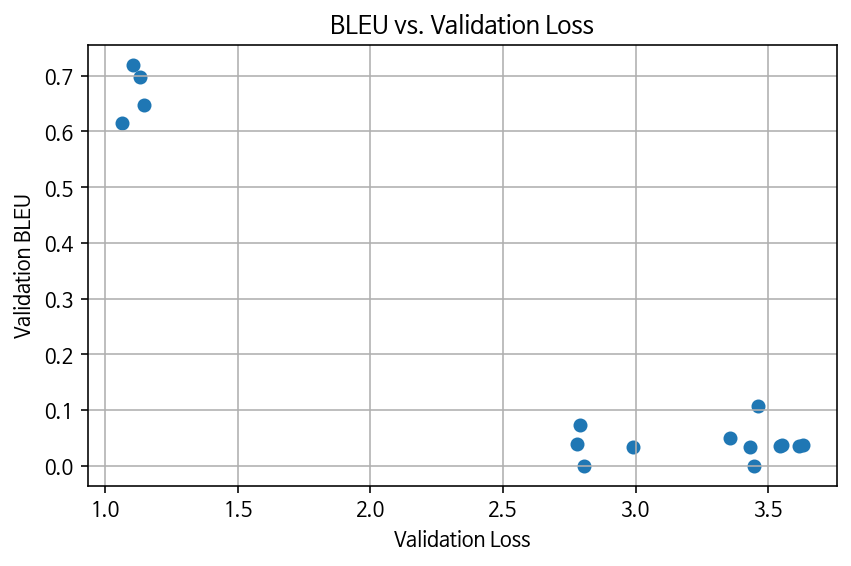

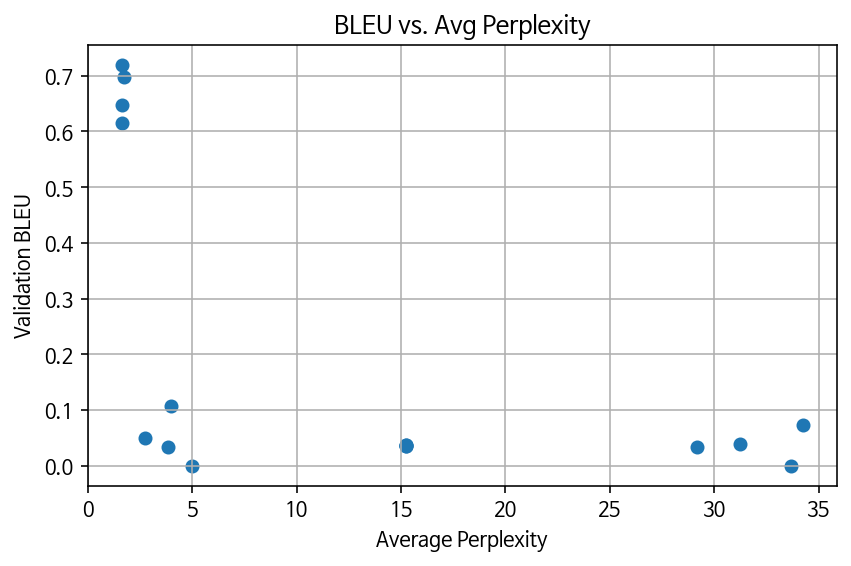

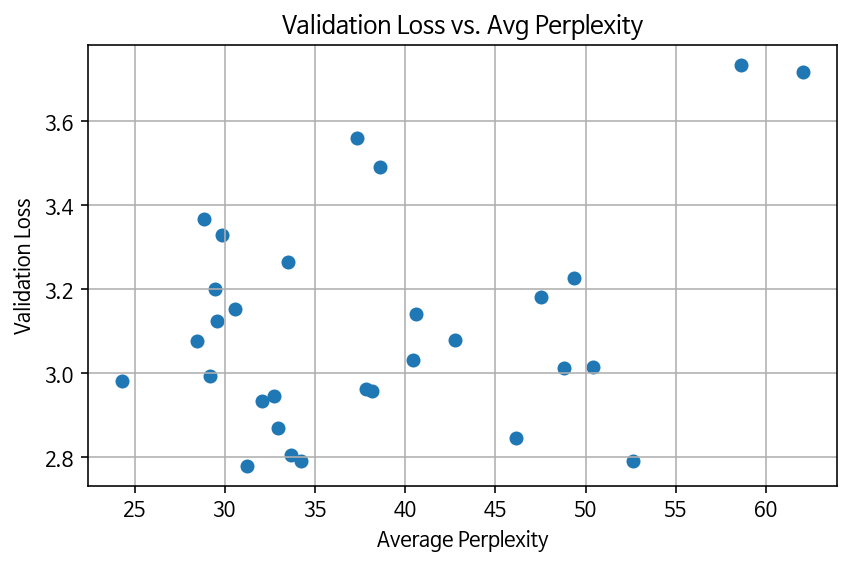

In [45]:

# 6) BLEU vs. Validation Loss (scatter)
plt.figure(figsize=(6,4))
plt.scatter(team['val_loss'], team['val_BLEU'])
plt.xlabel("Validation Loss")
plt.ylabel("Validation BLEU")
plt.title("BLEU vs. Validation Loss")
plt.grid()
plt.tight_layout()
plt.show()

# 7) BLEU vs. Perplexity 평균 (scatter)
plt.figure(figsize=(6,4))
plt.scatter(team['perplexity_avg'], team['val_BLEU'])
plt.xlabel("Average Perplexity")
plt.ylabel("Validation BLEU")
plt.title("BLEU vs. Avg Perplexity")
plt.grid()
plt.tight_layout()
plt.show()

# 7) Validation Loss vs. Perplexity 평균 (scatter)
plt.figure(figsize=(6,4))
plt.scatter(baseline['perplexity_avg'], baseline['Validation_Loss'])
plt.xlabel("Average Perplexity")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs. Avg Perplexity")
plt.grid()
plt.tight_layout()
plt.show()

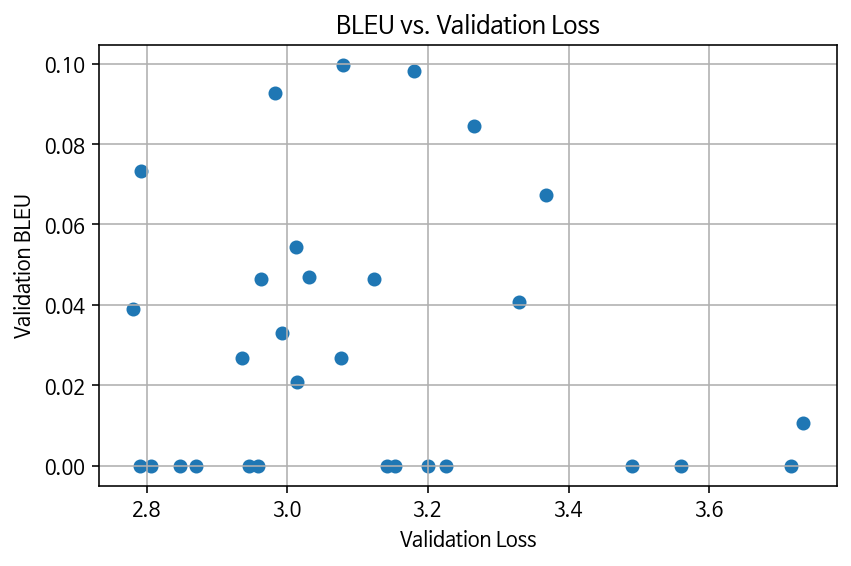

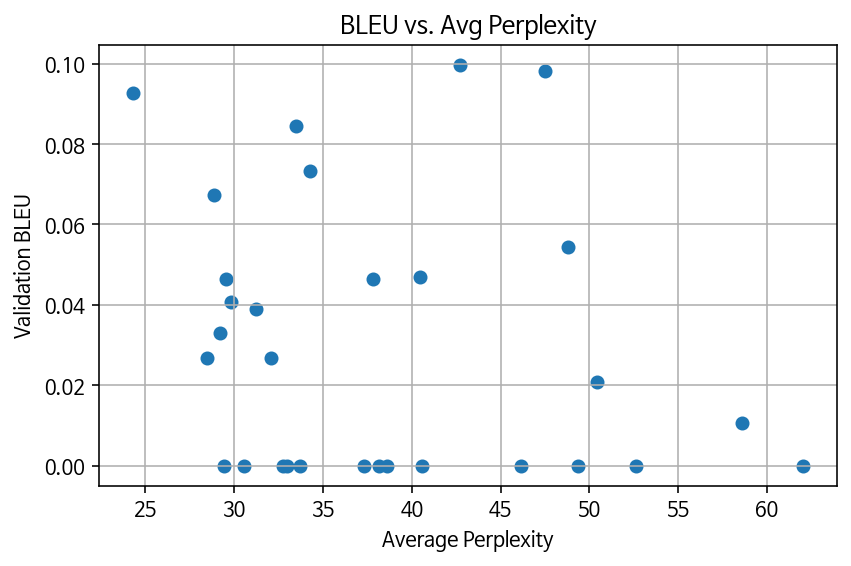

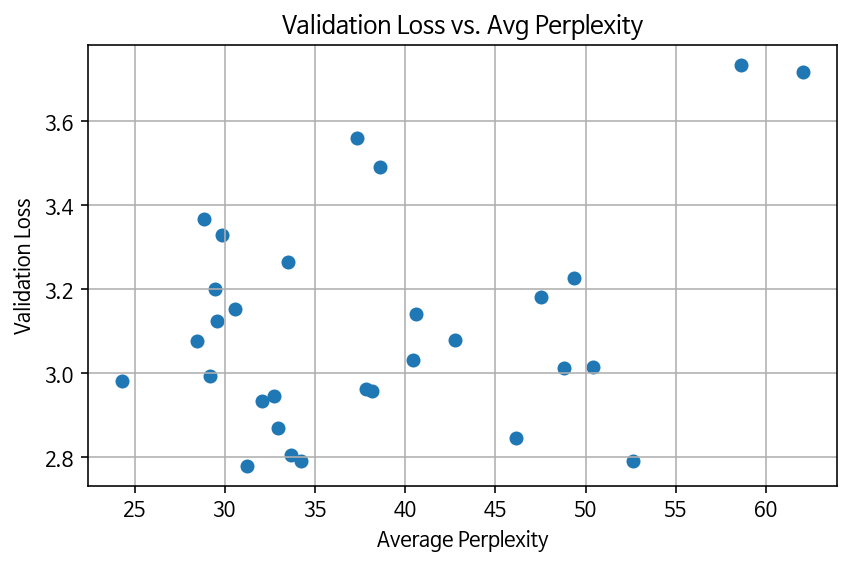

In [46]:
# 6) BLEU vs. Validation Loss (scatter)
plt.figure(figsize=(6,4))
plt.scatter(baseline['Validation_Loss'], baseline['BLEU'])
plt.xlabel("Validation Loss")
plt.ylabel("Validation BLEU")
plt.title("BLEU vs. Validation Loss")
plt.grid()
plt.tight_layout()
plt.show()

# 7) BLEU vs. Perplexity 평균 (scatter)
plt.figure(figsize=(6,4))
plt.scatter(baseline['perplexity_avg'], baseline['BLEU'])
plt.xlabel("Average Perplexity")
plt.ylabel("Validation BLEU")
plt.title("BLEU vs. Avg Perplexity")
plt.grid()
plt.tight_layout()
plt.show()

# 7) Validation Loss vs. Perplexity 평균 (scatter)
plt.figure(figsize=(6,4))
plt.scatter(baseline['perplexity_avg'], baseline['Validation_Loss'])
plt.xlabel("Average Perplexity")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs. Avg Perplexity")
plt.grid()
plt.tight_layout()
plt.show()

### 레이어 및 모델 차원수 에 따른 변화
- baseline 결과를 보면 레이어와 모델 차원이 클수록 지표가 좋아지는 것을 확인할 수 있다.
    - 레이어와 차원이 커지면 표현력이 커지는 부분이 있어 의미를 더 잘 파악하고 좋은 답변을 하는 것으로 보인다.
- 팀 결과를 보면 상관성이 이상한 부분이 있다. ( 팀 결과에 노이즈가 있을 수 있음 )
    - 레이어별 BLUE와 perplexity 지표를 보면 잘못된 증강으로 인해 학습이 될수록 답변이 이상해지는 결과를 초래했을수도 있다고 볼 수도

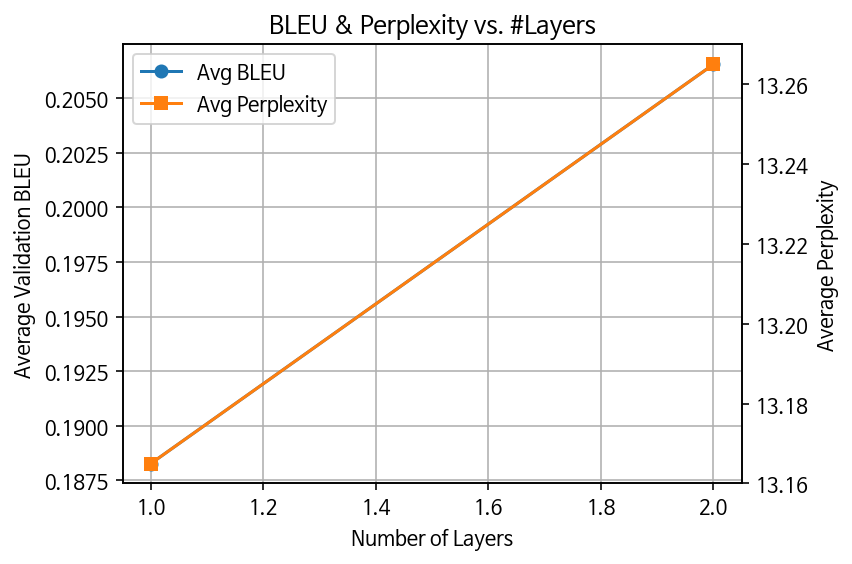

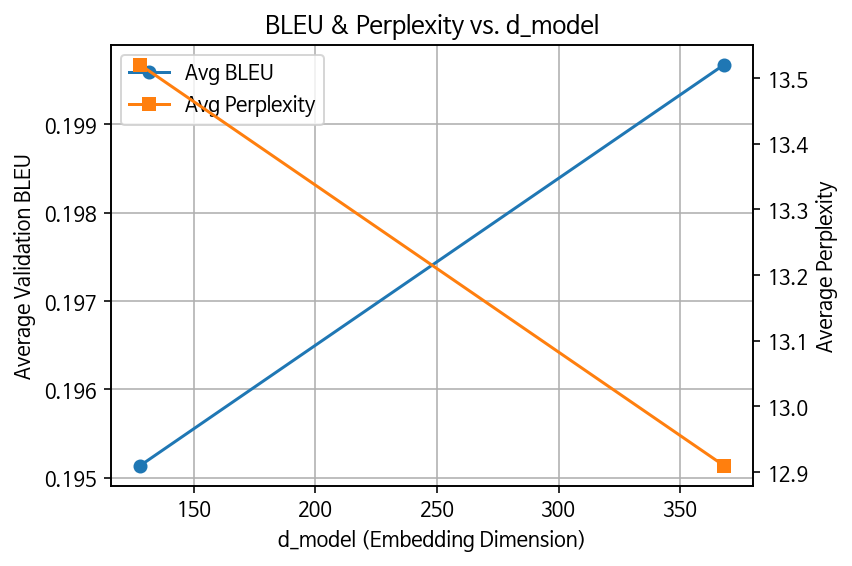

In [52]:
# 3) Layers별 BLEU & Avg Perplexity
layers_summary = team.groupby('n_layers').agg({
    'val_BLEU':       'mean',
    'perplexity_avg': 'mean'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()

ax1.plot(layers_summary['n_layers'], layers_summary['val_BLEU'],
         marker='o', label='Avg BLEU')
ax2.plot(layers_summary['n_layers'], layers_summary['perplexity_avg'],
         marker='s', color='tab:orange', label='Avg Perplexity')

ax1.set_xlabel("Number of Layers")
ax1.set_ylabel("Average Validation BLEU")
ax2.set_ylabel("Average Perplexity")
ax1.set_title("BLEU & Perplexity vs. #Layers")
ax1.grid(True)

# 범례 합치기
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.tight_layout()
plt.show()

# 4) d_model별 BLEU & Avg Perplexity
dmodel_summary = team.groupby('d_model').agg({
    'val_BLEU':       'mean',
    'perplexity_avg': 'mean'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()

ax1.plot(dmodel_summary['d_model'], dmodel_summary['val_BLEU'],
         marker='o', label='Avg BLEU')
ax2.plot(dmodel_summary['d_model'], dmodel_summary['perplexity_avg'],
         marker='s', color='tab:orange', label='Avg Perplexity')

ax1.set_xlabel("d_model (Embedding Dimension)")
ax1.set_ylabel("Average Validation BLEU")
ax2.set_ylabel("Average Perplexity")
ax1.set_title("BLEU & Perplexity vs. d_model")
ax1.grid(True)

# 범례 합치기
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.tight_layout()
plt.show()

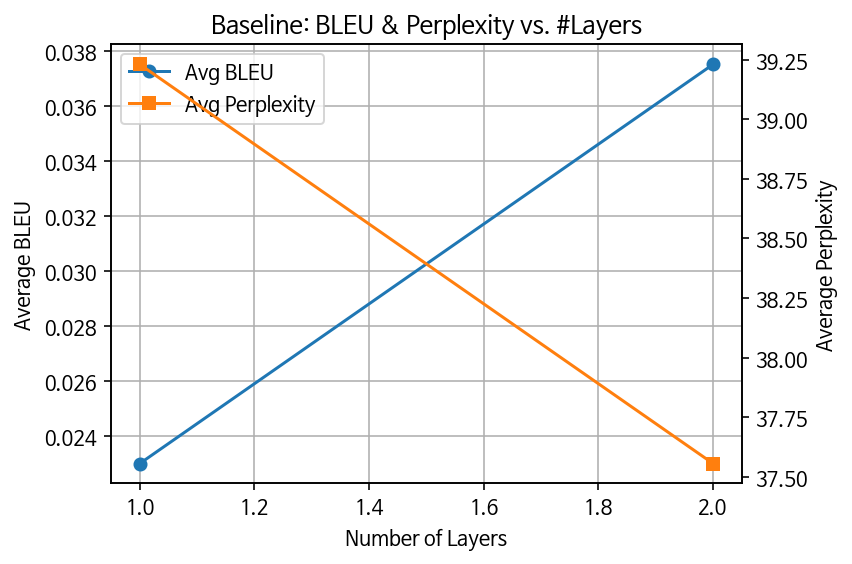

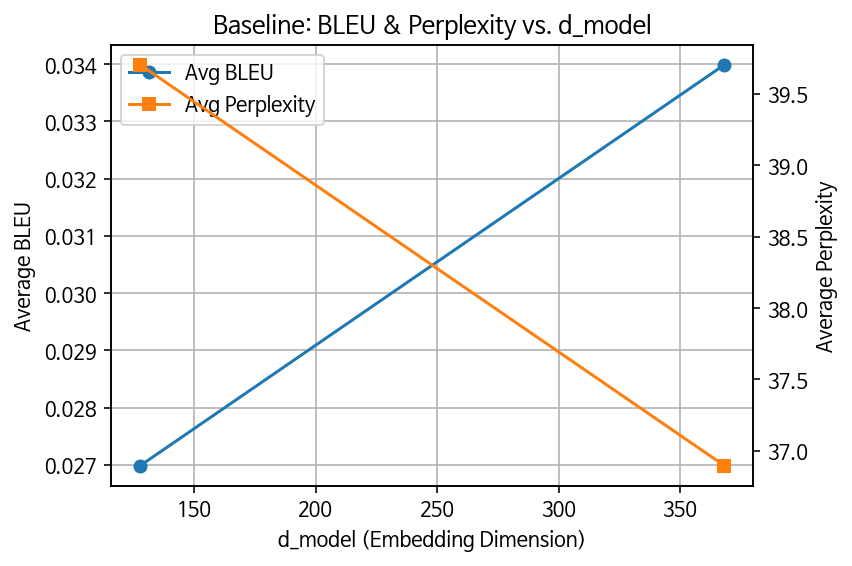

In [62]:

# 3) Layers별 BLEU & Avg Perplexity (Baseline)
layers_base = baseline.groupby('n_layers').agg({
    'BLEU':            'mean',
    'perplexity_avg':  'mean'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()

ax1.plot(layers_base['n_layers'], layers_base['BLEU'],
         marker='o', label='Avg BLEU')
ax2.plot(layers_base['n_layers'], layers_base['perplexity_avg'],
         marker='s', color='tab:orange', label='Avg Perplexity')

ax1.set_xlabel("Number of Layers")
ax1.set_ylabel("Average BLEU")
ax2.set_ylabel("Average Perplexity")
ax1.set_title("Baseline: BLEU & Perplexity vs. #Layers")
ax1.grid(True)

# 범례 합치기
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.tight_layout()
plt.show()

# 4) d_model별 BLEU & Avg Perplexity (Baseline)
dmodel_base = baseline.groupby('d_model').agg({
    'BLEU':            'mean',
    'perplexity_avg':  'mean'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()

ax1.plot(dmodel_base['d_model'], dmodel_base['BLEU'],
         marker='o', label='Avg BLEU')
ax2.plot(dmodel_base['d_model'], dmodel_base['perplexity_avg'],
         marker='s', color='tab:orange', label='Avg Perplexity')

ax1.set_xlabel("d_model (Embedding Dimension)")
ax1.set_ylabel("Average BLEU")
ax2.set_ylabel("Average Perplexity")
ax1.set_title("Baseline: BLEU & Perplexity vs. d_model")
ax1.grid(True)

# 범례 합치기
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.tight_layout()
plt.show()

## 결론 

- 정상적인 답변 데이터 결과를 토대로하면 실험범위에서는 Layer 수와 차원수가 높아지면 답변이 좋아지는 것을 확인 할 수 있다.
- 좋은 응답과 perplexity 지표와는 어느정도의 상관관계를 보이나 절대적인 것은 아니다.
- BLEU 및 Loss 값은 정답이 필요한 지표로 검증 데이터에 대한 답변 정확도는 알 수 있으나 이를 통해 테스트 데이터의 답변이 얼마나 좋을지를 알 수 없음
- 좋은 증강 기법을 이용하여 질문과 답변을 적절히 만들어 증강을 하면 지표 및 응답 결과의 질이 좋아진다.
- 잘못된 증강 기법 예를 들어 답변의 문법 자체를 이상하게 만드는 증강등을 적용하면 답변의 질이 매우 떨어지는 것을 알 수 있다.


## 회고

 이번 프로젝트에서는 데이터 증강 및 하이퍼 파라미터에 따른 트랜스포머 챗봇의 응답 질의 변화를 관찰하였다. 팀원들과 실험 설계 및 역활 분담하여 진행하였는데 우리는 증강 기법 및 하이퍼파라미터(레이어, 차원수) 를 변경하며 실험하였다. 맡은 부분은 평가 지표 적용 및 baseline (증강 데이터 미적용) 테스트 진행이었으나 여러가지로 아쉬움이 남는 실험이다. 컴퓨터의 문제로 인해 시간내에 baseline 결과를 팀에 전달하지 못해 좀 늦게 전달한 점도 아쉽다. 나름 실험 설계 및 변인 통제에 신경을 썼으나 미쳐 신경쓰지 못한 부분도 있었다. 아직은 공부를 하는 과정이므로 이런 부분은 기억해두어야겠다. 그리고 시간이 된다면 결과가 의심되는 부분들에 대해서는 재실험을 해보는 것도 의미가 있을듯하다. 다음 프로젝트를 진행시에는 이런 부분을 좀 더 신경써야겠다.

- 아쉬운점
    - 실험 변인 통제의 아쉬움 : 베이스라인 모델까지는 같은 코드였으나 해당 코드에 추론 함수가 없었는데 추론 함수를 제외한 지표 확인용 점수 코드들만 공유되어 추론함수가 다르게 적용되면서 오류가 있었을 가능성 ( backtrans 데이터의 모든 실험의 결과가 같은 부분 )
    - 증강을 1차로 마치기 전 train 과 valid data 를 구분하여 증강하지 않고 증강된 데이터도 구분할 수 없게 생성되어 다시 나누어 증강하느라 시간이 낭비된 부분 
    - koEDA 에서 답변은 문법이나 의미상으로 이상이 없어야 한다는 조건을 증강전에 이야기했으나 실제 증강된 데이터들은 적용하면 안되는 기법들이 적용된 부분 - 이로 인해 잘못된 증강이 초래하는 결과를 확인할 수는 있었음
    - BackTranslation  - 위의 시간낭비의 이유로 인해 다시 하는 과정에서 시간문제로 인해 증강 데이터 생성량이 적어져서 아쉬움.
    - 평가 지표를 다양하게 검색하고 적용하려 했으나 정답이 필요한 지표들은 적용할 수 없었고 레퍼런스프리 지표들도 lms 설치 이슈나 지원중단, 비공개 등으로 이번 프로젝트에 적용이 어려워 아쉬웠다. 질문 답변 구분한 perplexity 에서도 어느정도의 연관성이 보여서 레퍼런스프리 지표들을 몇가지 측정해 종합적으로 판단해보면 좀 더 의미있는 결과가 나오지 않았을까